In [1]:
!pip install xgboost
!pip install lightgbm
!pip install holidays
!pip install statsforecast
!pip install pmdarima
!pip install statsmodels
!pip install prophet
!pip install SciPy
!pip install pmdarima
!pip install shap

In [2]:
#import basic libary
import math
import pandas as pd                     # to extract data from dataset(.csv file)
import csv                              #used to read and write to csv files
import numpy as np                      #used to convert input into numpy arrays to be fed to the model
import matplotlib.pyplot as plt         #to plot/visualize sales data and sales forecasting
import seaborn as sns


# Holiday
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar


# warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Machine learning algorithm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesRegressor


# Statistics
import statsmodels.api as sm
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from pmdarima import auto_arima
from prophet import Prophet

#deep learning

import tensorflow as tf                 # acts as the framework upon which this model is built
from tensorflow import keras            #defines layers and functions in the model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Activation

#pre-process
from sklearn import preprocessing

#evaluate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# model generation
import shap


In [3]:
# if you run on google cloab with google drive the below code is required and give the permission to the google drive by login
# if you run on your computer then you can skip upto 3 steps
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import pandas as pd
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
# after the given permission to access the google drive. take the parth of folder you want to acccess for the training and testing file
file_list = drive.ListFile({'q': "'1Bju_8kPzonrkZ85NhH_7eYBEz4owbWUI' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: Sales predication.ipynb, id: 1kEsoAYfbqxmhFpkY0iM-vL2eKR8RVQ72
title: Untitled5.ipynb, id: 1YUZ2Q8cnMNgEzu_XcJcfFu5yme9lFDhT
title: Untitled4.ipynb, id: 1sN5pw9Yo4-U8v1FXSH__2BuCGQauWSXz
title: Untitled3.ipynb, id: 1nPhl01EZg4RzfZT8H_BAxXaQ9bRF-6k6
title: Untitled2.ipynb, id: 1BpHux8NCapONh11zufV6bRlOSLi47Ml4
title: Untitled1.ipynb, id: 1USPHJaHWjnZ15CLr8wGtwIo2O1cy_k_q
title: sales_date.csv, id: 1jWkgnrknOcQJ4LFO3lW_y_yWudYWw7fn
title: Untitled0.ipynb, id: 1ADeufw9n0elhOsleZrjMyIe4p8cqInel
title: train.csv, id: 1cJVfNSerIXKfTLINt40VHzUQoEc0vkEw
title: stores.csv, id: 1YqhBfmtRH94t94va-64ogpPEcv2K9wkw
title: test.csv, id: 1lr3dVicyEJ20PTbncGqjJiVSL7WdUzZx
title: sample_submission.csv, id: 1xXyOBY-zlWBeUzZZbb0CoEdlcHrSdYOg
title: Walmart.csv, id: 1EbCC2WiEssIKKfmF2xq0X_-iTAzwLJC6
title: features.csv, id: 1D_mF3BctLpPfh3L-yMXNavc8FBRvlM-4


In [5]:
#list of all the file in the the above folder mention.
# take the id of that file you want to you for training and tesing and give the name as train.csv and test.csv
train_downloaded = drive.CreateFile({'id': '1jWkgnrknOcQJ4LFO3lW_y_yWudYWw7fn'})
train_downloaded.GetContentFile('sales_data.csv')

In [6]:
# read CSV
data  = pd.read_csv('sales_data.csv')
data.head(100)

date  sales
0   01-01-2013     13
1   02-01-2013     11
2   03-01-2013     14
3   04-01-2013     13
4   05-01-2013     10
..         ...    ...
95  06-04-2013     23
96  07-04-2013     17
97  08-04-2013     19
98  09-04-2013     13
99  10-04-2013     19

[100 rows x 2 columns]

In [7]:
# different kind date format in csv
data["date"] = pd.to_datetime(data["date"], format='%d-%m-%Y', errors='ignore').astype('datetime64[D]')
data["date"] = pd.to_datetime(data["date"], format='%d/%m/%Y', errors='ignore').astype('datetime64[D]')
data.head(15)

date  sales
0  2013-01-01     13
1  2013-01-02     11
2  2013-01-03     14
3  2013-01-04     13
4  2013-01-05     10
5  2013-01-06     12
6  2013-01-07     10
7  2013-01-08      9
8  2013-01-09     12
9  2013-01-10      9
10 2013-01-11      9
11 2013-01-12      7
12 2013-01-13     10
13 2013-01-14     12
14 2013-01-15      5

In [8]:
# extract the day, month, year and week day from the date
data['date'] = pd.to_datetime(data['date'])
data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['weekday'] = data['date'].dt.weekday

In [9]:
# find the holiday on each date
cal = calendar()
holidays = cal.holidays(start=data['date'].min(), end=data['date'].max())

data['Holiday'] = data['date'].isin(holidays)
print(data)

           date  sales  day  month  year  weekday  Holiday
0    2013-01-01     13    1      1  2013        1     True
1    2013-01-02     11    2      1  2013        2    False
2    2013-01-03     14    3      1  2013        3    False
3    2013-01-04     13    4      1  2013        4    False
4    2013-01-05     10    5      1  2013        5    False
...         ...    ...  ...    ...   ...      ...      ...
1821 2017-12-27     14   27     12  2017        2    False
1822 2017-12-28     19   28     12  2017        3    False
1823 2017-12-29     15   29     12  2017        4    False
1824 2017-12-30     27   30     12  2017        5    False
1825 2017-12-31     23   31     12  2017        6    False

[1826 rows x 7 columns]


In [10]:
# label encoding for holiday attribute
le = preprocessing.LabelEncoder()
data['Holiday'] = le.fit_transform(data.Holiday.values)

In [11]:
# sort the data
data.sort_values(by='date')
print(data)

           date  sales  day  month  year  weekday  Holiday
0    2013-01-01     13    1      1  2013        1        1
1    2013-01-02     11    2      1  2013        2        0
2    2013-01-03     14    3      1  2013        3        0
3    2013-01-04     13    4      1  2013        4        0
4    2013-01-05     10    5      1  2013        5        0
...         ...    ...  ...    ...   ...      ...      ...
1821 2017-12-27     14   27     12  2017        2        0
1822 2017-12-28     19   28     12  2017        3        0
1823 2017-12-29     15   29     12  2017        4        0
1824 2017-12-30     27   30     12  2017        5        0
1825 2017-12-31     23   31     12  2017        6        0

[1826 rows x 7 columns]




`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating you

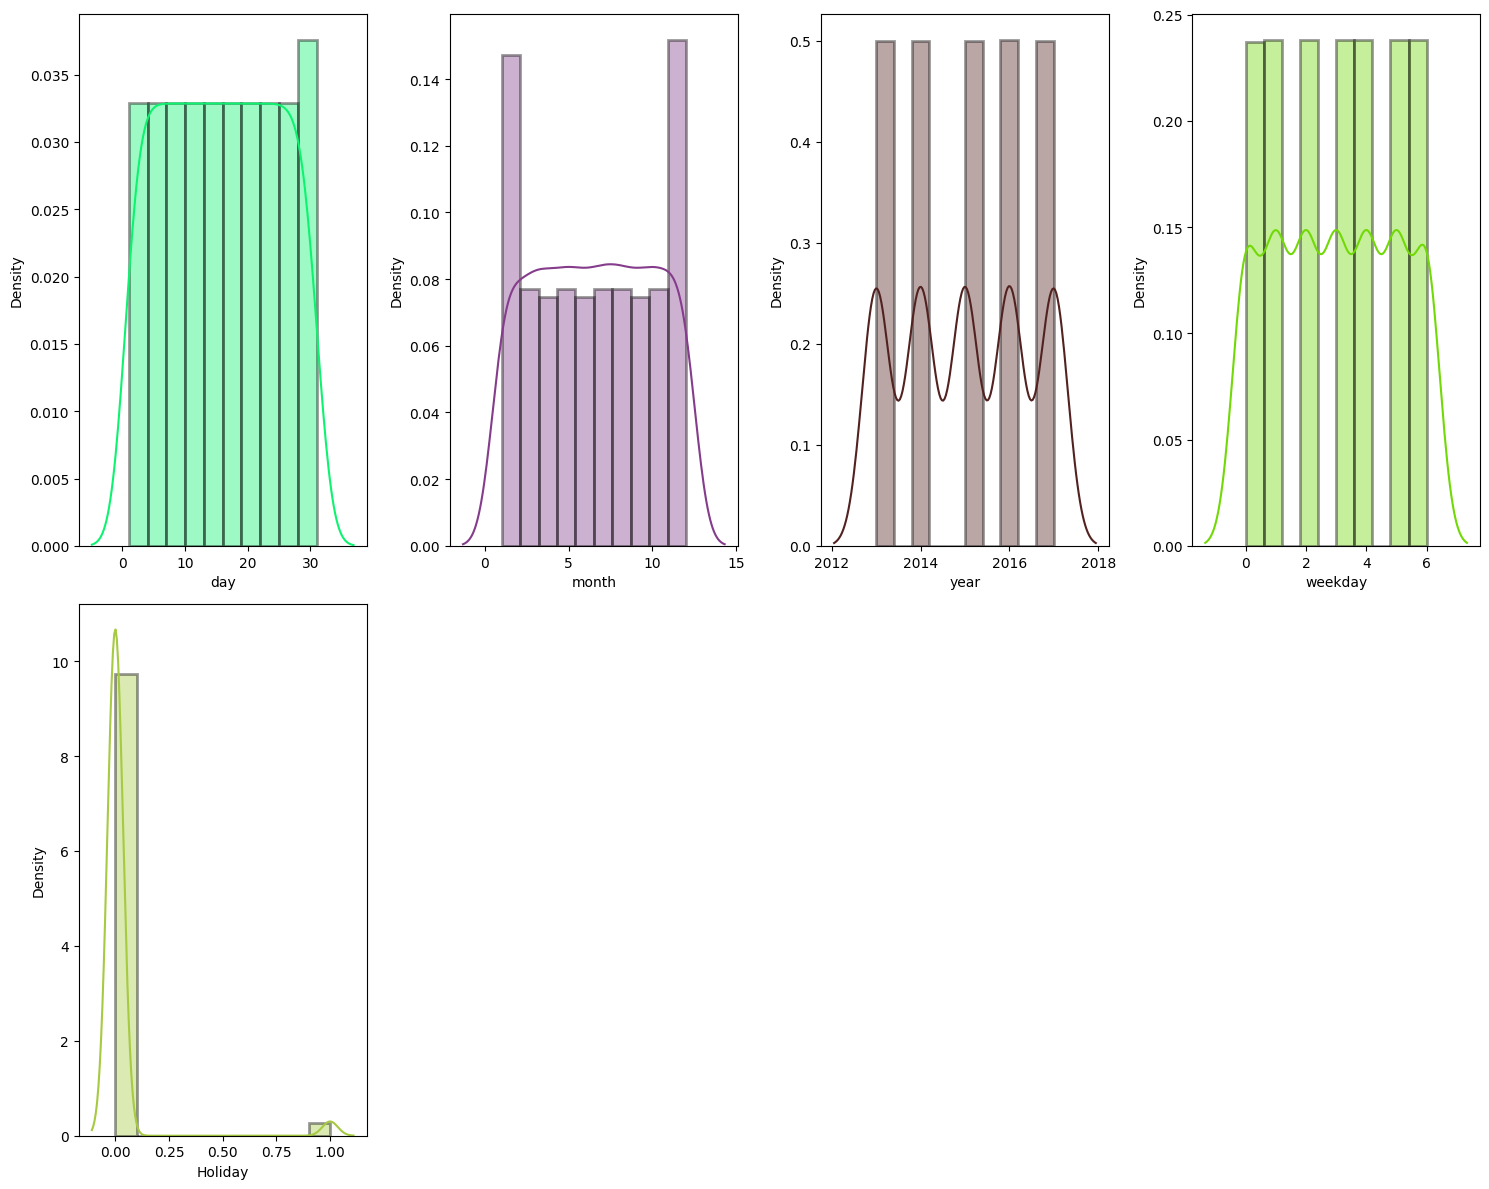

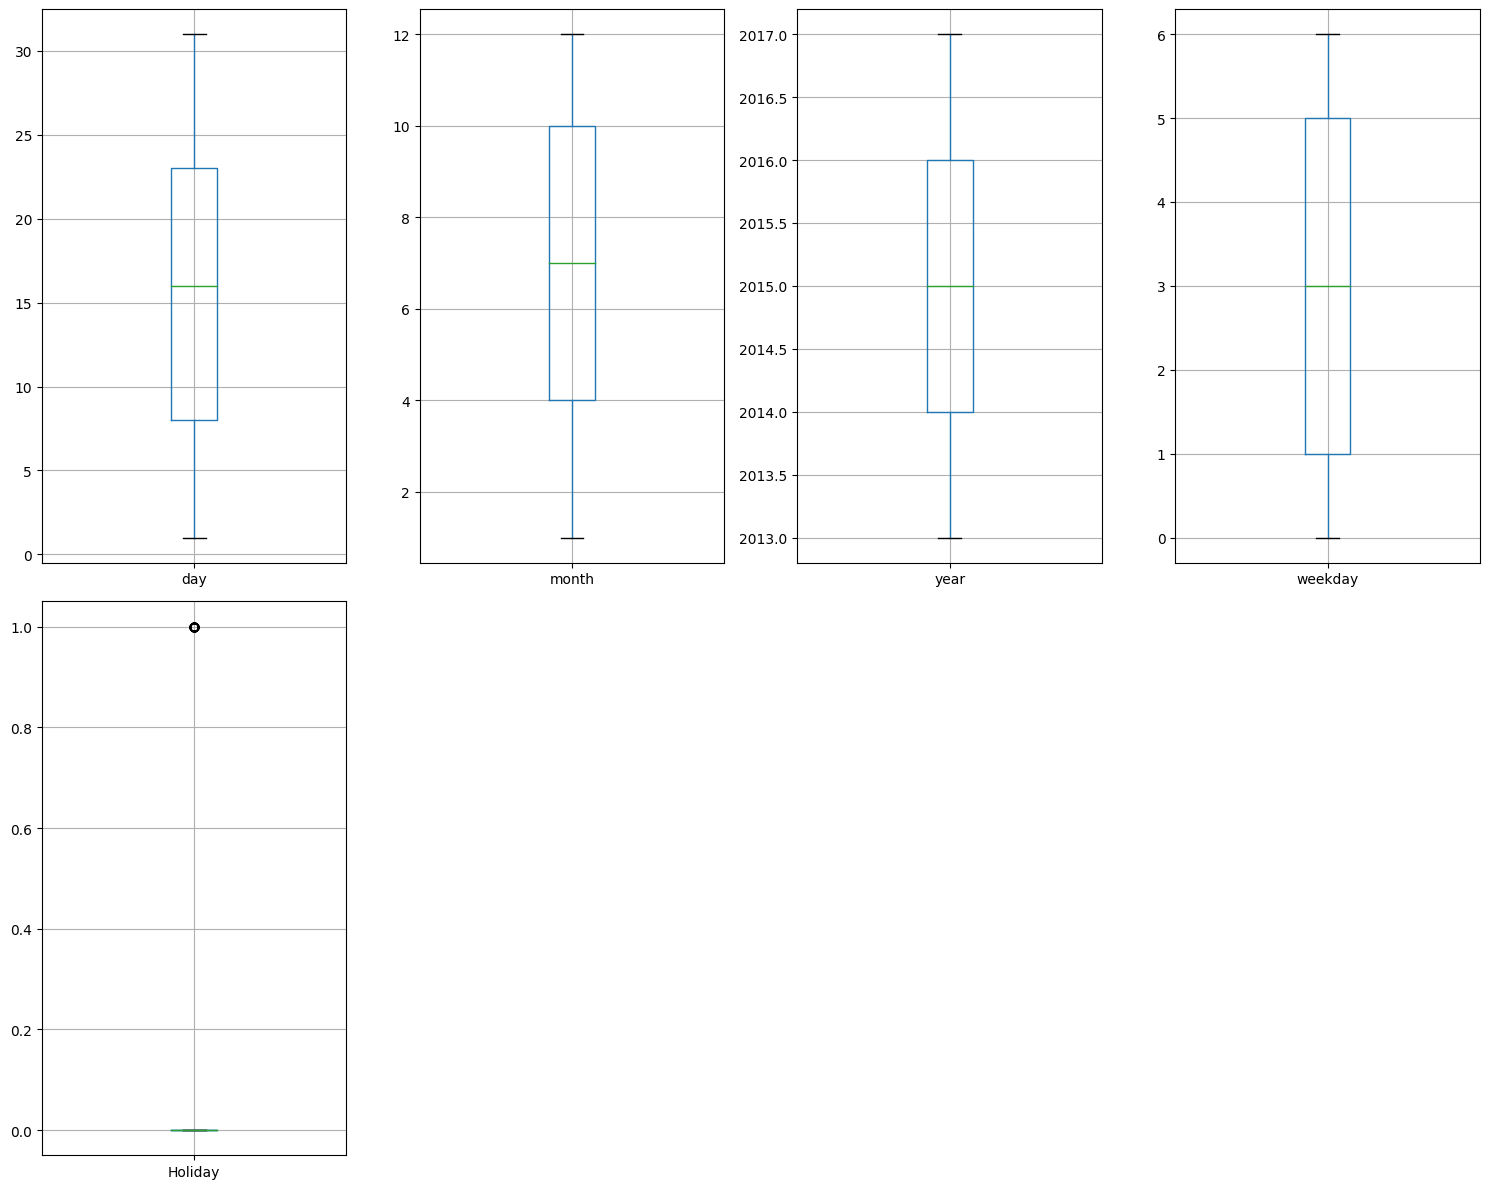

In [12]:
# visualization the all the attribute
nf=['day' ,'month','year','weekday','Holiday']
n=4
clr=['r','g','b','g','b','r']

plt.figure(figsize=[15,6*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    sns.distplot(data[nf[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,6*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    data.boxplot(nf[i])
plt.tight_layout()
plt.show()

In [13]:
# spilt the data for training and testing. Testing having last one year (2017) and training contain 4 years ( 2013,2014,2015,2016)
unique_years = data['year'].unique()

# split the data into training and test sets
train_years = unique_years[:-1]
test_years = unique_years[-1]
print(unique_years)

[2013 2014 2015 2016 2017]


In [14]:
print(train_years.shape)
print(test_years.shape)

(4,)
()


In [15]:
#spilt the data into training and testing. last year data given to testing
train_data = data[data['year'].isin(train_years)]
test_data = data[data['year'] == test_years]

In [16]:
print(train_data.shape)
print(test_data.shape)

(1461, 7)
(365, 7)


In [17]:
X_train = train_data[['day', 'month', 'year', 'weekday', 'Holiday']]
y_train = train_data['sales']
X_test = test_data[['day', 'month', 'year', 'weekday', 'Holiday']]
y_test = test_data['sales']

In [18]:
# define the function for graph and evaluating paramater for the model
CM =pd.DataFrame(np.zeros([21,6]), columns=['Train_R2','Train_MSE','Train_RMSE','Test_R2','Test_MSE','Test_RMSE'])
def Evaluate(n, y_pred1,y_pred2):
  #plot the graph testing vs predicated value
  plt.scatter(range(len(y_test)), y_test, color='blue')
  plt.scatter(range(len(y_pred2)), y_pred2, color='red')
  plt.show()
  # evaluate the model on the training data

  print('{}{}\033[1m Training Set \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))

  train_r2=r2_score(y_train, y_pred1)
  CM.loc[n,'Train_R2'] = train_r2
  print("R2 Score:", train_r2)
  train_mse = mean_squared_error(y_train, y_pred1)
  CM.loc[n,'Train_MSE']=train_mse
  print("Mean square error ",train_mse)
  train_rmse=math.sqrt(mean_squared_error(y_train, y_pred1))
  CM.loc[n,'Train_RMSE'] = train_rmse
  print("Root Mean square error",train_rmse)

  print('{}{}\033[1m Testing Set \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))

  # evaluate the model on the test data
  test_r2=r2_score(y_test, y_pred2)
  CM.loc[n,'Test_R2'] = test_r2
  print("R2 Score:", test_r2)
  test_mse=mean_squared_error(y_test, y_pred2)
  CM.loc[n,'Test_MSE'] = test_mse
  print("Mean square error ",test_mse)
  test_rmse=math.sqrt(mean_squared_error(y_test, y_pred2))
  CM.loc[n,'Test_RMSE'] = test_rmse
  print("Root Mean square error",test_rmse)

  # plot the graph for original data vs predicated value
  fig, ax = plt.subplots(figsize=(15,5))
  sns.lineplot(x=data.date, y=data.sales, data=data, ax=ax,
              label='Original', color='mediumblue')

  sns.lineplot(x=test_data.date,y= y_pred2, data=test_data, ax=ax,
              label='Predicted', color='Red')

  ax.set(xlabel = "Date",
        ylabel = "Sales",
        title = " Sales Forecasting Prediction")

  ax.legend()

  sns.despine()


In [19]:
def shar_model(model):
  #shap.initjs()

  explainer = shap.Explainer(model)
  shap_values = explainer(X_test)
  shap.plots.waterfall(shap_values[0])
  #shap.force_plot(explainer.expected_value, shap_values, X_train)

In [20]:
def shar_model1(model):
  sample_ind=20
  explainer = shap.Explainer(model.predict, X_test)
  shap_values = explainer(X_test)
  shap.plots.waterfall(shap_values[sample_ind], max_display=14)
  #shap.force_plot(shap_values[sample_ind], shap_values, X_test)

<<<----------------------------------- Evaluating on Random Forest Model ----------------------------------->>>



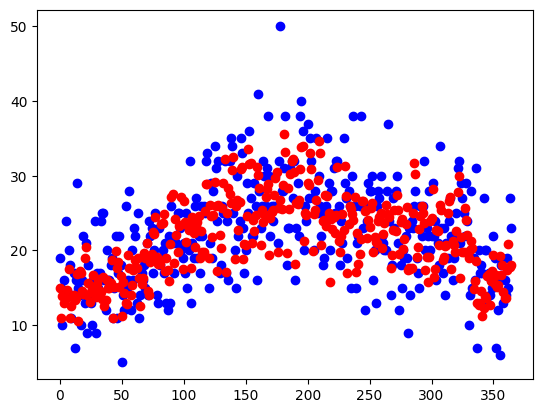

<<<----------------------------------- Training Set ----------------------------------->>>

R2 Score: 0.9300777742530278
Mean square error  3.0198953969883644
Root Mean square error 1.7377846233030043
<<<----------------------------------- Testing Set ----------------------------------->>>

R2 Score: 0.4242817232895143
Mean square error  27.758613767123286
Root Mean square error 5.2686443955844355


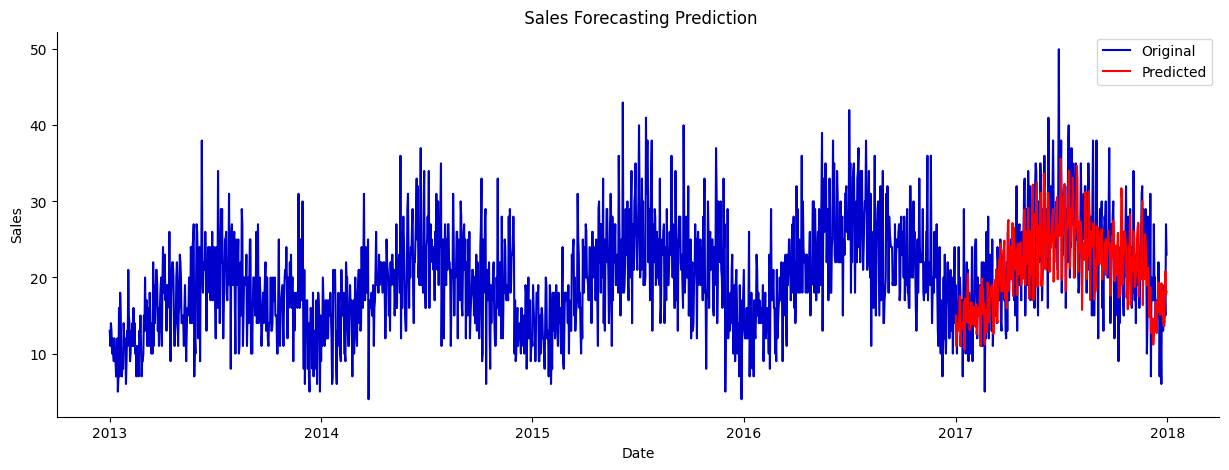

In [21]:
# model
RF = RandomForestRegressor(n_estimators=200)

# train the model on the training data
RF.fit(X_train, y_train)

#predict the traing and testing values
pred1 = RF.predict(X_train)
pred2 = RF.predict(X_test)

print('{}{}\033[1m Evaluating on Random Forest Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)


Evaluate(0, pred1, pred2)


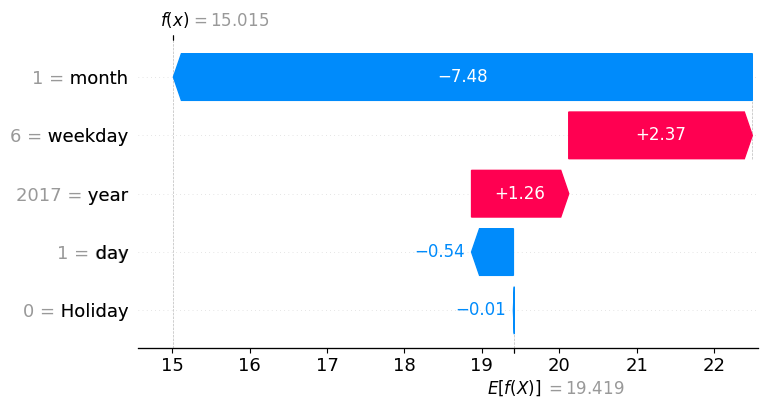

In [22]:
shar_model(RF)

<<<----------------------------------- Evaluating on Linear Model ----------------------------------->>>



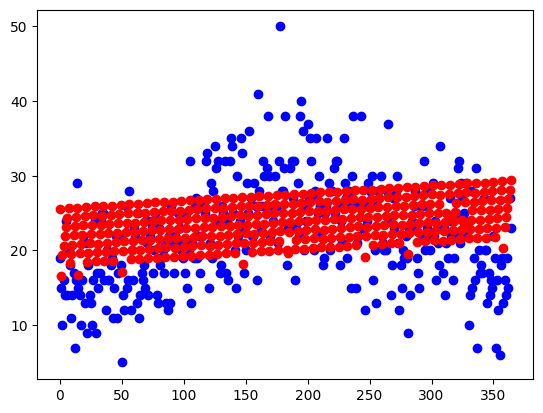

<<<----------------------------------- Training Set ----------------------------------->>>

R2 Score: 0.25959446869427805
Mean square error  31.97763274850695
Root Mean square error 5.654876899500726
<<<----------------------------------- Testing Set ----------------------------------->>>

R2 Score: 0.16162816919604872
Mean square error  40.42261777321661
Root Mean square error 6.357878401889785


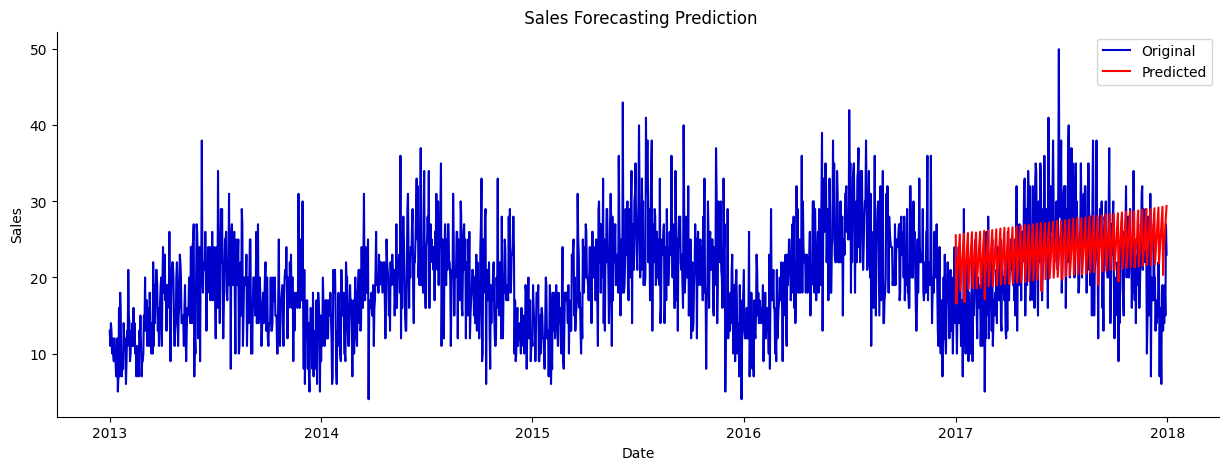

In [23]:
# model
LR = LinearRegression()

# train the model on the training data
LR.fit(X_train, y_train)

#predict the traing and testing values
pred1 = LR.predict(X_train)
pred2 = LR.predict(X_test)

print('{}{}\033[1m Evaluating on Linear Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)

Evaluate(1, pred1, pred2)

ExactExplainer explainer: 366it [00:13, 24.64it/s]                          


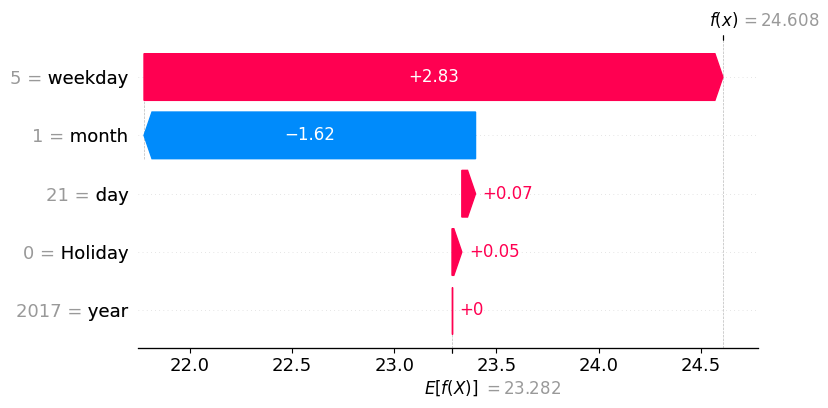

In [24]:
shar_model1(LR)

<<<----------------------------------- Evaluating on Lasso Model ----------------------------------->>>



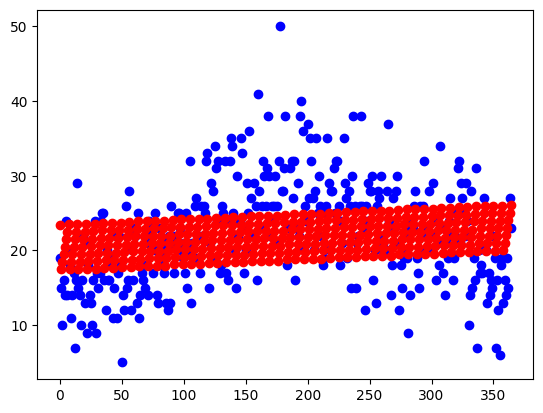

<<<----------------------------------- Training Set ----------------------------------->>>

R2 Score: 0.23152854580702653
Mean square error  33.18978168161083
Root Mean square error 5.761057340593897
<<<----------------------------------- Testing Set ----------------------------------->>>

R2 Score: 0.18590847904473984
Mean square error  39.25192757542247
Root Mean square error 6.265135878448485


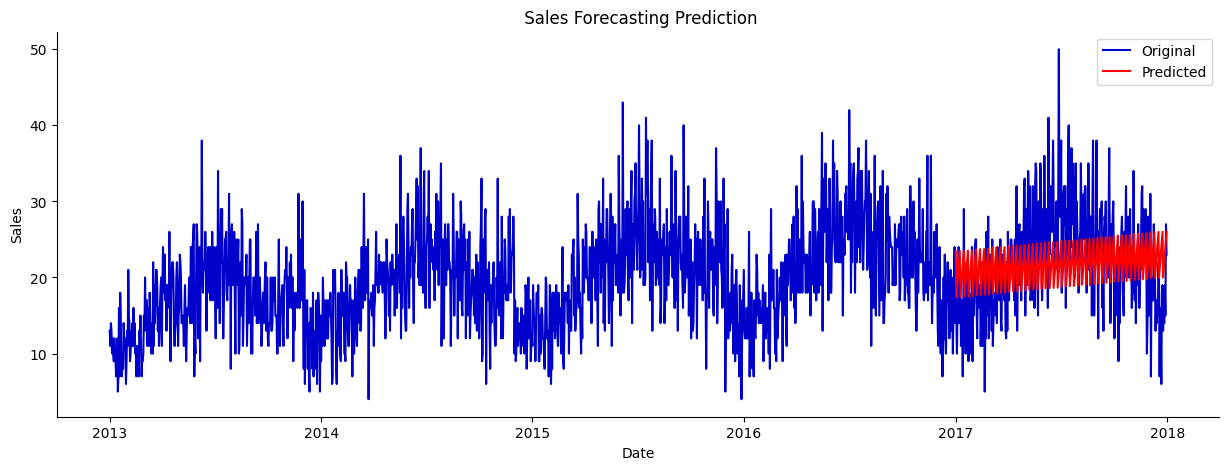

In [25]:
# model
Las = Lasso()

# train the model on the training data
Las.fit(X_train, y_train)

#predict the traing and testing values
pred1 = Las.predict(X_train)
pred2 = Las.predict(X_test)

print('{}{}\033[1m Evaluating on Lasso Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)

Evaluate(2, pred1, pred2)

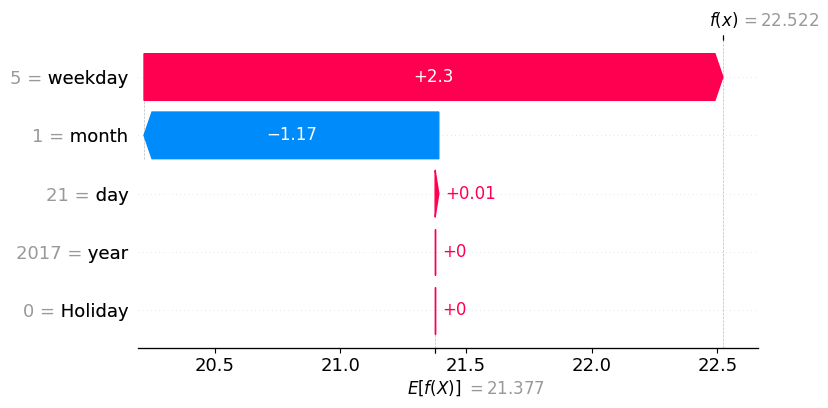

In [26]:
shar_model1(Las)

<<<----------------------------------- Evaluating on ElasticNet Model ----------------------------------->>>



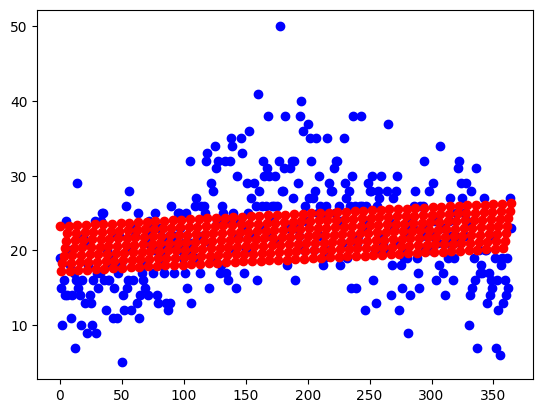

<<<----------------------------------- Training Set ----------------------------------->>>

R2 Score: 0.2338310845381576
Mean square error  33.090336533215634
Root Mean square error 5.752420058828774
<<<----------------------------------- Testing Set ----------------------------------->>>

R2 Score: 0.18849273731268268
Mean square error  39.12732596029884
Root Mean square error 6.255183926975996


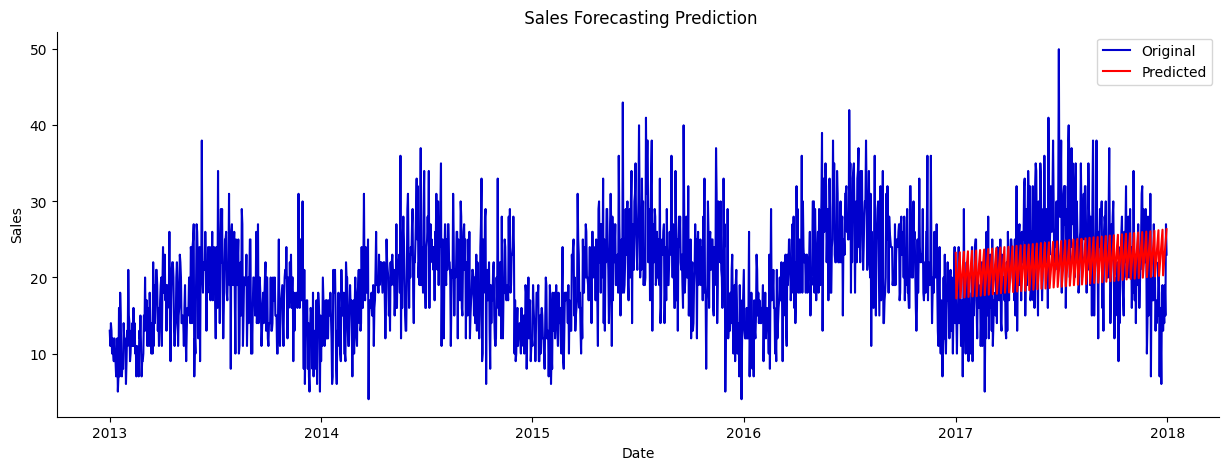

In [27]:
#model
EN = ElasticNet()

# train the model on the training data
EN.fit(X_train, y_train)
# train the model on the training data
EN.fit(X_train, y_train)

#predict the traing and testing values
pred1 = EN.predict(X_train)
pred2 = EN.predict(X_test)

print('{}{}\033[1m Evaluating on ElasticNet Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)

Evaluate(3, pred1, pred2)

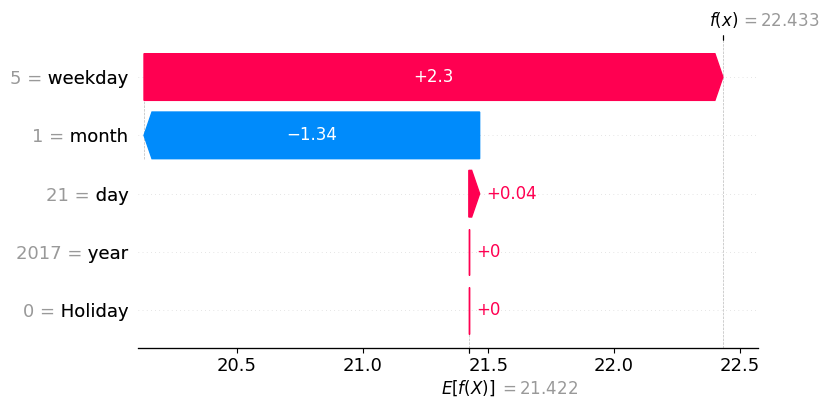

In [28]:
shar_model1(EN)

<<<----------------------------------- Evaluating on XGBoost Model ----------------------------------->>>



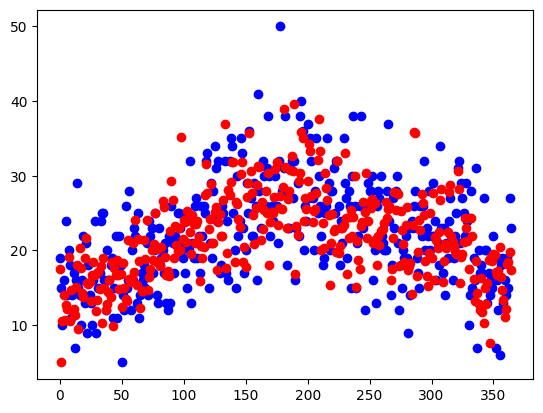

<<<----------------------------------- Training Set ----------------------------------->>>

R2 Score: 0.9577433597728524
Mean square error  1.8250367740858444
Root Mean square error 1.350939219241874
<<<----------------------------------- Testing Set ----------------------------------->>>

R2 Score: 0.3271569105869351
Mean square error  32.441546847552246
Root Mean square error 5.695748137650773


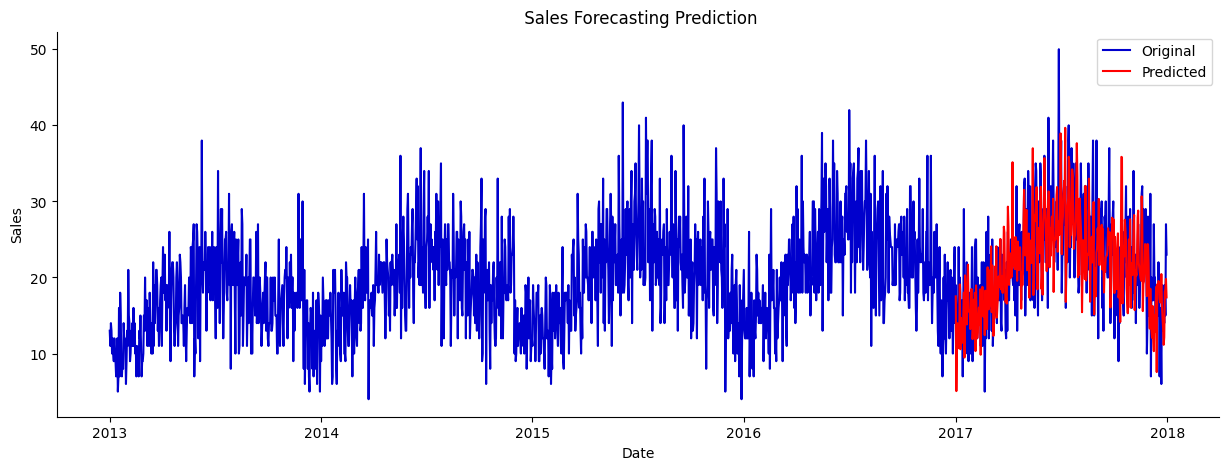

In [29]:
#model
XGB = xgb.XGBRegressor()

# train the model on the training data
XGB.fit(X_train, y_train)

#predict the traing and testing values
pred1 = XGB.predict(X_train)
pred2 = XGB.predict(X_test)

print('{}{}\033[1m Evaluating on XGBoost Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)

Evaluate(4, pred1, pred2)

[07:02:20] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


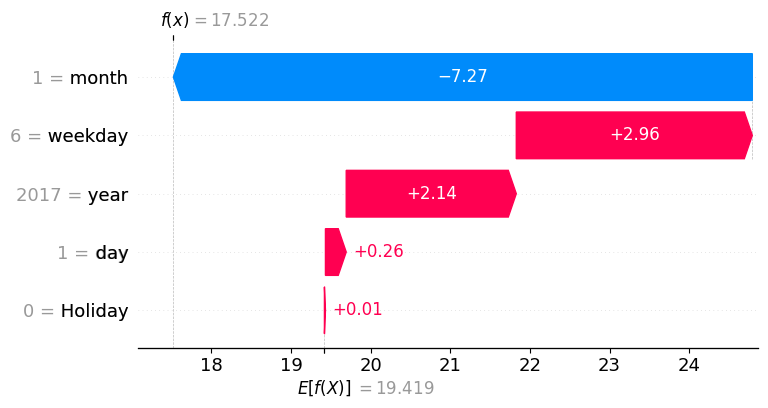

In [30]:
shar_model(XGB)

<<<----------------------------------- Evaluating on Decision Tree Model ----------------------------------->>>



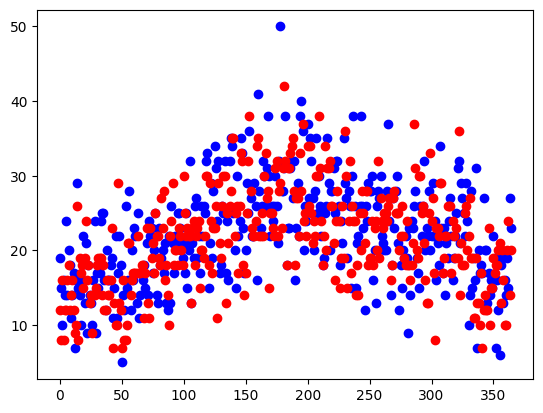

<<<----------------------------------- Training Set ----------------------------------->>>

R2 Score: 1.0
Mean square error  0.0
Root Mean square error 0.0
<<<----------------------------------- Testing Set ----------------------------------->>>

R2 Score: 0.19454284142385359
Mean square error  38.83561643835616
Root Mean square error 6.231822882460329


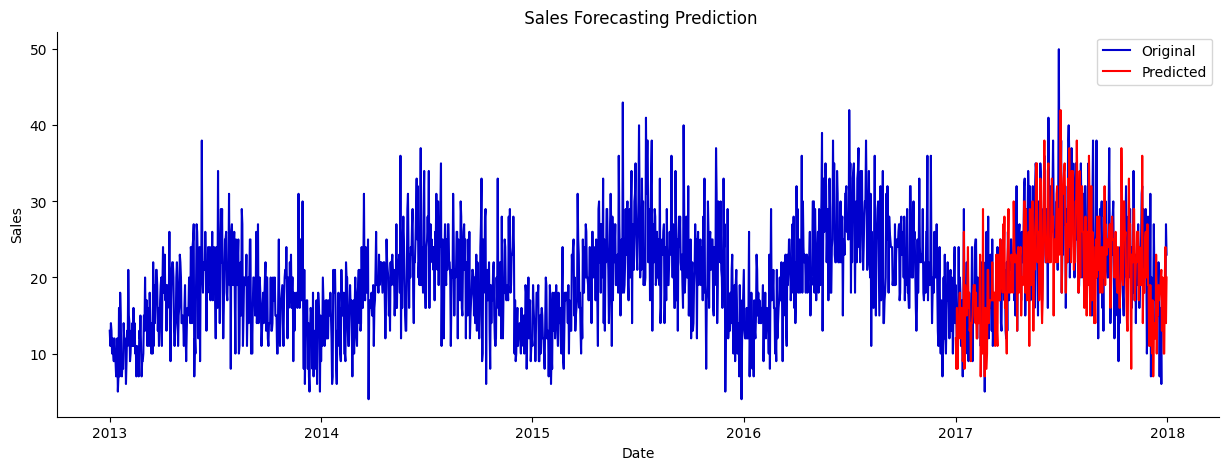

In [31]:
#model
DT = DecisionTreeRegressor()

# train the model on the training data
DT.fit(X_train, y_train)

#predict the traing and testing values
pred1 = DT.predict(X_train)
pred2 = DT.predict(X_test)

print('{}{}\033[1m Evaluating on Decision Tree Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)

Evaluate(5, pred1, pred2)

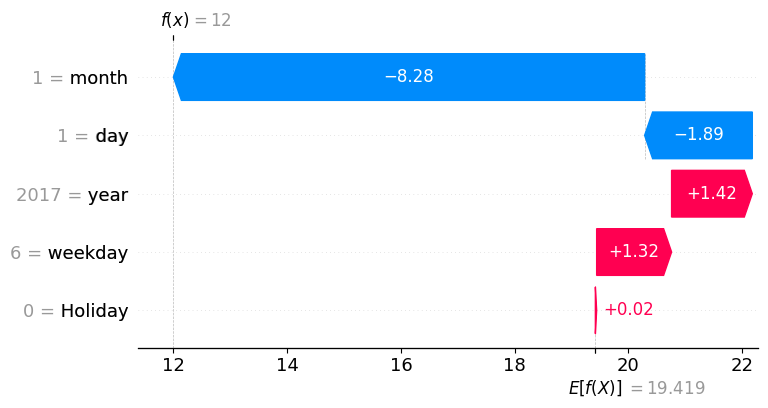

In [32]:
shar_model(DT)

<<<----------------------------------- Evaluating on Gaussian Model ----------------------------------->>>



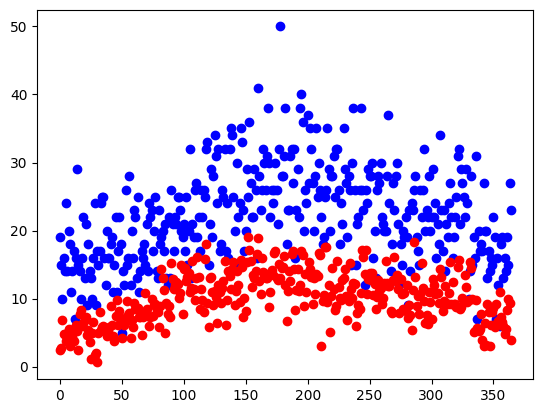

<<<----------------------------------- Training Set ----------------------------------->>>

R2 Score: 1.0
Mean square error  1.4672866942034944e-18
Root Mean square error 1.2113161000347905e-09
<<<----------------------------------- Testing Set ----------------------------------->>>

R2 Score: -2.726265774804851
Mean square error  179.6642153302241
Root Mean square error 13.403888067655


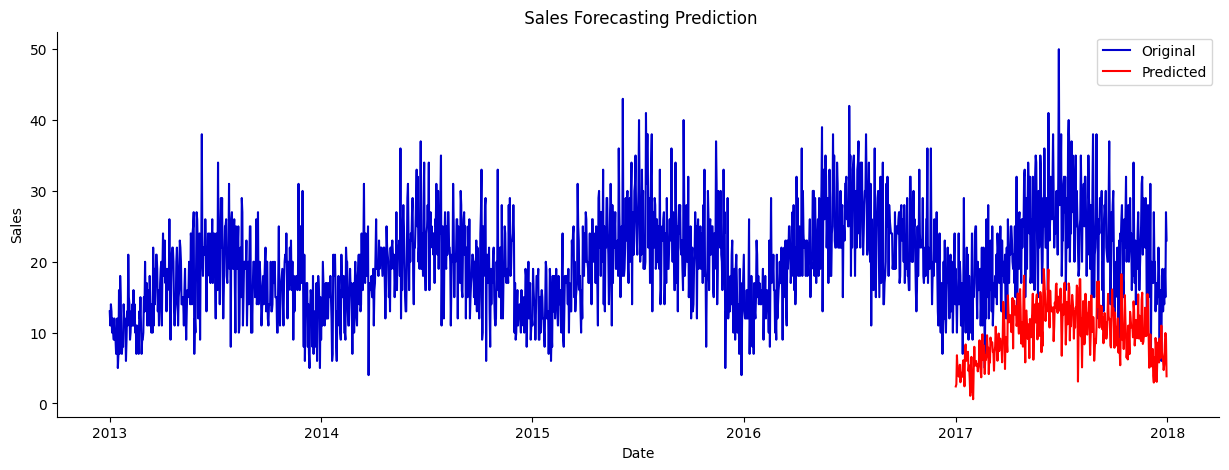

In [33]:
#model
GP = GaussianProcessRegressor()

# train the model on the training data
GP.fit(X_train, y_train)

#predict the traing and testing values
pred1 = GP.predict(X_train)
pred2 = GP.predict(X_test)

print('{}{}\033[1m Evaluating on Gaussian Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)

Evaluate(6, pred1, pred2)

ExactExplainer explainer: 366it [01:47,  3.11it/s]


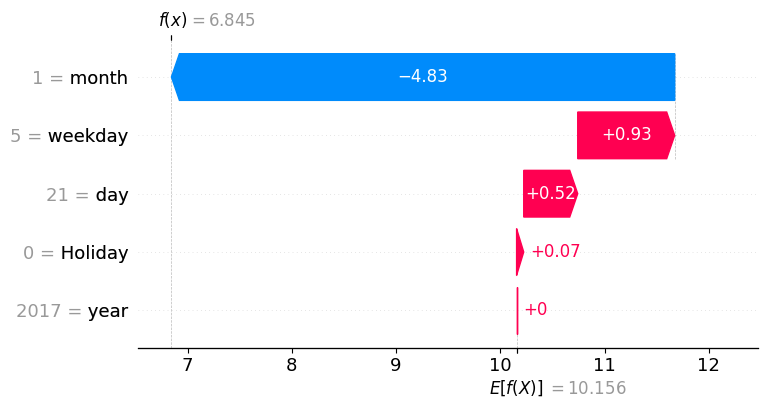

In [34]:
shar_model1(GP)

<<<----------------------------------- Evaluating on SVR Model ----------------------------------->>>



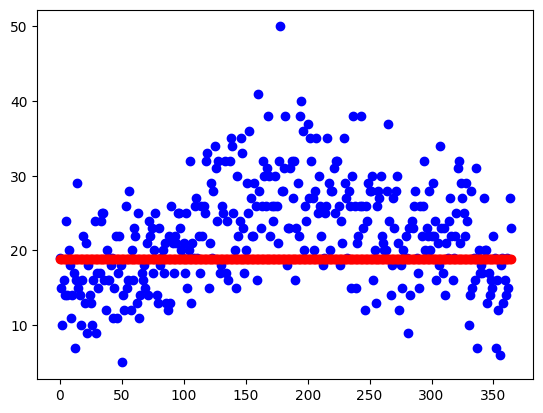

<<<----------------------------------- Training Set ----------------------------------->>>

R2 Score: -0.005942097237520372
Mean square error  43.44598411494295
Root Mean square error 6.591356773452864
<<<----------------------------------- Testing Set ----------------------------------->>>

R2 Score: -0.2229517537658685
Mean square error  58.965377271988395
Root Mean square error 7.678891669504681


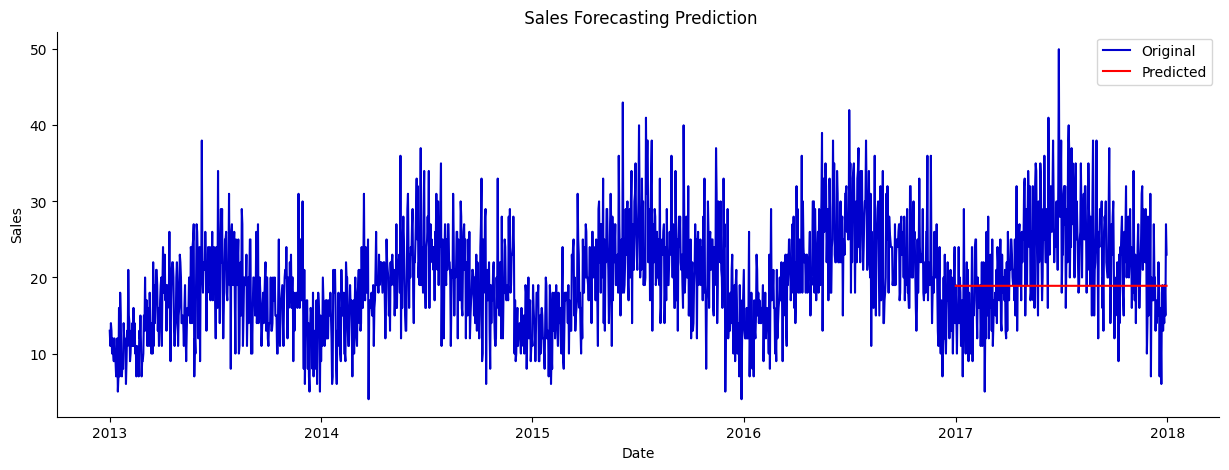

In [35]:
#model
SVR = SVR()

# train the model on the training data
SVR.fit(X_train, y_train)

#predict the traing and testing values
pred1 = SVR.predict(X_train)
pred2 = SVR.predict(X_test)

print('{}{}\033[1m Evaluating on SVR Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)

Evaluate(7, pred1, pred2)

ExactExplainer explainer: 366it [00:37,  6.85it/s]


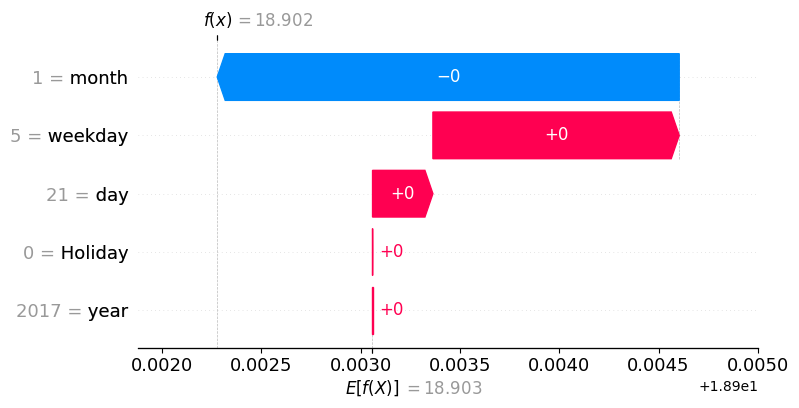

In [36]:
shar_model1(SVR)

<<<----------------------------------- Evaluating on K-NN Model ----------------------------------->>>



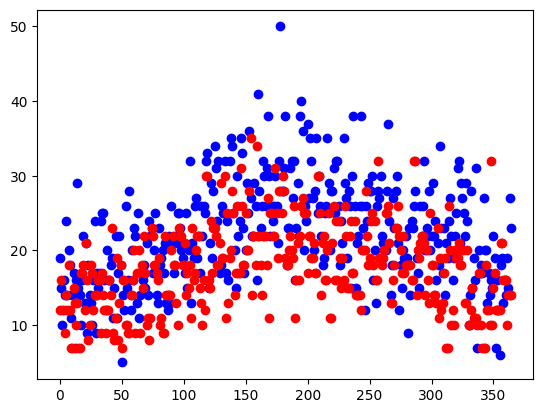

<<<----------------------------------- Training Set ----------------------------------->>>

R2 Score: 0.008155967531420227
Mean square error  42.83709787816564
Root Mean square error 6.54500556746636
<<<----------------------------------- Testing Set ----------------------------------->>>

R2 Score: -0.3111194692759085
Mean square error  63.21643835616438
Root Mean square error 7.950876577847525


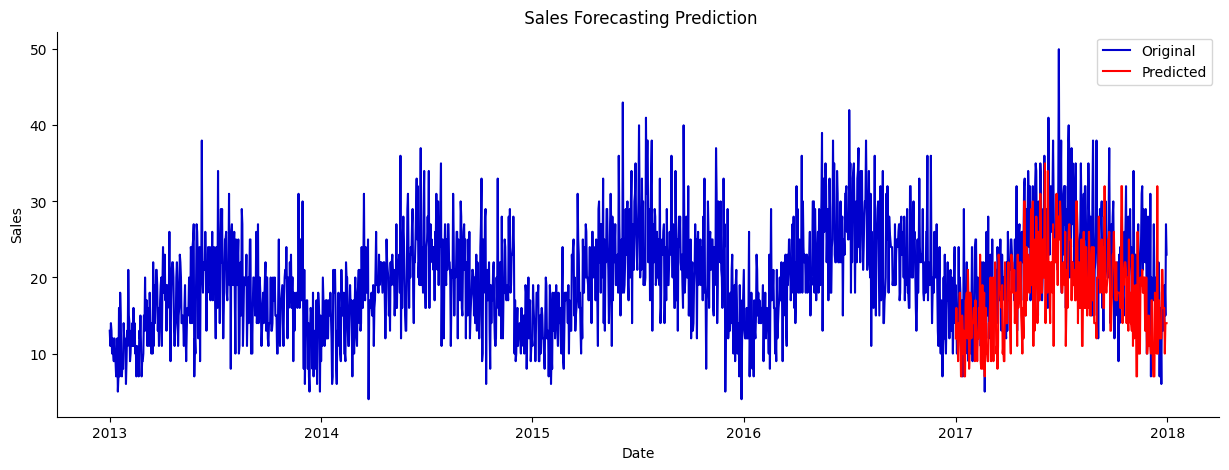

In [37]:
#model
KNN = KNeighborsClassifier()

# train the model on the training data
KNN.fit(X_train, y_train)

#predict the traing and testing values
pred1 = KNN.predict(X_train)
pred2 = KNN.predict(X_test)

print('{}{}\033[1m Evaluating on K-NN Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)

Evaluate(8, pred1, pred2)

ExactExplainer explainer: 366it [00:33,  7.13it/s]                         


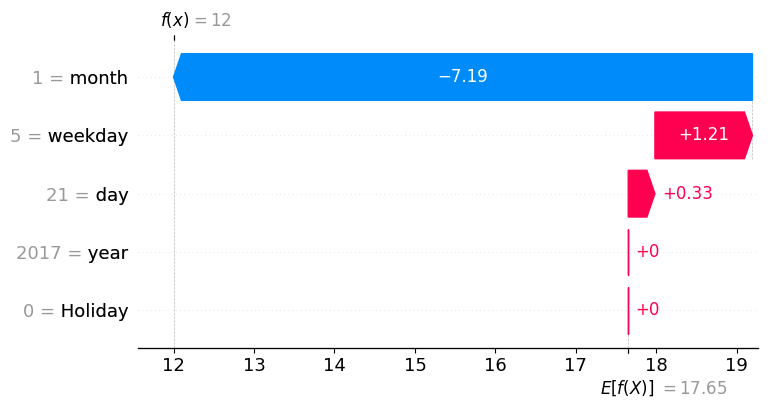

In [38]:
shar_model1(KNN)

<<<----------------------------------- Evaluating on Extra-Tree Model ----------------------------------->>>



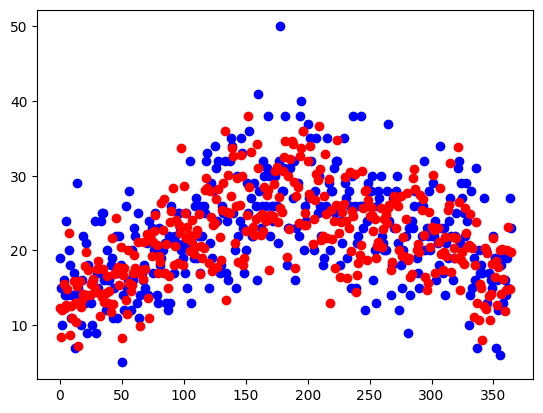

<<<----------------------------------- Training Set ----------------------------------->>>

R2 Score: 1.0
Mean square error  0.0
Root Mean square error 0.0
<<<----------------------------------- Testing Set ----------------------------------->>>

R2 Score: 0.30828437597979674
Mean square error  33.35149780821918
Root Mean square error 5.775075567316776


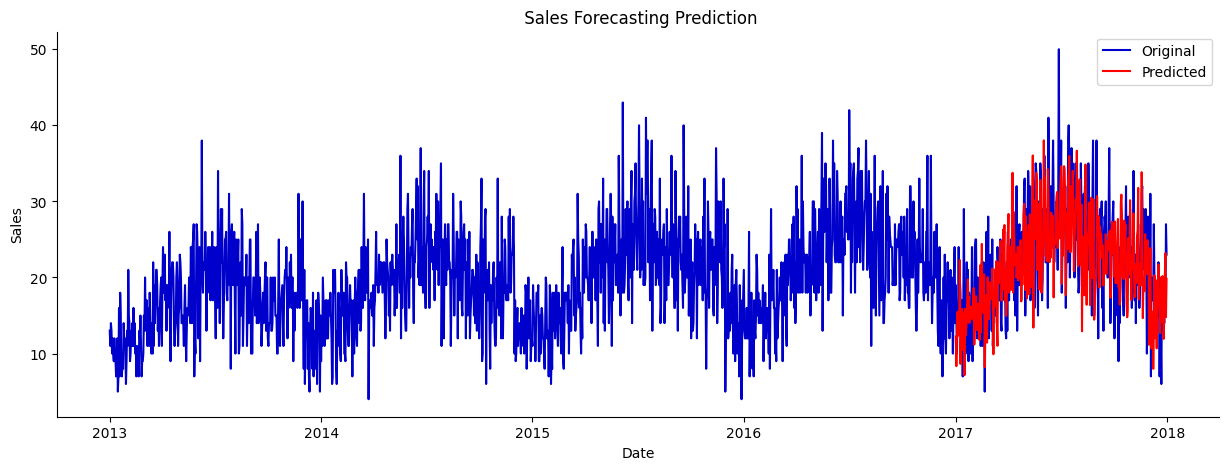

In [39]:
#model
ET = ExtraTreesRegressor()

# train the model on the training data
ET.fit(X_train, y_train)

#predict the traing and testing values
pred1 = ET.predict(X_train)
pred2 = ET.predict(X_test)

print('{}{}\033[1m Evaluating on Extra-Tree Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)

Evaluate(9, pred1, pred2)

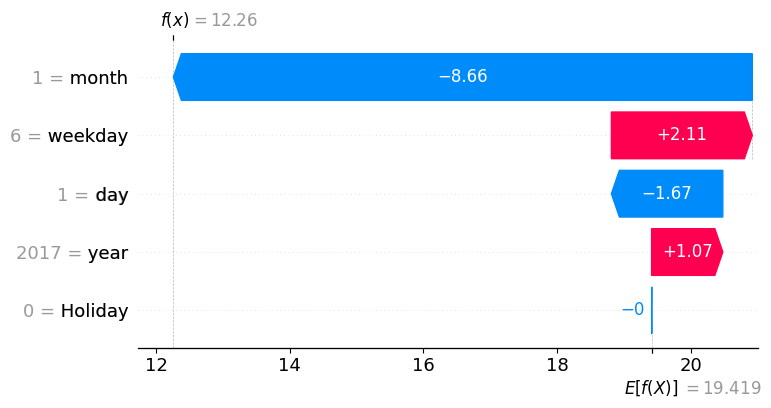

In [40]:
shar_model(ET)

<<<----------------------------------- Evaluating on Adaboost Model ----------------------------------->>>



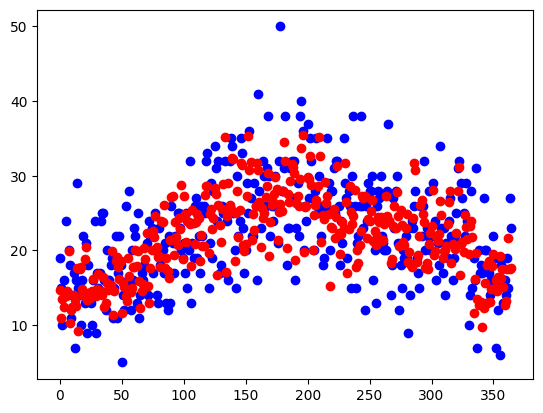

<<<----------------------------------- Training Set ----------------------------------->>>

R2 Score: 0.9602223886611455
Mean square error  1.7179691307323752
Root Mean square error 1.3107132145257312
<<<----------------------------------- Testing Set ----------------------------------->>>

R2 Score: 0.4112206359871511
Mean square error  28.388362191780818
Root Mean square error 5.328073028007482


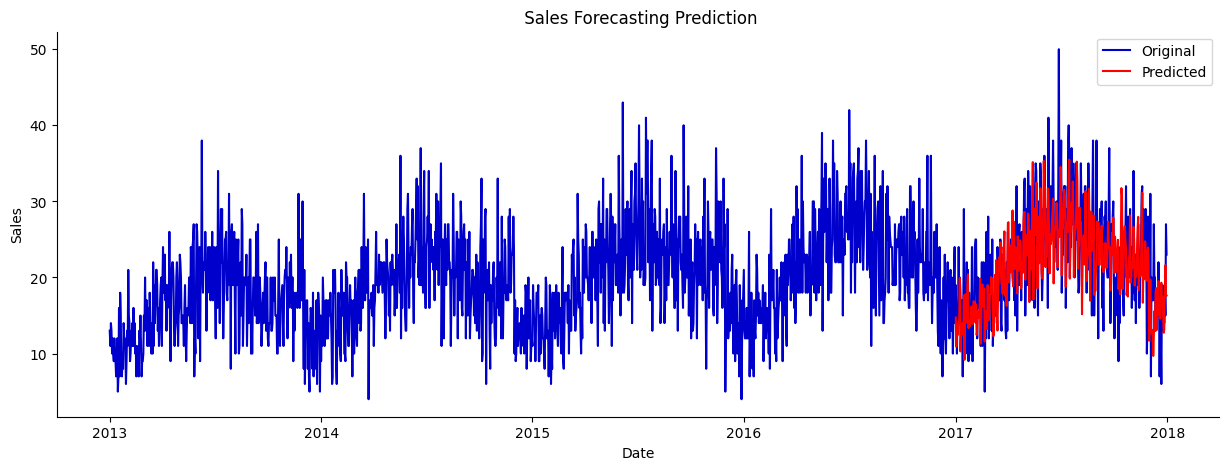

In [41]:
#model
ada = AdaBoostRegressor(base_estimator=RandomForestRegressor(n_estimators=100))

# train the model on the training data
ada.fit(X_train, y_train)

#predict the traing and testing values
pred1 = ada.predict(X_train)
pred2 = ada.predict(X_test)

print('{}{}\033[1m Evaluating on Adaboost Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)

Evaluate(10, pred1, pred2)

ExactExplainer explainer: 366it [06:22,  1.08s/it]


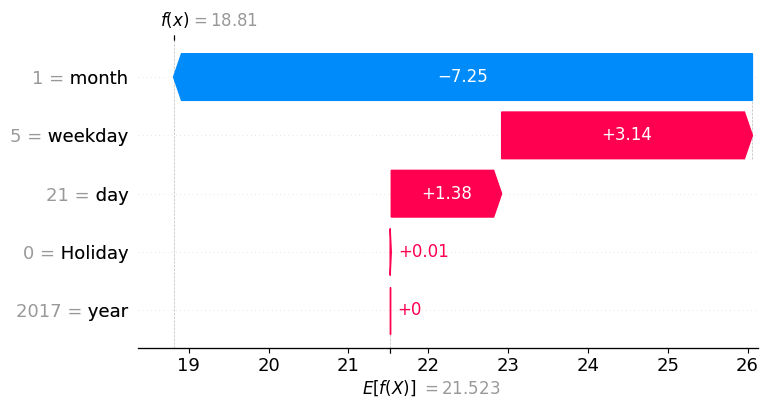

In [42]:
shar_model1(ada)

<<<----------------------------------- Evaluating on LGM Model ----------------------------------->>>



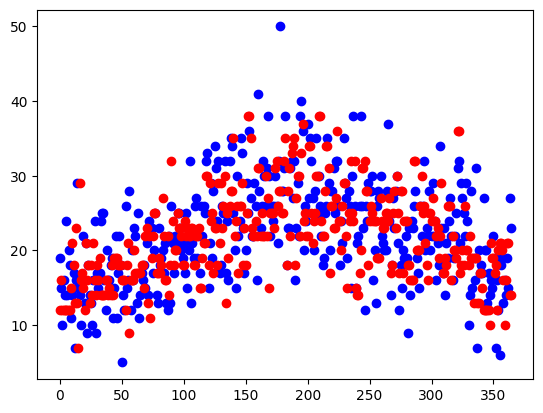

<<<----------------------------------- Training Set ----------------------------------->>>

R2 Score: 1.0
Mean square error  0.0
Root Mean square error 0.0
<<<----------------------------------- Testing Set ----------------------------------->>>

R2 Score: 0.17743930669853292
Mean square error  39.66027397260274
Root Mean square error 6.297640349575604


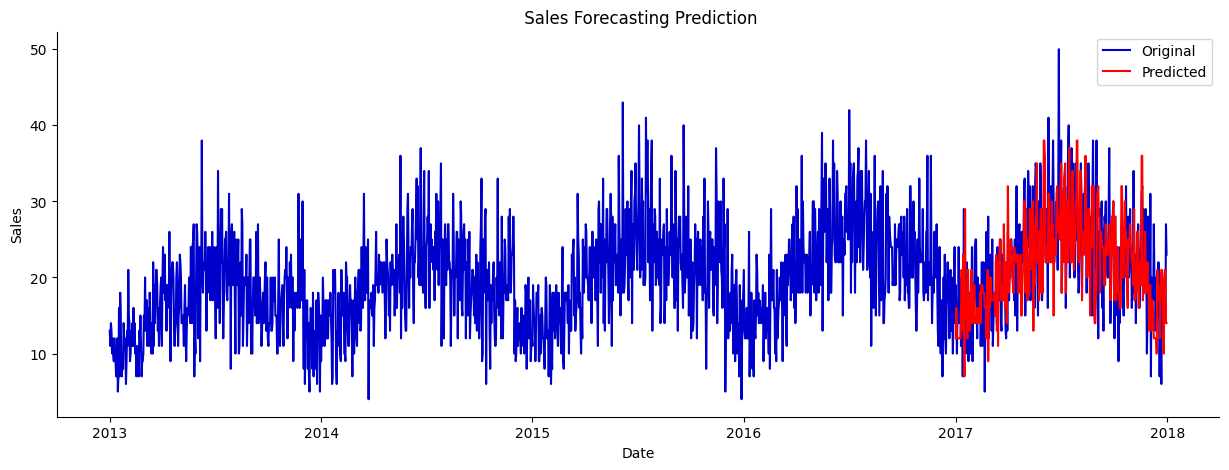

In [43]:
#model
LGB = LGBMClassifier(verbose=-1)

# train the model on the training data
LGB.fit(X_train, y_train)

#predict the traing and testing values
pred1 = LGB.predict(X_train)
pred2 = LGB.predict(X_test)

print('{}{}\033[1m Evaluating on LGM Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)

Evaluate(11, pred1, pred2)

ExactExplainer explainer: 366it [05:23,  1.09it/s]


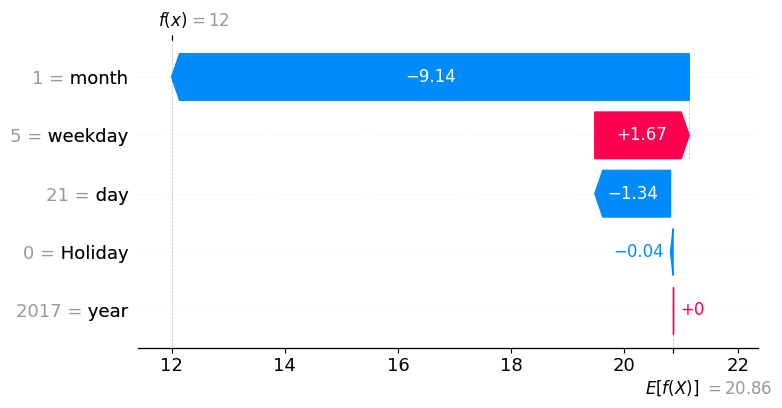

In [44]:
shar_model1(LGB)

Epoch 1/750
46/46 - 4s - loss: 68.5173 - accuracy: 0.0000e+00 - 4s/epoch - 81ms/step
Epoch 2/750
46/46 - 1s - loss: 59.5117 - accuracy: 0.0000e+00 - 1s/epoch - 23ms/step
Epoch 3/750
46/46 - 1s - loss: 55.6509 - accuracy: 0.0000e+00 - 1s/epoch - 23ms/step
Epoch 4/750
46/46 - 1s - loss: 53.2116 - accuracy: 0.0000e+00 - 1s/epoch - 23ms/step
Epoch 5/750
46/46 - 1s - loss: 54.4211 - accuracy: 0.0000e+00 - 1s/epoch - 24ms/step
Epoch 6/750
46/46 - 1s - loss: 53.7574 - accuracy: 0.0000e+00 - 1s/epoch - 24ms/step
Epoch 7/750
46/46 - 1s - loss: 50.9298 - accuracy: 0.0000e+00 - 1s/epoch - 28ms/step
Epoch 8/750
46/46 - 2s - loss: 50.5958 - accuracy: 0.0000e+00 - 2s/epoch - 37ms/step
Epoch 9/750
46/46 - 1s - loss: 52.1798 - accuracy: 0.0000e+00 - 1s/epoch - 32ms/step
Epoch 10/750
46/46 - 1s - loss: 67.8460 - accuracy: 0.0000e+00 - 1s/epoch - 24ms/step
Epoch 11/750
46/46 - 1s - loss: 50.2877 - accuracy: 0.0000e+00 - 1s/epoch - 31ms/step
Epoch 12/750
46/46 - 1s - loss: 52.7671 - accuracy: 0.0000e+00 

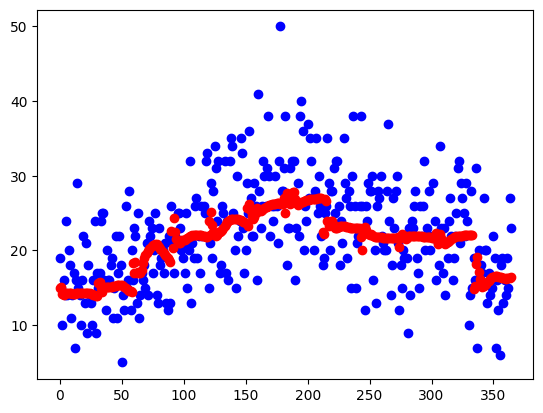

<<<----------------------------------- Training Set ----------------------------------->>>

R2 Score: 0.28643471184261426
Mean square error  30.818420125169958
Root Mean square error 5.551434060237945
<<<----------------------------------- Testing Set ----------------------------------->>>

R2 Score: 0.2933318129085205
Mean square error  34.07244491015187
Root Mean square error 5.83716068908094


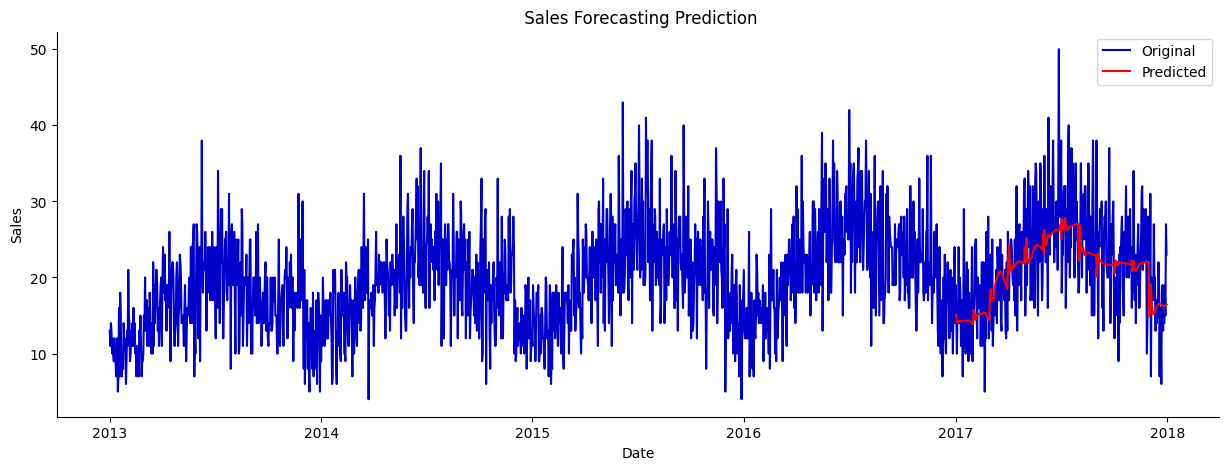

In [45]:
# reshape according to LSTM
Train_X_std1 = X_train.values.reshape(X_train.shape[0], X_train.shape[1],1)
Test_X_std1 = X_test.values.reshape(X_test.shape[0], X_test.shape[1],1)
#model
lstm = Sequential()
lstm.add(LSTM(256, return_sequences = True,activation='relu', input_shape = (Train_X_std1.shape[1],1)))
lstm.add(LSTM(128,activation='relu'))
#model.add(LSTM(64,activation='relu'))
#model.add(LSTM(32,activation='relu'))
#model.add(LSTM(16,activation='relu'))
#model.add(LSTM(8,activation='relu'))
#model.add(LSTM(4,activation='relu'))
#model.add(LSTM(2,activation='relu', input_shape = (Train_X_std1.shape[1],1)))
lstm.add(Dense(1))
lstm.compile(loss = 'mean_squared_error', metrics= ['accuracy'], optimizer = 'adam')
lstm.fit(Train_X_std1, y_train, epochs = 750, batch_size = 32, verbose = 2, shuffle = False)


#predict the traing and testing values
pred1 = lstm.predict(X_train)
pred2 = lstm.predict(X_test)

print('{}{}\033[1m Evaluating on LSTM Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)

Evaluate(12, pred1.reshape(-1), pred2.reshape(-1))

16/16 [==============================] - 0s 13ms/step


ExactExplainer explainer:   4%|▍         | 14/365 [00:00<?, ?it/s]

16/16 [==============================] - 0s 13ms/step


ExactExplainer explainer:   4%|▍         | 16/365 [00:11<02:10,  2.67it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:   5%|▍         | 17/365 [00:12<05:05,  1.14it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:   5%|▍         | 18/365 [00:13<04:28,  1.29it/s]

15/15 [==============================] - 0s 8ms/step


ExactExplainer explainer:   5%|▌         | 19/365 [00:13<04:04,  1.41it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:   5%|▌         | 20/365 [00:14<03:44,  1.54it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:   6%|▌         | 21/365 [00:15<03:45,  1.53it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:   6%|▌         | 22/365 [00:15<03:37,  1.58it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:   6%|▋         | 23/365 [00:16<03:50,  1.48it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:   7%|▋         | 24/365 [00:17<03:32,  1.61it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:   7%|▋         | 25/365 [00:17<03:28,  1.63it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:   7%|▋         | 26/365 [00:18<03:16,  1.73it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:   7%|▋         | 27/365 [00:18<03:08,  1.79it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:   8%|▊         | 28/365 [00:19<03:27,  1.62it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:   8%|▊         | 29/365 [00:20<03:40,  1.52it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:   8%|▊         | 30/365 [00:20<03:50,  1.46it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:   8%|▊         | 31/365 [00:21<03:31,  1.58it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:   9%|▉         | 32/365 [00:21<03:17,  1.69it/s]

15/15 [==============================] - 0s 13ms/step


ExactExplainer explainer:   9%|▉         | 33/365 [00:22<04:09,  1.33it/s]

16/16 [==============================] - 0s 13ms/step


ExactExplainer explainer:   9%|▉         | 34/365 [00:24<04:39,  1.18it/s]

15/15 [==============================] - 0s 13ms/step


ExactExplainer explainer:  10%|▉         | 35/365 [00:24<04:39,  1.18it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  10%|▉         | 36/365 [00:25<04:08,  1.33it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  10%|█         | 37/365 [00:26<03:51,  1.42it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  10%|█         | 38/365 [00:26<03:40,  1.48it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  11%|█         | 39/365 [00:27<03:23,  1.60it/s]

15/15 [==============================] - 0s 8ms/step


ExactExplainer explainer:  11%|█         | 40/365 [00:27<03:12,  1.69it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  11%|█         | 41/365 [00:28<03:01,  1.79it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  12%|█▏        | 42/365 [00:28<03:03,  1.76it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  12%|█▏        | 43/365 [00:29<03:03,  1.75it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  12%|█▏        | 44/365 [00:29<02:57,  1.80it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  12%|█▏        | 45/365 [00:30<02:52,  1.85it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  13%|█▎        | 46/365 [00:30<02:48,  1.89it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  13%|█▎        | 47/365 [00:31<02:46,  1.91it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  13%|█▎        | 48/365 [00:31<02:44,  1.93it/s]

15/15 [==============================] - 0s 8ms/step


ExactExplainer explainer:  13%|█▎        | 49/365 [00:32<02:51,  1.85it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  14%|█▎        | 50/365 [00:33<02:56,  1.78it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  14%|█▍        | 51/365 [00:33<02:52,  1.82it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  14%|█▍        | 52/365 [00:34<03:40,  1.42it/s]

15/15 [==============================] - 0s 13ms/step


ExactExplainer explainer:  15%|█▍        | 53/365 [00:35<03:43,  1.39it/s]

15/15 [==============================] - 0s 14ms/step


ExactExplainer explainer:  15%|█▍        | 54/365 [00:36<04:24,  1.17it/s]

16/16 [==============================] - 0s 13ms/step


ExactExplainer explainer:  15%|█▌        | 55/365 [00:37<04:51,  1.07it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  15%|█▌        | 56/365 [00:38<04:17,  1.20it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  16%|█▌        | 57/365 [00:38<03:48,  1.35it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  16%|█▌        | 58/365 [00:39<03:42,  1.38it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  16%|█▌        | 59/365 [00:40<03:29,  1.46it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  16%|█▋        | 60/365 [00:40<03:11,  1.59it/s]

15/15 [==============================] - 0s 8ms/step


ExactExplainer explainer:  17%|█▋        | 61/365 [00:41<03:00,  1.68it/s]

15/15 [==============================] - 0s 8ms/step


ExactExplainer explainer:  17%|█▋        | 62/365 [00:41<02:50,  1.78it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  17%|█▋        | 63/365 [00:42<02:54,  1.73it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  18%|█▊        | 64/365 [00:42<03:10,  1.58it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  18%|█▊        | 65/365 [00:43<03:06,  1.61it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  18%|█▊        | 66/365 [00:44<03:17,  1.51it/s]

15/15 [==============================] - 0s 8ms/step


ExactExplainer explainer:  18%|█▊        | 67/365 [00:44<03:03,  1.62it/s]

15/15 [==============================] - 0s 8ms/step


ExactExplainer explainer:  19%|█▊        | 68/365 [00:45<03:02,  1.63it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  19%|█▉        | 69/365 [00:46<03:05,  1.60it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  19%|█▉        | 70/365 [00:46<03:15,  1.51it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  19%|█▉        | 71/365 [00:47<03:10,  1.54it/s]

16/16 [==============================] - 0s 13ms/step


ExactExplainer explainer:  20%|█▉        | 72/365 [00:48<03:16,  1.49it/s]

15/15 [==============================] - 0s 13ms/step


ExactExplainer explainer:  20%|██        | 73/365 [00:49<03:57,  1.23it/s]

16/16 [==============================] - 0s 14ms/step


ExactExplainer explainer:  20%|██        | 74/365 [00:50<03:59,  1.21it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  21%|██        | 75/365 [00:50<03:47,  1.27it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  21%|██        | 76/365 [00:51<03:37,  1.33it/s]

15/15 [==============================] - 0s 11ms/step


ExactExplainer explainer:  21%|██        | 77/365 [00:52<03:36,  1.33it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  21%|██▏       | 78/365 [00:53<03:36,  1.33it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  22%|██▏       | 79/365 [00:53<03:22,  1.42it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  22%|██▏       | 80/365 [00:54<03:03,  1.55it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  22%|██▏       | 81/365 [00:54<02:51,  1.65it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  22%|██▏       | 82/365 [00:55<03:04,  1.54it/s]

15/15 [==============================] - 0s 8ms/step


ExactExplainer explainer:  23%|██▎       | 83/365 [00:56<02:58,  1.58it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  23%|██▎       | 84/365 [00:56<02:54,  1.61it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  23%|██▎       | 85/365 [00:57<02:44,  1.70it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  24%|██▎       | 86/365 [00:57<02:58,  1.56it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  24%|██▍       | 87/365 [00:58<02:59,  1.55it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  24%|██▍       | 88/365 [00:59<02:54,  1.59it/s]

15/15 [==============================] - 0s 8ms/step


ExactExplainer explainer:  24%|██▍       | 89/365 [00:59<02:46,  1.66it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  25%|██▍       | 90/365 [01:00<02:46,  1.65it/s]

15/15 [==============================] - 0s 12ms/step


ExactExplainer explainer:  25%|██▍       | 91/365 [01:00<02:42,  1.69it/s]

16/16 [==============================] - 0s 13ms/step


ExactExplainer explainer:  25%|██▌       | 92/365 [01:01<03:05,  1.47it/s]

16/16 [==============================] - 0s 11ms/step


ExactExplainer explainer:  25%|██▌       | 93/365 [01:02<03:41,  1.23it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  26%|██▌       | 94/365 [01:03<04:06,  1.10it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  26%|██▌       | 95/365 [01:04<03:48,  1.18it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  26%|██▋       | 96/365 [01:05<03:31,  1.27it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  27%|██▋       | 97/365 [01:06<03:22,  1.32it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  27%|██▋       | 98/365 [01:06<03:10,  1.40it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  27%|██▋       | 99/365 [01:07<02:52,  1.54it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  27%|██▋       | 100/365 [01:07<02:48,  1.57it/s]

15/15 [==============================] - 0s 8ms/step


ExactExplainer explainer:  28%|██▊       | 101/365 [01:08<02:43,  1.61it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  28%|██▊       | 102/365 [01:08<02:34,  1.70it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  28%|██▊       | 103/365 [01:09<02:33,  1.70it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  28%|██▊       | 104/365 [01:10<02:42,  1.61it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  29%|██▉       | 105/365 [01:10<02:45,  1.57it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  29%|██▉       | 106/365 [01:11<02:42,  1.59it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  29%|██▉       | 107/365 [01:12<02:52,  1.50it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  30%|██▉       | 108/365 [01:12<02:53,  1.48it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  30%|██▉       | 109/365 [01:13<02:58,  1.43it/s]

15/15 [==============================] - 0s 14ms/step


ExactExplainer explainer:  30%|███       | 110/365 [01:14<03:02,  1.40it/s]

16/16 [==============================] - 0s 12ms/step


ExactExplainer explainer:  30%|███       | 111/365 [01:15<03:25,  1.24it/s]

16/16 [==============================] - 0s 12ms/step


ExactExplainer explainer:  31%|███       | 112/365 [01:16<03:49,  1.10it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  31%|███       | 113/365 [01:17<03:27,  1.22it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  31%|███       | 114/365 [01:17<03:03,  1.37it/s]

15/15 [==============================] - 0s 8ms/step


ExactExplainer explainer:  32%|███▏      | 115/365 [01:18<02:52,  1.45it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  32%|███▏      | 116/365 [01:19<02:56,  1.41it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  32%|███▏      | 117/365 [01:19<02:59,  1.38it/s]

15/15 [==============================] - 0s 8ms/step


ExactExplainer explainer:  32%|███▏      | 118/365 [01:20<02:42,  1.52it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  33%|███▎      | 119/365 [01:20<02:43,  1.50it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  33%|███▎      | 120/365 [01:21<02:43,  1.49it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  33%|███▎      | 121/365 [01:22<02:45,  1.47it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  33%|███▎      | 122/365 [01:23<02:50,  1.42it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  34%|███▎      | 123/365 [01:23<02:47,  1.45it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  34%|███▍      | 124/365 [01:24<02:51,  1.41it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  34%|███▍      | 125/365 [01:25<02:54,  1.38it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  35%|███▍      | 126/365 [01:25<02:39,  1.50it/s]

16/16 [==============================] - 0s 13ms/step


ExactExplainer explainer:  35%|███▍      | 127/365 [01:27<03:24,  1.17it/s]

16/16 [==============================] - 0s 13ms/step


ExactExplainer explainer:  35%|███▌      | 128/365 [01:27<03:17,  1.20it/s]

15/15 [==============================] - 0s 14ms/step


ExactExplainer explainer:  35%|███▌      | 129/365 [01:28<03:32,  1.11it/s]

15/15 [==============================] - 0s 14ms/step


ExactExplainer explainer:  36%|███▌      | 130/365 [01:29<03:28,  1.13it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  36%|███▌      | 131/365 [01:30<03:19,  1.17it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  36%|███▌      | 132/365 [01:31<03:00,  1.29it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  36%|███▋      | 133/365 [01:31<02:58,  1.30it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  37%|███▋      | 134/365 [01:32<02:57,  1.30it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  37%|███▋      | 135/365 [01:33<02:50,  1.35it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  37%|███▋      | 136/365 [01:33<02:40,  1.43it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  38%|███▊      | 137/365 [01:34<02:27,  1.55it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  38%|███▊      | 138/365 [01:35<02:17,  1.65it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  38%|███▊      | 139/365 [01:35<02:17,  1.64it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  38%|███▊      | 140/365 [01:36<02:28,  1.52it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  39%|███▊      | 141/365 [01:37<02:34,  1.45it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  39%|███▉      | 142/365 [01:37<02:34,  1.45it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  39%|███▉      | 143/365 [01:38<02:39,  1.40it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  39%|███▉      | 144/365 [01:39<02:30,  1.47it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  40%|███▉      | 145/365 [01:39<02:26,  1.51it/s]

16/16 [==============================] - 0s 13ms/step


ExactExplainer explainer:  40%|████      | 146/365 [01:40<02:33,  1.43it/s]

16/16 [==============================] - 0s 14ms/step


ExactExplainer explainer:  40%|████      | 147/365 [01:41<02:43,  1.33it/s]

16/16 [==============================] - 0s 13ms/step


ExactExplainer explainer:  41%|████      | 148/365 [01:42<02:42,  1.34it/s]

16/16 [==============================] - 0s 12ms/step


ExactExplainer explainer:  41%|████      | 149/365 [01:43<02:42,  1.33it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  41%|████      | 150/365 [01:43<02:47,  1.29it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  41%|████▏     | 151/365 [01:44<02:30,  1.42it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  42%|████▏     | 152/365 [01:44<02:22,  1.50it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  42%|████▏     | 153/365 [01:45<02:11,  1.61it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  42%|████▏     | 154/365 [01:46<02:09,  1.64it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  42%|████▏     | 155/365 [01:46<02:03,  1.70it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  43%|████▎     | 156/365 [01:47<02:04,  1.68it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  43%|████▎     | 157/365 [01:47<02:08,  1.62it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  43%|████▎     | 158/365 [01:48<02:11,  1.58it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  44%|████▎     | 159/365 [01:49<02:13,  1.55it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  44%|████▍     | 160/365 [01:49<02:15,  1.52it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  44%|████▍     | 161/365 [01:50<02:15,  1.50it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  44%|████▍     | 162/365 [01:51<02:21,  1.44it/s]

16/16 [==============================] - 0s 10ms/step


ExactExplainer explainer:  45%|████▍     | 163/365 [01:52<02:24,  1.40it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  45%|████▍     | 164/365 [01:52<02:16,  1.47it/s]

15/15 [==============================] - 0s 11ms/step


ExactExplainer explainer:  45%|████▌     | 165/365 [01:53<02:14,  1.49it/s]

15/15 [==============================] - 0s 13ms/step


ExactExplainer explainer:  45%|████▌     | 166/365 [01:54<02:24,  1.38it/s]

16/16 [==============================] - 0s 12ms/step


ExactExplainer explainer:  46%|████▌     | 167/365 [01:54<02:24,  1.37it/s]

15/15 [==============================] - 0s 12ms/step


ExactExplainer explainer:  46%|████▌     | 168/365 [01:55<02:23,  1.38it/s]

16/16 [==============================] - 0s 13ms/step


ExactExplainer explainer:  46%|████▋     | 169/365 [01:56<02:30,  1.31it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  47%|████▋     | 170/365 [01:57<02:20,  1.39it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  47%|████▋     | 171/365 [01:57<02:17,  1.41it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  47%|████▋     | 172/365 [01:58<02:05,  1.54it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  47%|████▋     | 173/365 [01:58<01:56,  1.64it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  48%|████▊     | 174/365 [01:59<01:56,  1.64it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  48%|████▊     | 175/365 [02:00<01:59,  1.59it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  48%|████▊     | 176/365 [02:00<01:57,  1.60it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  48%|████▊     | 177/365 [02:01<02:00,  1.56it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  49%|████▉     | 178/365 [02:02<01:58,  1.58it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  49%|████▉     | 179/365 [02:02<01:56,  1.60it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  49%|████▉     | 180/365 [02:03<01:50,  1.68it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  50%|████▉     | 181/365 [02:03<01:56,  1.58it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  50%|████▉     | 182/365 [02:04<02:02,  1.49it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  50%|█████     | 183/365 [02:05<02:03,  1.47it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  50%|█████     | 184/365 [02:06<02:07,  1.42it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  51%|█████     | 185/365 [02:06<01:58,  1.52it/s]

16/16 [==============================] - 0s 13ms/step


ExactExplainer explainer:  51%|█████     | 186/365 [02:08<02:52,  1.04it/s]

15/15 [==============================] - 0s 15ms/step


ExactExplainer explainer:  51%|█████     | 187/365 [02:09<02:47,  1.06it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  52%|█████▏    | 188/365 [02:10<02:44,  1.08it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  52%|█████▏    | 189/365 [02:10<02:26,  1.20it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  52%|█████▏    | 190/365 [02:11<02:18,  1.26it/s]

16/16 [==============================] - 0s 11ms/step


ExactExplainer explainer:  52%|█████▏    | 191/365 [02:12<02:17,  1.26it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  53%|█████▎    | 192/365 [02:12<02:03,  1.40it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  53%|█████▎    | 193/365 [02:13<01:56,  1.47it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  53%|█████▎    | 194/365 [02:13<01:52,  1.52it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  53%|█████▎    | 195/365 [02:14<01:45,  1.61it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  54%|█████▎    | 196/365 [02:15<01:45,  1.61it/s]

16/16 [==============================] - 0s 10ms/step


ExactExplainer explainer:  54%|█████▍    | 197/365 [02:15<01:44,  1.61it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  54%|█████▍    | 198/365 [02:16<01:39,  1.68it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  55%|█████▍    | 199/365 [02:16<01:39,  1.67it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  55%|█████▍    | 200/365 [02:17<01:39,  1.66it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  55%|█████▌    | 201/365 [02:18<01:36,  1.70it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  55%|█████▌    | 202/365 [02:18<01:44,  1.56it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  56%|█████▌    | 203/365 [02:19<01:49,  1.49it/s]

16/16 [==============================] - 0s 13ms/step


ExactExplainer explainer:  56%|█████▌    | 204/365 [02:20<01:53,  1.41it/s]

16/16 [==============================] - 0s 12ms/step


ExactExplainer explainer:  56%|█████▌    | 205/365 [02:21<02:00,  1.32it/s]

15/15 [==============================] - 0s 14ms/step


ExactExplainer explainer:  56%|█████▋    | 206/365 [02:22<02:19,  1.14it/s]

16/16 [==============================] - 0s 10ms/step


ExactExplainer explainer:  57%|█████▋    | 207/365 [02:23<02:10,  1.21it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  57%|█████▋    | 208/365 [02:23<01:55,  1.36it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  57%|█████▋    | 209/365 [02:24<01:55,  1.35it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  58%|█████▊    | 210/365 [02:24<01:48,  1.43it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  58%|█████▊    | 211/365 [02:25<01:47,  1.43it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  58%|█████▊    | 212/365 [02:26<01:47,  1.43it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  58%|█████▊    | 213/365 [02:27<01:45,  1.44it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  59%|█████▊    | 214/365 [02:27<01:44,  1.44it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  59%|█████▉    | 215/365 [02:28<01:36,  1.55it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  59%|█████▉    | 216/365 [02:28<01:30,  1.65it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  59%|█████▉    | 217/365 [02:29<01:33,  1.58it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  60%|█████▉    | 218/365 [02:30<01:28,  1.66it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  60%|██████    | 219/365 [02:30<01:33,  1.56it/s]

15/15 [==============================] - 0s 11ms/step


ExactExplainer explainer:  60%|██████    | 220/365 [02:31<01:28,  1.63it/s]

15/15 [==============================] - 0s 8ms/step


ExactExplainer explainer:  61%|██████    | 221/365 [02:31<01:27,  1.65it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  61%|██████    | 222/365 [02:32<01:23,  1.72it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  61%|██████    | 223/365 [02:33<01:26,  1.64it/s]

16/16 [==============================] - 0s 13ms/step


ExactExplainer explainer:  61%|██████▏   | 224/365 [02:34<01:48,  1.31it/s]

16/16 [==============================] - 0s 13ms/step


ExactExplainer explainer:  62%|██████▏   | 225/365 [02:35<02:03,  1.13it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  62%|██████▏   | 226/365 [02:36<02:12,  1.05it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  62%|██████▏   | 227/365 [02:37<01:59,  1.15it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  62%|██████▏   | 228/365 [02:37<01:54,  1.19it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  63%|██████▎   | 229/365 [02:38<01:47,  1.26it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  63%|██████▎   | 230/365 [02:39<01:35,  1.41it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  63%|██████▎   | 231/365 [02:39<01:34,  1.42it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  64%|██████▎   | 232/365 [02:40<01:36,  1.38it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  64%|██████▍   | 233/365 [02:41<01:28,  1.50it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  64%|██████▍   | 234/365 [02:41<01:30,  1.44it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  64%|██████▍   | 235/365 [02:42<01:23,  1.55it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  65%|██████▍   | 236/365 [02:43<01:27,  1.47it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  65%|██████▍   | 237/365 [02:43<01:21,  1.58it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  65%|██████▌   | 238/365 [02:44<01:16,  1.67it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  65%|██████▌   | 239/365 [02:44<01:19,  1.59it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  66%|██████▌   | 240/365 [02:45<01:23,  1.50it/s]

15/15 [==============================] - 0s 14ms/step


ExactExplainer explainer:  66%|██████▌   | 241/365 [02:46<01:39,  1.25it/s]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  66%|██████▋   | 242/365 [02:47<01:49,  1.12it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  67%|██████▋   | 243/365 [02:48<01:51,  1.09it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  67%|██████▋   | 244/365 [02:49<01:41,  1.19it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  67%|██████▋   | 245/365 [02:50<01:37,  1.23it/s]

16/16 [==============================] - 0s 10ms/step


ExactExplainer explainer:  67%|██████▋   | 246/365 [02:51<01:35,  1.25it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  68%|██████▊   | 247/365 [02:51<01:25,  1.39it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  68%|██████▊   | 248/365 [02:52<01:36,  1.21it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  68%|██████▊   | 249/365 [02:53<01:26,  1.34it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  68%|██████▊   | 250/365 [02:53<01:26,  1.33it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  69%|██████▉   | 251/365 [02:54<01:25,  1.33it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  69%|██████▉   | 252/365 [02:55<01:17,  1.45it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  69%|██████▉   | 253/365 [02:55<01:16,  1.46it/s]

16/16 [==============================] - 0s 10ms/step


ExactExplainer explainer:  70%|██████▉   | 254/365 [02:56<01:15,  1.47it/s]

16/16 [==============================] - 0s 10ms/step


ExactExplainer explainer:  70%|██████▉   | 255/365 [02:57<01:13,  1.50it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  70%|███████   | 256/365 [02:57<01:13,  1.49it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  70%|███████   | 257/365 [02:58<01:15,  1.43it/s]

16/16 [==============================] - 0s 13ms/step


ExactExplainer explainer:  71%|███████   | 258/365 [02:59<01:28,  1.21it/s]

16/16 [==============================] - 0s 12ms/step


ExactExplainer explainer:  71%|███████   | 259/365 [03:00<01:37,  1.08it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  71%|███████   | 260/365 [03:02<01:43,  1.01it/s]

16/16 [==============================] - 0s 10ms/step


ExactExplainer explainer:  72%|███████▏  | 261/365 [03:02<01:31,  1.13it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  72%|███████▏  | 262/365 [03:03<01:27,  1.18it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  72%|███████▏  | 263/365 [03:04<01:23,  1.22it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  72%|███████▏  | 264/365 [03:04<01:19,  1.28it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  73%|███████▎  | 265/365 [03:05<01:13,  1.36it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  73%|███████▎  | 266/365 [03:06<01:06,  1.49it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  73%|███████▎  | 267/365 [03:06<01:06,  1.48it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  73%|███████▎  | 268/365 [03:07<01:08,  1.42it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  74%|███████▎  | 269/365 [03:08<01:09,  1.39it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  74%|███████▍  | 270/365 [03:08<01:05,  1.46it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  74%|███████▍  | 271/365 [03:09<01:02,  1.51it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  75%|███████▍  | 272/365 [03:10<01:04,  1.44it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  75%|███████▍  | 273/365 [03:11<01:06,  1.39it/s]

16/16 [==============================] - 0s 14ms/step


ExactExplainer explainer:  75%|███████▌  | 274/365 [03:11<01:07,  1.35it/s]

16/16 [==============================] - 0s 13ms/step


ExactExplainer explainer:  75%|███████▌  | 275/365 [03:12<01:08,  1.32it/s]

15/15 [==============================] - 0s 15ms/step


ExactExplainer explainer:  76%|███████▌  | 276/365 [03:13<01:16,  1.16it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  76%|███████▌  | 277/365 [03:14<01:19,  1.10it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  76%|███████▌  | 278/365 [03:15<01:11,  1.22it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  76%|███████▋  | 279/365 [03:16<01:07,  1.28it/s]

16/16 [==============================] - 0s 10ms/step


ExactExplainer explainer:  77%|███████▋  | 280/365 [03:16<01:03,  1.34it/s]

16/16 [==============================] - 0s 18ms/step


ExactExplainer explainer:  77%|███████▋  | 281/365 [03:17<01:12,  1.16it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  77%|███████▋  | 282/365 [03:18<01:06,  1.25it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  78%|███████▊  | 283/365 [03:19<01:08,  1.20it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  78%|███████▊  | 284/365 [03:19<01:00,  1.34it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  78%|███████▊  | 285/365 [03:20<00:54,  1.48it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  78%|███████▊  | 286/365 [03:21<00:52,  1.51it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  79%|███████▊  | 287/365 [03:21<00:53,  1.45it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  79%|███████▉  | 288/365 [03:22<00:51,  1.50it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  79%|███████▉  | 289/365 [03:23<00:47,  1.59it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  79%|███████▉  | 290/365 [03:23<00:44,  1.67it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  80%|███████▉  | 291/365 [03:24<00:48,  1.53it/s]

15/15 [==============================] - 0s 12ms/step


ExactExplainer explainer:  80%|████████  | 292/365 [03:24<00:46,  1.55it/s]

16/16 [==============================] - 0s 13ms/step


ExactExplainer explainer:  80%|████████  | 293/365 [03:25<00:48,  1.48it/s]

16/16 [==============================] - 0s 13ms/step


ExactExplainer explainer:  81%|████████  | 294/365 [03:26<00:51,  1.37it/s]

16/16 [==============================] - 0s 13ms/step


ExactExplainer explainer:  81%|████████  | 295/365 [03:27<01:00,  1.16it/s]

16/16 [==============================] - 0s 10ms/step


ExactExplainer explainer:  81%|████████  | 296/365 [03:28<00:58,  1.18it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  81%|████████▏ | 297/365 [03:29<00:50,  1.34it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  82%|████████▏ | 298/365 [03:29<00:45,  1.46it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  82%|████████▏ | 299/365 [03:30<00:46,  1.42it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  82%|████████▏ | 300/365 [03:30<00:42,  1.53it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  82%|████████▏ | 301/365 [03:31<00:43,  1.45it/s]

16/16 [==============================] - 0s 10ms/step


ExactExplainer explainer:  83%|████████▎ | 302/365 [03:32<00:40,  1.55it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  83%|████████▎ | 303/365 [03:32<00:39,  1.57it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  83%|████████▎ | 304/365 [03:33<00:41,  1.48it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  84%|████████▎ | 305/365 [03:34<00:41,  1.43it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  84%|████████▍ | 306/365 [03:34<00:39,  1.49it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  84%|████████▍ | 307/365 [03:35<00:37,  1.53it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  84%|████████▍ | 308/365 [03:36<00:36,  1.57it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  85%|████████▍ | 309/365 [03:36<00:37,  1.51it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  85%|████████▍ | 310/365 [03:37<00:38,  1.44it/s]

15/15 [==============================] - 0s 13ms/step


ExactExplainer explainer:  85%|████████▌ | 311/365 [03:38<00:37,  1.46it/s]

15/15 [==============================] - 0s 13ms/step


ExactExplainer explainer:  85%|████████▌ | 312/365 [03:39<00:42,  1.24it/s]

15/15 [==============================] - 0s 13ms/step


ExactExplainer explainer:  86%|████████▌ | 313/365 [03:40<00:41,  1.26it/s]

15/15 [==============================] - 0s 14ms/step


ExactExplainer explainer:  86%|████████▌ | 314/365 [03:41<00:41,  1.22it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  86%|████████▋ | 315/365 [03:41<00:42,  1.16it/s]

16/16 [==============================] - 0s 13ms/step


ExactExplainer explainer:  87%|████████▋ | 316/365 [03:42<00:40,  1.21it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  87%|████████▋ | 317/365 [03:43<00:37,  1.29it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  87%|████████▋ | 318/365 [03:44<00:36,  1.30it/s]

15/15 [==============================] - 0s 11ms/step


ExactExplainer explainer:  87%|████████▋ | 319/365 [03:44<00:32,  1.43it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  88%|████████▊ | 320/365 [03:45<00:31,  1.45it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  88%|████████▊ | 321/365 [03:45<00:28,  1.56it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  88%|████████▊ | 322/365 [03:46<00:26,  1.63it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  88%|████████▊ | 323/365 [03:47<00:25,  1.63it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  89%|████████▉ | 324/365 [03:47<00:26,  1.52it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  89%|████████▉ | 325/365 [03:48<00:27,  1.46it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  89%|████████▉ | 326/365 [03:49<00:25,  1.52it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  90%|████████▉ | 327/365 [03:49<00:25,  1.49it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  90%|████████▉ | 328/365 [03:50<00:27,  1.35it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  90%|█████████ | 329/365 [03:51<00:25,  1.43it/s]

16/16 [==============================] - 0s 15ms/step


ExactExplainer explainer:  90%|█████████ | 330/365 [03:52<00:29,  1.20it/s]

16/16 [==============================] - 0s 12ms/step


ExactExplainer explainer:  91%|█████████ | 331/365 [03:53<00:31,  1.07it/s]

15/15 [==============================] - 0s 15ms/step


ExactExplainer explainer:  91%|█████████ | 332/365 [03:54<00:29,  1.12it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  91%|█████████ | 333/365 [03:54<00:25,  1.28it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  92%|█████████▏| 334/365 [03:55<00:22,  1.38it/s]

16/16 [==============================] - 0s 10ms/step


ExactExplainer explainer:  92%|█████████▏| 335/365 [03:56<00:20,  1.49it/s]

16/16 [==============================] - 0s 10ms/step


ExactExplainer explainer:  92%|█████████▏| 336/365 [03:56<00:20,  1.43it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  92%|█████████▏| 337/365 [03:57<00:19,  1.43it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  93%|█████████▎| 338/365 [03:58<00:18,  1.44it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  93%|█████████▎| 339/365 [03:58<00:16,  1.54it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  93%|█████████▎| 340/365 [03:59<00:15,  1.61it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  93%|█████████▎| 341/365 [03:59<00:14,  1.63it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  94%|█████████▎| 342/365 [04:00<00:15,  1.52it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  94%|█████████▍| 343/365 [04:01<00:14,  1.54it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  94%|█████████▍| 344/365 [04:01<00:13,  1.57it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  95%|█████████▍| 345/365 [04:02<00:12,  1.58it/s]

16/16 [==============================] - 0s 10ms/step


ExactExplainer explainer:  95%|█████████▍| 346/365 [04:03<00:11,  1.58it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  95%|█████████▌| 347/365 [04:03<00:12,  1.49it/s]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  95%|█████████▌| 348/365 [04:04<00:11,  1.44it/s]

16/16 [==============================] - 0s 13ms/step


ExactExplainer explainer:  96%|█████████▌| 349/365 [04:05<00:12,  1.33it/s]

16/16 [==============================] - 0s 13ms/step


ExactExplainer explainer:  96%|█████████▌| 350/365 [04:06<00:13,  1.14it/s]

16/16 [==============================] - 0s 12ms/step


ExactExplainer explainer:  96%|█████████▌| 351/365 [04:07<00:12,  1.14it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  96%|█████████▋| 352/365 [04:08<00:10,  1.23it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  97%|█████████▋| 353/365 [04:09<00:09,  1.28it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  97%|█████████▋| 354/365 [04:09<00:08,  1.29it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  97%|█████████▋| 355/365 [04:10<00:07,  1.30it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  98%|█████████▊| 356/365 [04:11<00:06,  1.34it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  98%|█████████▊| 357/365 [04:11<00:05,  1.38it/s]

16/16 [==============================] - 0s 10ms/step


ExactExplainer explainer:  98%|█████████▊| 358/365 [04:12<00:04,  1.43it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  98%|█████████▊| 359/365 [04:13<00:04,  1.49it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  99%|█████████▊| 360/365 [04:14<00:03,  1.34it/s]

16/16 [==============================] - 0s 10ms/step


ExactExplainer explainer:  99%|█████████▉| 361/365 [04:14<00:03,  1.33it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  99%|█████████▉| 362/365 [04:15<00:02,  1.32it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  99%|█████████▉| 363/365 [04:16<00:01,  1.44it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer: 100%|█████████▉| 364/365 [04:16<00:00,  1.43it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer: 100%|██████████| 365/365 [04:17<00:00,  1.42it/s]

16/16 [==============================] - 0s 15ms/step


ExactExplainer explainer: 366it [04:18,  1.36it/s]


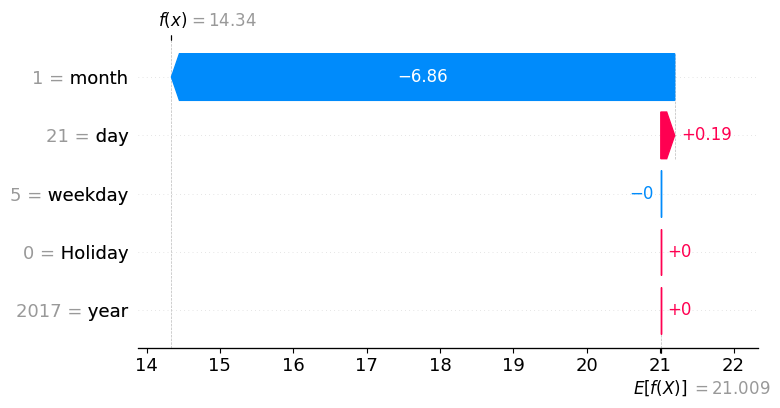

In [46]:
shar_model1(lstm)

Epoch 1/750
46/46 - 7s - loss: 224.6705 - accuracy: 0.0000e+00 - 7s/epoch - 141ms/step
Epoch 2/750
46/46 - 1s - loss: 109.2290 - accuracy: 0.0000e+00 - 1s/epoch - 25ms/step
Epoch 3/750
46/46 - 1s - loss: 79.7398 - accuracy: 0.0000e+00 - 1s/epoch - 25ms/step
Epoch 4/750
46/46 - 1s - loss: 62.9891 - accuracy: 0.0000e+00 - 1s/epoch - 25ms/step
Epoch 5/750
46/46 - 2s - loss: 53.3932 - accuracy: 0.0000e+00 - 2s/epoch - 42ms/step
Epoch 6/750
46/46 - 2s - loss: 48.1613 - accuracy: 0.0000e+00 - 2s/epoch - 37ms/step
Epoch 7/750
46/46 - 1s - loss: 45.4804 - accuracy: 0.0000e+00 - 1s/epoch - 25ms/step
Epoch 8/750
46/46 - 1s - loss: 44.2030 - accuracy: 0.0000e+00 - 1s/epoch - 25ms/step
Epoch 9/750
46/46 - 1s - loss: 43.6477 - accuracy: 0.0000e+00 - 1s/epoch - 24ms/step
Epoch 10/750
46/46 - 1s - loss: 43.4376 - accuracy: 0.0000e+00 - 1s/epoch - 25ms/step
Epoch 11/750
46/46 - 1s - loss: 43.3792 - accuracy: 0.0000e+00 - 1s/epoch - 25ms/step
Epoch 12/750
46/46 - 1s - loss: 43.3798 - accuracy: 0.0000e+

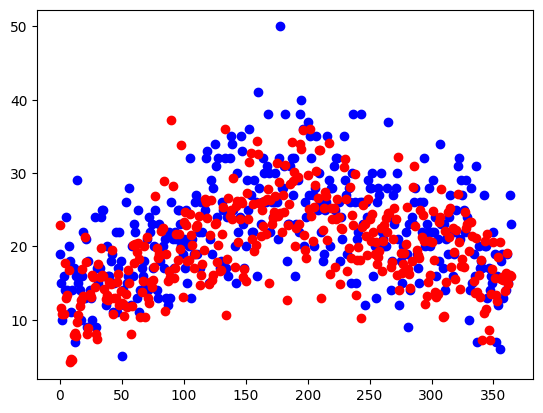

<<<----------------------------------- Training Set ----------------------------------->>>

R2 Score: 0.7754904291787603
Mean square error  9.696422164196537
Root Mean square error 3.1139078605823483
<<<----------------------------------- Testing Set ----------------------------------->>>

R2 Score: 0.14684358985113177
Mean square error  41.13546543560082
Root Mean square error 6.413693587598399


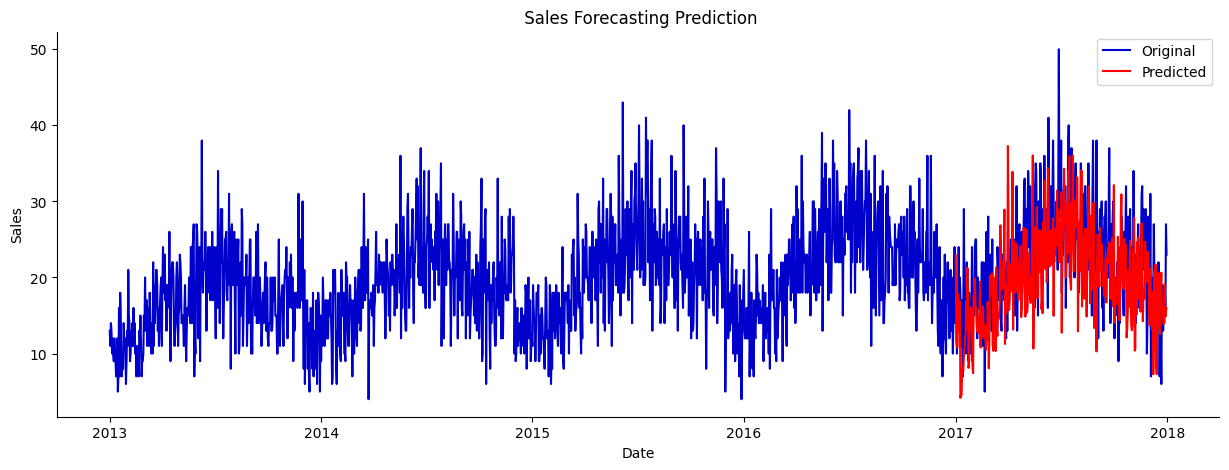

In [47]:
#stak lstm
Train_X_std1 = X_train.values.reshape(X_train.shape[0], X_train.shape[1],1)
Test_X_std1 = X_test.values.reshape(X_test.shape[0], X_test.shape[1],1)


slstm=Sequential()
slstm.add(LSTM(256, return_sequences = True, input_shape = (Train_X_std1.shape[1], 1)))
slstm.add(LSTM(50,return_sequences=True))
slstm.add(LSTM(50))
slstm.add(Dense(1))
slstm.compile(loss = 'mean_squared_error', optimizer = 'adam',metrics= ['accuracy'])
slstm.fit(Train_X_std1, y_train, epochs = 750, batch_size = 32, verbose = 2, shuffle = False)


#predict the traing and testing values
pred1 = slstm.predict(X_train)
pred2 = slstm.predict(X_test)

print('{}{}\033[1m Evaluating on Stack LSTM Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)

Evaluate(13, pred1.reshape(-1), pred2.reshape(-1))

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:   4%|▎         | 13/365 [00:00<?, ?it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:   4%|▍         | 15/365 [00:10<01:44,  3.35it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:   4%|▍         | 16/365 [00:11<02:14,  2.59it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:   5%|▍         | 17/365 [00:12<03:19,  1.75it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:   5%|▍         | 18/365 [00:12<03:23,  1.71it/s]

15/15 [==============================] - 0s 8ms/step


ExactExplainer explainer:   5%|▌         | 19/365 [00:13<03:23,  1.70it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:   5%|▌         | 20/365 [00:13<03:13,  1.78it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:   6%|▌         | 21/365 [00:14<03:09,  1.81it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:   6%|▌         | 22/365 [00:15<03:30,  1.63it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:   6%|▋         | 23/365 [00:15<03:29,  1.64it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:   7%|▋         | 24/365 [00:16<03:29,  1.63it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:   7%|▋         | 25/365 [00:17<03:43,  1.52it/s]

15/15 [==============================] - 0s 13ms/step


ExactExplainer explainer:   7%|▋         | 26/365 [00:18<04:03,  1.39it/s]

16/16 [==============================] - 0s 14ms/step


ExactExplainer explainer:   7%|▋         | 27/365 [00:18<04:11,  1.34it/s]

15/15 [==============================] - 0s 14ms/step


ExactExplainer explainer:   8%|▊         | 28/365 [00:19<04:23,  1.28it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:   8%|▊         | 29/365 [00:20<04:35,  1.22it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:   8%|▊         | 30/365 [00:21<04:05,  1.37it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:   8%|▊         | 31/365 [00:21<04:06,  1.35it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:   9%|▉         | 32/365 [00:22<03:47,  1.46it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:   9%|▉         | 33/365 [00:23<03:39,  1.52it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:   9%|▉         | 34/365 [00:23<03:48,  1.45it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  10%|▉         | 35/365 [00:24<03:54,  1.41it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  10%|▉         | 36/365 [00:25<03:35,  1.52it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  10%|█         | 37/365 [00:25<03:40,  1.49it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  10%|█         | 38/365 [00:26<03:24,  1.60it/s]

15/15 [==============================] - 0s 8ms/step


ExactExplainer explainer:  11%|█         | 39/365 [00:26<03:12,  1.69it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  11%|█         | 40/365 [00:27<03:04,  1.76it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  11%|█         | 41/365 [00:28<03:24,  1.58it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  12%|█▏        | 42/365 [00:28<03:21,  1.60it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  12%|█▏        | 43/365 [00:29<03:10,  1.69it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  12%|█▏        | 44/365 [00:29<03:04,  1.74it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  12%|█▏        | 45/365 [00:30<02:57,  1.80it/s]

16/16 [==============================] - 0s 12ms/step


ExactExplainer explainer:  13%|█▎        | 46/365 [00:31<03:24,  1.56it/s]

15/15 [==============================] - 0s 14ms/step


ExactExplainer explainer:  13%|█▎        | 47/365 [00:32<04:12,  1.26it/s]

16/16 [==============================] - 0s 14ms/step


ExactExplainer explainer:  13%|█▎        | 48/365 [00:33<04:38,  1.14it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  13%|█▎        | 49/365 [00:34<04:27,  1.18it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  14%|█▎        | 50/365 [00:34<03:55,  1.34it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  14%|█▍        | 51/365 [00:35<03:43,  1.41it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  14%|█▍        | 52/365 [00:36<04:02,  1.29it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  15%|█▍        | 53/365 [00:36<03:53,  1.34it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  15%|█▍        | 54/365 [00:37<03:44,  1.38it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  15%|█▌        | 55/365 [00:38<03:40,  1.41it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  15%|█▌        | 56/365 [00:38<03:29,  1.47it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  16%|█▌        | 57/365 [00:39<03:21,  1.53it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  16%|█▌        | 58/365 [00:40<03:22,  1.51it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  16%|█▌        | 59/365 [00:40<03:15,  1.57it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  16%|█▋        | 60/365 [00:41<03:04,  1.66it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  17%|█▋        | 61/365 [00:41<02:54,  1.74it/s]

15/15 [==============================] - 0s 8ms/step


ExactExplainer explainer:  17%|█▋        | 62/365 [00:42<02:49,  1.78it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  17%|█▋        | 63/365 [00:42<02:52,  1.75it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  18%|█▊        | 64/365 [00:43<02:49,  1.77it/s]

16/16 [==============================] - 0s 14ms/step


ExactExplainer explainer:  18%|█▊        | 65/365 [00:44<03:07,  1.60it/s]

15/15 [==============================] - 0s 14ms/step


ExactExplainer explainer:  18%|█▊        | 66/365 [00:44<03:26,  1.45it/s]

15/15 [==============================] - 0s 14ms/step


ExactExplainer explainer:  18%|█▊        | 67/365 [00:46<04:06,  1.21it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  19%|█▊        | 68/365 [00:46<04:06,  1.20it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  19%|█▉        | 69/365 [00:47<03:45,  1.31it/s]

15/15 [==============================] - 0s 8ms/step


ExactExplainer explainer:  19%|█▉        | 70/365 [00:48<03:21,  1.46it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  19%|█▉        | 71/365 [00:48<03:15,  1.50it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  20%|█▉        | 72/365 [00:49<03:01,  1.61it/s]

15/15 [==============================] - 0s 8ms/step


ExactExplainer explainer:  20%|██        | 73/365 [00:49<02:51,  1.70it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  20%|██        | 74/365 [00:50<02:52,  1.68it/s]

15/15 [==============================] - 0s 8ms/step


ExactExplainer explainer:  21%|██        | 75/365 [00:50<02:51,  1.69it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  21%|██        | 76/365 [00:51<02:57,  1.63it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  21%|██        | 77/365 [00:52<02:55,  1.64it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  21%|██▏       | 78/365 [00:52<02:49,  1.69it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  22%|██▏       | 79/365 [00:53<02:55,  1.63it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  22%|██▏       | 80/365 [00:53<02:45,  1.72it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  22%|██▏       | 81/365 [00:54<02:39,  1.78it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  22%|██▏       | 82/365 [00:55<02:42,  1.74it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  23%|██▎       | 83/365 [00:55<02:45,  1.71it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  23%|██▎       | 84/365 [00:56<02:52,  1.63it/s]

16/16 [==============================] - 0s 14ms/step


ExactExplainer explainer:  23%|██▎       | 85/365 [00:56<02:52,  1.62it/s]

16/16 [==============================] - 0s 13ms/step


ExactExplainer explainer:  24%|██▎       | 86/365 [00:57<03:05,  1.50it/s]

15/15 [==============================] - 0s 13ms/step


ExactExplainer explainer:  24%|██▍       | 87/365 [00:58<03:15,  1.42it/s]

15/15 [==============================] - 0s 12ms/step


ExactExplainer explainer:  24%|██▍       | 88/365 [00:59<03:14,  1.42it/s]

15/15 [==============================] - 0s 14ms/step


ExactExplainer explainer:  24%|██▍       | 89/365 [01:00<03:26,  1.34it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  25%|██▍       | 90/365 [01:00<03:18,  1.38it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  25%|██▍       | 91/365 [01:01<03:07,  1.46it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  25%|██▌       | 92/365 [01:01<02:58,  1.53it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  25%|██▌       | 93/365 [01:02<03:00,  1.51it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  26%|██▌       | 94/365 [01:03<02:53,  1.56it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  26%|██▌       | 95/365 [01:03<03:03,  1.47it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  26%|██▋       | 96/365 [01:04<02:48,  1.59it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  27%|██▋       | 97/365 [01:05<02:54,  1.54it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  27%|██▋       | 98/365 [01:05<02:44,  1.62it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  27%|██▋       | 99/365 [01:06<02:35,  1.71it/s]

16/16 [==============================] - 0s 10ms/step


ExactExplainer explainer:  27%|██▋       | 100/365 [01:06<02:32,  1.74it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  28%|██▊       | 101/365 [01:07<02:47,  1.57it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  28%|██▊       | 102/365 [01:08<02:43,  1.60it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  28%|██▊       | 103/365 [01:08<02:34,  1.70it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  28%|██▊       | 104/365 [01:09<02:46,  1.56it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  29%|██▉       | 105/365 [01:10<02:56,  1.48it/s]

16/16 [==============================] - 0s 13ms/step


ExactExplainer explainer:  29%|██▉       | 106/365 [01:11<03:26,  1.25it/s]

16/16 [==============================] - 0s 12ms/step


ExactExplainer explainer:  29%|██▉       | 107/365 [01:12<03:33,  1.21it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  30%|██▉       | 108/365 [01:13<03:42,  1.15it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  30%|██▉       | 109/365 [01:13<03:21,  1.27it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  30%|███       | 110/365 [01:14<02:59,  1.42it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  30%|███       | 111/365 [01:14<02:50,  1.49it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  31%|███       | 112/365 [01:15<02:37,  1.60it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  31%|███       | 113/365 [01:15<02:35,  1.62it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  31%|███       | 114/365 [01:16<02:35,  1.61it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  32%|███▏      | 115/365 [01:17<02:29,  1.67it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  32%|███▏      | 116/365 [01:17<02:29,  1.67it/s]

15/15 [==============================] - 0s 8ms/step


ExactExplainer explainer:  32%|███▏      | 117/365 [01:18<02:22,  1.74it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  32%|███▏      | 118/365 [01:18<02:35,  1.59it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  33%|███▎      | 119/365 [01:19<02:38,  1.55it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  33%|███▎      | 120/365 [01:20<02:35,  1.58it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  33%|███▎      | 121/365 [01:20<02:32,  1.60it/s]

15/15 [==============================] - 0s 8ms/step


ExactExplainer explainer:  33%|███▎      | 122/365 [01:21<02:23,  1.69it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  34%|███▎      | 123/365 [01:21<02:24,  1.68it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  34%|███▍      | 124/365 [01:22<02:17,  1.75it/s]

16/16 [==============================] - 0s 14ms/step


ExactExplainer explainer:  34%|███▍      | 125/365 [01:23<02:21,  1.70it/s]

16/16 [==============================] - 0s 14ms/step


ExactExplainer explainer:  35%|███▍      | 126/365 [01:24<02:57,  1.35it/s]

16/16 [==============================] - 0s 15ms/step


ExactExplainer explainer:  35%|███▍      | 127/365 [01:25<03:26,  1.15it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  35%|███▌      | 128/365 [01:26<03:11,  1.24it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  35%|███▌      | 129/365 [01:26<02:56,  1.34it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  36%|███▌      | 130/365 [01:27<02:45,  1.42it/s]

15/15 [==============================] - 0s 8ms/step


ExactExplainer explainer:  36%|███▌      | 131/365 [01:27<02:37,  1.49it/s]

16/16 [==============================] - 0s 10ms/step


ExactExplainer explainer:  36%|███▌      | 132/365 [01:28<02:36,  1.49it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  36%|███▋      | 133/365 [01:29<02:31,  1.53it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  37%|███▋      | 134/365 [01:29<02:32,  1.51it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  37%|███▋      | 135/365 [01:30<02:28,  1.55it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  37%|███▋      | 136/365 [01:31<02:24,  1.58it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  38%|███▊      | 137/365 [01:32<03:11,  1.19it/s]

15/15 [==============================] - 0s 8ms/step


ExactExplainer explainer:  38%|███▊      | 138/365 [01:32<02:48,  1.35it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  38%|███▊      | 139/365 [01:33<02:42,  1.39it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  38%|███▊      | 140/365 [01:34<02:34,  1.46it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  39%|███▊      | 141/365 [01:34<02:25,  1.54it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  39%|███▉      | 142/365 [01:35<02:21,  1.58it/s]

15/15 [==============================] - 0s 14ms/step


ExactExplainer explainer:  39%|███▉      | 143/365 [01:35<02:23,  1.54it/s]

15/15 [==============================] - 0s 14ms/step


ExactExplainer explainer:  39%|███▉      | 144/365 [01:37<02:50,  1.29it/s]

15/15 [==============================] - 0s 14ms/step


ExactExplainer explainer:  40%|███▉      | 145/365 [01:37<02:54,  1.26it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  40%|████      | 146/365 [01:39<03:20,  1.09it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  40%|████      | 147/365 [01:39<03:09,  1.15it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  41%|████      | 148/365 [01:40<03:02,  1.19it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  41%|████      | 149/365 [01:41<02:52,  1.25it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  41%|████      | 150/365 [01:42<02:47,  1.28it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  41%|████▏     | 151/365 [01:42<02:29,  1.43it/s]

15/15 [==============================] - 0s 8ms/step


ExactExplainer explainer:  42%|████▏     | 152/365 [01:43<02:22,  1.49it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  42%|████▏     | 153/365 [01:43<02:28,  1.43it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  42%|████▏     | 154/365 [01:44<02:16,  1.55it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  42%|████▏     | 155/365 [01:45<02:08,  1.63it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  43%|████▎     | 156/365 [01:45<02:07,  1.64it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  43%|████▎     | 157/365 [01:46<02:16,  1.52it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  43%|████▎     | 158/365 [01:47<02:18,  1.49it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  44%|████▎     | 159/365 [01:47<02:14,  1.53it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  44%|████▍     | 160/365 [01:48<02:21,  1.45it/s]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  44%|████▍     | 161/365 [01:49<02:23,  1.43it/s]

16/16 [==============================] - 0s 13ms/step


ExactExplainer explainer:  44%|████▍     | 162/365 [01:50<02:28,  1.36it/s]

16/16 [==============================] - 0s 14ms/step


ExactExplainer explainer:  45%|████▍     | 163/365 [01:50<02:34,  1.31it/s]

16/16 [==============================] - 0s 13ms/step


ExactExplainer explainer:  45%|████▍     | 164/365 [01:52<02:57,  1.13it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  45%|████▌     | 165/365 [01:52<02:49,  1.18it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  45%|████▌     | 166/365 [01:53<02:29,  1.33it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  46%|████▌     | 167/365 [01:53<02:15,  1.46it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  46%|████▌     | 168/365 [01:54<02:10,  1.51it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  46%|████▋     | 169/365 [01:54<02:02,  1.60it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  47%|████▋     | 170/365 [01:55<01:59,  1.63it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  47%|████▋     | 171/365 [01:56<01:54,  1.69it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  47%|████▋     | 172/365 [01:56<01:58,  1.62it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  47%|████▋     | 173/365 [01:57<01:53,  1.70it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  48%|████▊     | 174/365 [01:57<01:53,  1.68it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  48%|████▊     | 175/365 [01:58<01:53,  1.67it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  48%|████▊     | 176/365 [01:59<01:53,  1.67it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  48%|████▊     | 177/365 [01:59<02:02,  1.54it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  49%|████▉     | 178/365 [02:00<01:53,  1.65it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  49%|████▉     | 179/365 [02:00<01:48,  1.71it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  49%|████▉     | 180/365 [02:01<01:46,  1.74it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  50%|████▉     | 181/365 [02:02<01:51,  1.65it/s]

15/15 [==============================] - 0s 14ms/step


ExactExplainer explainer:  50%|████▉     | 182/365 [02:03<02:16,  1.34it/s]

16/16 [==============================] - 0s 14ms/step


ExactExplainer explainer:  50%|█████     | 183/365 [02:04<02:33,  1.18it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  50%|█████     | 184/365 [02:05<02:26,  1.24it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  51%|█████     | 185/365 [02:05<02:14,  1.33it/s]

16/16 [==============================] - 0s 10ms/step


ExactExplainer explainer:  51%|█████     | 186/365 [02:06<02:20,  1.28it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  51%|█████     | 187/365 [02:07<02:05,  1.42it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  52%|█████▏    | 188/365 [02:07<01:53,  1.55it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  52%|█████▏    | 189/365 [02:08<01:47,  1.64it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  52%|█████▏    | 190/365 [02:08<01:41,  1.73it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  52%|█████▏    | 191/365 [02:09<01:42,  1.71it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  53%|█████▎    | 192/365 [02:09<01:41,  1.70it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  53%|█████▎    | 193/365 [02:10<01:50,  1.56it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  53%|█████▎    | 194/365 [02:11<01:52,  1.52it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  53%|█████▎    | 195/365 [02:11<01:44,  1.63it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  54%|█████▎    | 196/365 [02:12<01:51,  1.52it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  54%|█████▍    | 197/365 [02:13<01:47,  1.56it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  54%|█████▍    | 198/365 [02:13<01:41,  1.65it/s]

15/15 [==============================] - 0s 8ms/step


ExactExplainer explainer:  55%|█████▍    | 199/365 [02:14<01:39,  1.66it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  55%|█████▍    | 200/365 [02:14<01:47,  1.54it/s]

15/15 [==============================] - 0s 13ms/step


ExactExplainer explainer:  55%|█████▌    | 201/365 [02:15<01:56,  1.41it/s]

16/16 [==============================] - 0s 13ms/step


ExactExplainer explainer:  55%|█████▌    | 202/365 [02:16<02:02,  1.33it/s]

15/15 [==============================] - 0s 14ms/step


ExactExplainer explainer:  56%|█████▌    | 203/365 [02:17<02:21,  1.14it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  56%|█████▌    | 204/365 [02:18<02:06,  1.27it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  56%|█████▌    | 205/365 [02:19<01:57,  1.36it/s]

15/15 [==============================] - 0s 8ms/step


ExactExplainer explainer:  56%|█████▋    | 206/365 [02:19<01:46,  1.49it/s]

16/16 [==============================] - 0s 10ms/step


ExactExplainer explainer:  57%|█████▋    | 207/365 [02:20<01:44,  1.52it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  57%|█████▋    | 208/365 [02:20<01:40,  1.56it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  57%|█████▋    | 209/365 [02:21<01:37,  1.60it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  58%|█████▊    | 210/365 [02:21<01:35,  1.62it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  58%|█████▊    | 211/365 [02:22<01:32,  1.67it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  58%|█████▊    | 212/365 [02:23<01:28,  1.74it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  58%|█████▊    | 213/365 [02:23<01:35,  1.59it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  59%|█████▊    | 214/365 [02:24<01:37,  1.55it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  59%|█████▉    | 215/365 [02:25<01:42,  1.47it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  59%|█████▉    | 216/365 [02:25<01:34,  1.58it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  59%|█████▉    | 217/365 [02:26<01:33,  1.58it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  60%|█████▉    | 218/365 [02:27<01:34,  1.55it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  60%|██████    | 219/365 [02:27<01:39,  1.47it/s]

15/15 [==============================] - 0s 14ms/step


ExactExplainer explainer:  60%|██████    | 220/365 [02:28<01:42,  1.42it/s]

15/15 [==============================] - 0s 14ms/step


ExactExplainer explainer:  61%|██████    | 221/365 [02:29<01:48,  1.33it/s]

15/15 [==============================] - 0s 13ms/step


ExactExplainer explainer:  61%|██████    | 222/365 [02:30<02:05,  1.14it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  61%|██████    | 223/365 [02:31<02:07,  1.11it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  61%|██████▏   | 224/365 [02:32<01:54,  1.23it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  62%|██████▏   | 225/365 [02:32<01:51,  1.25it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  62%|██████▏   | 226/365 [02:33<01:39,  1.40it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  62%|██████▏   | 227/365 [02:34<01:31,  1.50it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  62%|██████▏   | 228/365 [02:34<01:31,  1.49it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  63%|██████▎   | 229/365 [02:35<01:34,  1.43it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  63%|██████▎   | 230/365 [02:36<01:28,  1.53it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  63%|██████▎   | 231/365 [02:36<01:22,  1.62it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  64%|██████▎   | 232/365 [02:37<01:22,  1.61it/s]

16/16 [==============================] - 0s 10ms/step


ExactExplainer explainer:  64%|██████▍   | 233/365 [02:37<01:24,  1.56it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  64%|██████▍   | 234/365 [02:38<01:23,  1.57it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  64%|██████▍   | 235/365 [02:39<01:21,  1.60it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  65%|██████▍   | 236/365 [02:39<01:15,  1.70it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  65%|██████▍   | 237/365 [02:40<01:22,  1.55it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  65%|██████▌   | 238/365 [02:41<01:23,  1.52it/s]

16/16 [==============================] - 0s 13ms/step


ExactExplainer explainer:  65%|██████▌   | 239/365 [02:41<01:28,  1.43it/s]

16/16 [==============================] - 0s 12ms/step


ExactExplainer explainer:  66%|██████▌   | 240/365 [02:42<01:30,  1.38it/s]

15/15 [==============================] - 0s 15ms/step


ExactExplainer explainer:  66%|██████▌   | 241/365 [02:43<01:43,  1.20it/s]

15/15 [==============================] - 0s 8ms/step


ExactExplainer explainer:  66%|██████▋   | 242/365 [02:44<01:46,  1.15it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  67%|██████▋   | 243/365 [02:45<01:42,  1.19it/s]

16/16 [==============================] - 0s 10ms/step


ExactExplainer explainer:  67%|██████▋   | 244/365 [02:46<01:33,  1.29it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  67%|██████▋   | 245/365 [02:46<01:23,  1.44it/s]

16/16 [==============================] - 0s 10ms/step


ExactExplainer explainer:  67%|██████▋   | 246/365 [02:47<01:17,  1.53it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  68%|██████▊   | 247/365 [02:47<01:12,  1.62it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  68%|██████▊   | 248/365 [02:48<01:17,  1.51it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  68%|██████▊   | 249/365 [02:49<01:20,  1.45it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  68%|██████▊   | 250/365 [02:49<01:18,  1.46it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  69%|██████▉   | 251/365 [02:50<01:20,  1.41it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  69%|██████▉   | 252/365 [02:51<01:17,  1.46it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  69%|██████▉   | 253/365 [02:51<01:14,  1.51it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  70%|██████▉   | 254/365 [02:52<01:12,  1.54it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  70%|██████▉   | 255/365 [02:53<01:07,  1.63it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  70%|███████   | 256/365 [02:53<01:11,  1.52it/s]

15/15 [==============================] - 0s 13ms/step


ExactExplainer explainer:  70%|███████   | 257/365 [02:54<01:15,  1.44it/s]

16/16 [==============================] - 0s 15ms/step


ExactExplainer explainer:  71%|███████   | 258/365 [02:55<01:18,  1.36it/s]

16/16 [==============================] - 0s 13ms/step


ExactExplainer explainer:  71%|███████   | 259/365 [02:56<01:18,  1.35it/s]

16/16 [==============================] - 0s 11ms/step


ExactExplainer explainer:  71%|███████   | 260/365 [02:56<01:18,  1.34it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  72%|███████▏  | 261/365 [02:57<01:24,  1.22it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  72%|███████▏  | 262/365 [02:58<01:17,  1.33it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  72%|███████▏  | 263/365 [02:59<01:14,  1.37it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  72%|███████▏  | 264/365 [02:59<01:09,  1.44it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  73%|███████▎  | 265/365 [03:00<01:06,  1.50it/s]

15/15 [==============================] - 0s 8ms/step


ExactExplainer explainer:  73%|███████▎  | 266/365 [03:00<01:02,  1.60it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  73%|███████▎  | 267/365 [03:01<01:05,  1.49it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  73%|███████▎  | 268/365 [03:02<01:05,  1.49it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  74%|███████▎  | 269/365 [03:03<01:05,  1.48it/s]

16/16 [==============================] - 0s 10ms/step


ExactExplainer explainer:  74%|███████▍  | 270/365 [03:03<01:00,  1.56it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  74%|███████▍  | 271/365 [03:04<00:59,  1.59it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  75%|███████▍  | 272/365 [03:04<00:57,  1.61it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  75%|███████▍  | 273/365 [03:05<00:58,  1.57it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  75%|███████▌  | 274/365 [03:06<00:57,  1.59it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  75%|███████▌  | 275/365 [03:06<00:56,  1.59it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  76%|███████▌  | 276/365 [03:07<00:52,  1.69it/s]

15/15 [==============================] - 0s 15ms/step


ExactExplainer explainer:  76%|███████▌  | 277/365 [03:07<00:54,  1.62it/s]

16/16 [==============================] - 0s 13ms/step


ExactExplainer explainer:  76%|███████▌  | 278/365 [03:08<01:05,  1.32it/s]

16/16 [==============================] - 0s 12ms/step


ExactExplainer explainer:  76%|███████▋  | 279/365 [03:09<01:04,  1.34it/s]

16/16 [==============================] - 0s 13ms/step


ExactExplainer explainer:  77%|███████▋  | 280/365 [03:10<01:06,  1.28it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  77%|███████▋  | 281/365 [03:11<01:02,  1.34it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  77%|███████▋  | 282/365 [03:11<00:56,  1.47it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  78%|███████▊  | 283/365 [03:12<01:01,  1.33it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  78%|███████▊  | 284/365 [03:13<00:57,  1.41it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  78%|███████▊  | 285/365 [03:13<00:51,  1.55it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  78%|███████▊  | 286/365 [03:14<00:50,  1.58it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  79%|███████▊  | 287/365 [03:14<00:46,  1.68it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  79%|███████▉  | 288/365 [03:15<00:48,  1.60it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  79%|███████▉  | 289/365 [03:16<00:51,  1.49it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  79%|███████▉  | 290/365 [03:16<00:46,  1.61it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  80%|███████▉  | 291/365 [03:17<00:45,  1.61it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  80%|████████  | 292/365 [03:18<00:46,  1.58it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  80%|████████  | 293/365 [03:18<00:45,  1.59it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  81%|████████  | 294/365 [03:19<00:44,  1.61it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  81%|████████  | 295/365 [03:19<00:41,  1.70it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  81%|████████  | 296/365 [03:20<00:39,  1.73it/s]

15/15 [==============================] - 0s 12ms/step


ExactExplainer explainer:  81%|████████▏ | 297/365 [03:21<00:40,  1.66it/s]

15/15 [==============================] - 0s 15ms/step


ExactExplainer explainer:  82%|████████▏ | 298/365 [03:22<00:51,  1.31it/s]

15/15 [==============================] - 0s 14ms/step


ExactExplainer explainer:  82%|████████▏ | 299/365 [03:23<00:52,  1.26it/s]

16/16 [==============================] - 0s 14ms/step


ExactExplainer explainer:  82%|████████▏ | 300/365 [03:23<00:52,  1.23it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  82%|████████▏ | 301/365 [03:24<00:48,  1.33it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  83%|████████▎ | 302/365 [03:25<00:44,  1.40it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  83%|████████▎ | 303/365 [03:25<00:42,  1.47it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  83%|████████▎ | 304/365 [03:26<00:40,  1.51it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  84%|████████▎ | 305/365 [03:27<00:38,  1.57it/s]

15/15 [==============================] - 0s 8ms/step


ExactExplainer explainer:  84%|████████▍ | 306/365 [03:27<00:40,  1.47it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  84%|████████▍ | 307/365 [03:28<00:39,  1.48it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  84%|████████▍ | 308/365 [03:29<00:37,  1.53it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  85%|████████▍ | 309/365 [03:29<00:35,  1.56it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  85%|████████▍ | 310/365 [03:30<00:34,  1.59it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  85%|████████▌ | 311/365 [03:30<00:32,  1.66it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  85%|████████▌ | 312/365 [03:31<00:31,  1.66it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  86%|████████▌ | 313/365 [03:32<00:31,  1.65it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  86%|████████▌ | 314/365 [03:32<00:33,  1.54it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  86%|████████▋ | 315/365 [03:33<00:33,  1.48it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  87%|████████▋ | 316/365 [03:34<00:31,  1.57it/s]

16/16 [==============================] - 0s 12ms/step


ExactExplainer explainer:  87%|████████▋ | 317/365 [03:35<00:37,  1.28it/s]

15/15 [==============================] - 0s 13ms/step


ExactExplainer explainer:  87%|████████▋ | 318/365 [03:36<00:40,  1.17it/s]

15/15 [==============================] - 0s 13ms/step


ExactExplainer explainer:  87%|████████▋ | 319/365 [03:37<00:39,  1.16it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  88%|████████▊ | 320/365 [03:37<00:35,  1.27it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  88%|████████▊ | 321/365 [03:38<00:31,  1.41it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  88%|████████▊ | 322/365 [03:38<00:31,  1.38it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  88%|████████▊ | 323/365 [03:39<00:28,  1.46it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  89%|████████▉ | 324/365 [03:40<00:26,  1.56it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  89%|████████▉ | 325/365 [03:40<00:24,  1.64it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  89%|████████▉ | 326/365 [03:41<00:24,  1.58it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  90%|████████▉ | 327/365 [03:42<00:24,  1.55it/s]

16/16 [==============================] - 0s 10ms/step


ExactExplainer explainer:  90%|████████▉ | 328/365 [03:43<00:28,  1.29it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  90%|█████████ | 329/365 [03:43<00:26,  1.37it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  90%|█████████ | 330/365 [03:44<00:25,  1.39it/s]

16/16 [==============================] - 0s 10ms/step


ExactExplainer explainer:  91%|█████████ | 331/365 [03:45<00:23,  1.45it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  91%|█████████ | 332/365 [03:45<00:20,  1.57it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  91%|█████████ | 333/365 [03:46<00:19,  1.66it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  92%|█████████▏| 334/365 [03:46<00:19,  1.61it/s]

16/16 [==============================] - 0s 10ms/step


ExactExplainer explainer:  92%|█████████▏| 335/365 [03:47<00:19,  1.51it/s]

16/16 [==============================] - 0s 14ms/step


ExactExplainer explainer:  92%|█████████▏| 336/365 [03:48<00:21,  1.36it/s]

16/16 [==============================] - 0s 12ms/step


ExactExplainer explainer:  92%|█████████▏| 337/365 [03:49<00:24,  1.16it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  93%|█████████▎| 338/365 [03:50<00:24,  1.12it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  93%|█████████▎| 339/365 [03:51<00:21,  1.22it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  93%|█████████▎| 340/365 [03:51<00:18,  1.37it/s]

15/15 [==============================] - 0s 11ms/step


ExactExplainer explainer:  93%|█████████▎| 341/365 [03:52<00:16,  1.48it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  94%|█████████▎| 342/365 [03:52<00:15,  1.51it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  94%|█████████▍| 343/365 [03:53<00:13,  1.57it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  94%|█████████▍| 344/365 [03:54<00:13,  1.58it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  95%|█████████▍| 345/365 [03:54<00:13,  1.52it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  95%|█████████▍| 346/365 [03:55<00:12,  1.55it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  95%|█████████▌| 347/365 [03:56<00:11,  1.57it/s]

15/15 [==============================] - 0s 9ms/step


ExactExplainer explainer:  95%|█████████▌| 348/365 [03:56<00:10,  1.63it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  96%|█████████▌| 349/365 [03:57<00:09,  1.63it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  96%|█████████▌| 350/365 [03:57<00:09,  1.51it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  96%|█████████▌| 351/365 [03:58<00:08,  1.56it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  96%|█████████▋| 352/365 [03:59<00:08,  1.53it/s]

16/16 [==============================] - 0s 8ms/step


ExactExplainer explainer:  97%|█████████▋| 353/365 [04:00<00:08,  1.46it/s]

16/16 [==============================] - 0s 14ms/step


ExactExplainer explainer:  97%|█████████▋| 354/365 [04:00<00:07,  1.41it/s]

15/15 [==============================] - 0s 12ms/step


ExactExplainer explainer:  97%|█████████▋| 355/365 [04:01<00:08,  1.20it/s]

15/15 [==============================] - 0s 14ms/step


ExactExplainer explainer:  98%|█████████▊| 356/365 [04:02<00:08,  1.11it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  98%|█████████▊| 357/365 [04:03<00:07,  1.08it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  98%|█████████▊| 358/365 [04:04<00:05,  1.22it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  98%|█████████▊| 359/365 [04:05<00:04,  1.31it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer:  99%|█████████▊| 360/365 [04:06<00:04,  1.22it/s]

16/16 [==============================] - 0s 10ms/step


ExactExplainer explainer:  99%|█████████▉| 361/365 [04:06<00:03,  1.30it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  99%|█████████▉| 362/365 [04:07<00:02,  1.34it/s]

15/15 [==============================] - 0s 10ms/step


ExactExplainer explainer:  99%|█████████▉| 363/365 [04:08<00:01,  1.41it/s]

16/16 [==============================] - 0s 10ms/step


ExactExplainer explainer: 100%|█████████▉| 364/365 [04:08<00:00,  1.37it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer: 100%|██████████| 365/365 [04:09<00:00,  1.43it/s]

16/16 [==============================] - 0s 9ms/step


ExactExplainer explainer: 366it [04:10,  1.41it/s]


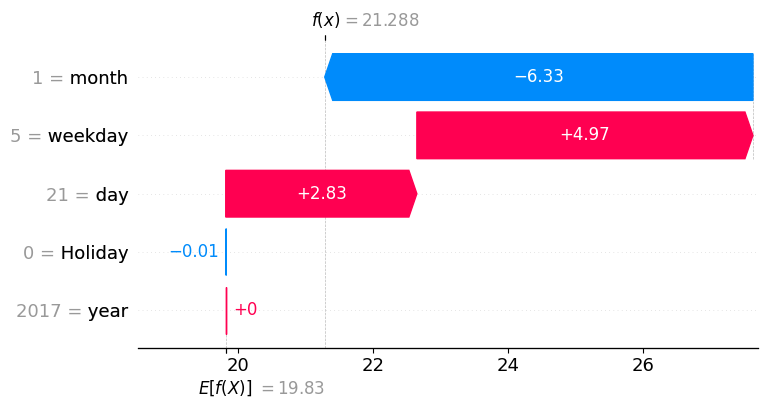

In [48]:
shar_model1(slstm)

Epoch 1/750
46/46 - 10s - loss: 176.5327 - 10s/epoch - 228ms/step
Epoch 2/750
46/46 - 2s - loss: 84.3507 - 2s/epoch - 53ms/step
Epoch 3/750
46/46 - 3s - loss: 56.0249 - 3s/epoch - 66ms/step
Epoch 4/750
46/46 - 3s - loss: 46.3223 - 3s/epoch - 68ms/step
Epoch 5/750
46/46 - 2s - loss: 43.7741 - 2s/epoch - 52ms/step
Epoch 6/750
46/46 - 2s - loss: 43.3905 - 2s/epoch - 51ms/step
Epoch 7/750
46/46 - 2s - loss: 43.4687 - 2s/epoch - 53ms/step
Epoch 8/750
46/46 - 3s - loss: 43.5753 - 3s/epoch - 63ms/step
Epoch 9/750
46/46 - 3s - loss: 43.6441 - 3s/epoch - 69ms/step
Epoch 10/750
46/46 - 2s - loss: 43.6839 - 2s/epoch - 52ms/step
Epoch 11/750
46/46 - 2s - loss: 43.7082 - 2s/epoch - 53ms/step
Epoch 12/750
46/46 - 2s - loss: 43.7248 - 2s/epoch - 52ms/step
Epoch 13/750
46/46 - 3s - loss: 43.7376 - 3s/epoch - 62ms/step
Epoch 14/750
46/46 - 3s - loss: 43.7482 - 3s/epoch - 69ms/step
Epoch 15/750
46/46 - 2s - loss: 43.7575 - 2s/epoch - 52ms/step
Epoch 16/750
46/46 - 2s - loss: 43.7657 - 2s/epoch - 51ms/st

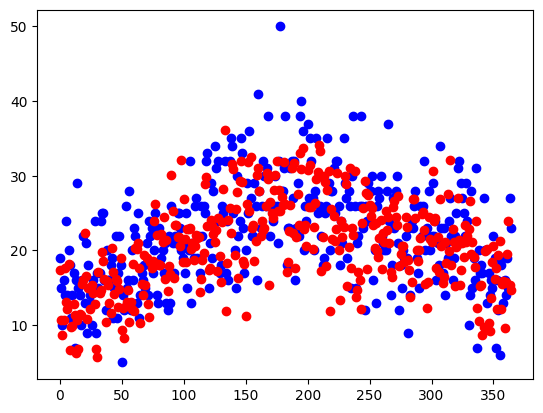

<<<----------------------------------- Training Set ----------------------------------->>>

R2 Score: 0.8842106057499375
Mean square error  5.0008685361532015
Root Mean square error 2.2362621796545237
<<<----------------------------------- Testing Set ----------------------------------->>>

R2 Score: 0.1947232700869721
Mean square error  38.8269169584636
Root Mean square error 6.231124854989154


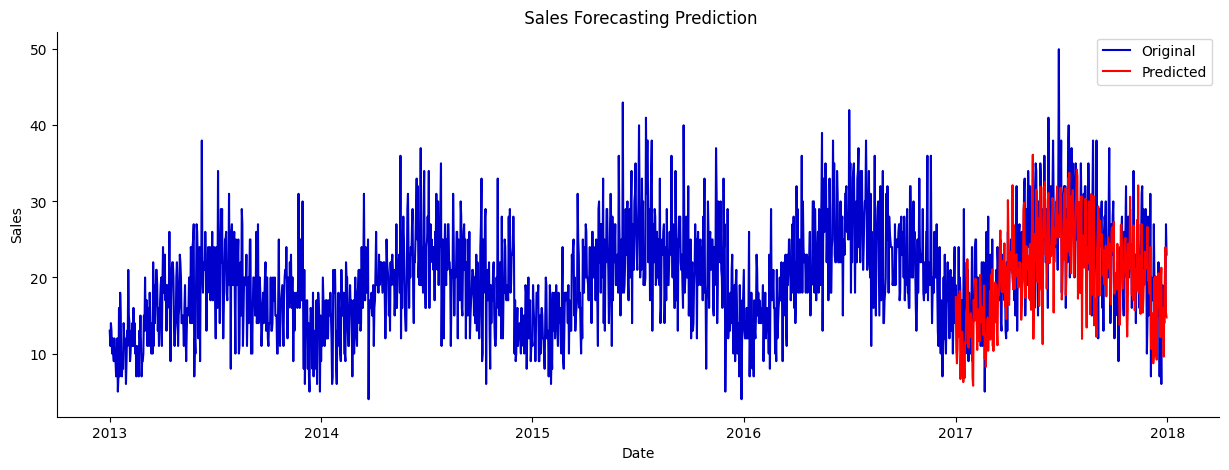

In [49]:
# reshape data
Train_X_std1 = X_train.values.reshape(X_train.shape[0], X_train.shape[1],1)
Test_X_std1 = X_test.values.reshape(X_test.shape[0], X_test.shape[1],1)

# model
blstm = Sequential()
blstm.add(Bidirectional(LSTM(256, return_sequences=True), input_shape = (Train_X_std1.shape[1], 1)))
blstm.add(Bidirectional(LSTM(128)))
blstm.add(Activation('relu'))
blstm.add(Dense(1))
blstm.compile(loss = 'mean_squared_error', optimizer = 'adam')
blstm.fit(Train_X_std1, y_train, epochs = 750, batch_size = 32, verbose = 2, shuffle = False)


#predict the traing and testing values
pred1 = blstm.predict(X_train)
pred2 = blstm.predict(X_test)

print('{}{}\033[1m Evaluating on Bi-LSTM Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)

Evaluate(14, pred1.reshape(-1), pred2.reshape(-1))

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:   2%|▏         | 8/365 [00:00<?, ?it/s]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:   3%|▎         | 10/365 [00:11<02:28,  2.39it/s]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:   3%|▎         | 11/365 [00:12<04:00,  1.47it/s]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:   3%|▎         | 12/365 [00:13<04:47,  1.23it/s]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:   4%|▎         | 13/365 [00:14<04:50,  1.21it/s]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:   4%|▍         | 14/365 [00:15<05:12,  1.12it/s]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:   4%|▍         | 15/365 [00:16<05:32,  1.05it/s]

16/16 [==============================] - 0s 15ms/step


ExactExplainer explainer:   4%|▍         | 16/365 [00:17<05:40,  1.03it/s]

16/16 [==============================] - 0s 15ms/step


ExactExplainer explainer:   5%|▍         | 17/365 [00:19<07:02,  1.22s/it]

16/16 [==============================] - 0s 26ms/step


ExactExplainer explainer:   5%|▍         | 18/365 [00:20<07:02,  1.22s/it]

15/15 [==============================] - 0s 27ms/step


ExactExplainer explainer:   5%|▌         | 19/365 [00:22<07:26,  1.29s/it]

16/16 [==============================] - 0s 15ms/step


ExactExplainer explainer:   5%|▌         | 20/365 [00:23<07:12,  1.25s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:   6%|▌         | 21/365 [00:24<06:25,  1.12s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:   6%|▌         | 22/365 [00:25<06:21,  1.11s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:   6%|▋         | 23/365 [00:26<06:16,  1.10s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:   7%|▋         | 24/365 [00:27<06:13,  1.09s/it]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:   7%|▋         | 25/365 [00:28<06:05,  1.08s/it]

15/15 [==============================] - 0s 18ms/step


ExactExplainer explainer:   7%|▋         | 26/365 [00:29<05:39,  1.00s/it]

16/16 [==============================] - 0s 15ms/step


ExactExplainer explainer:   7%|▋         | 27/365 [00:30<05:22,  1.05it/s]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:   8%|▊         | 28/365 [00:30<05:06,  1.10it/s]

16/16 [==============================] - 0s 15ms/step


ExactExplainer explainer:   8%|▊         | 29/365 [00:31<05:00,  1.12it/s]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:   8%|▊         | 30/365 [00:32<04:56,  1.13it/s]

15/15 [==============================] - 0s 27ms/step


ExactExplainer explainer:   8%|▊         | 31/365 [00:33<05:29,  1.01it/s]

16/16 [==============================] - 0s 25ms/step


ExactExplainer explainer:   9%|▉         | 32/365 [00:35<05:59,  1.08s/it]

15/15 [==============================] - 0s 25ms/step


ExactExplainer explainer:   9%|▉         | 33/365 [00:36<06:16,  1.13s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:   9%|▉         | 34/365 [00:37<06:10,  1.12s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  10%|▉         | 35/365 [00:38<06:04,  1.10s/it]

16/16 [==============================] - 0s 18ms/step


ExactExplainer explainer:  10%|▉         | 36/365 [00:39<06:01,  1.10s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  10%|█         | 37/365 [00:40<05:36,  1.03s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  10%|█         | 38/365 [00:41<05:36,  1.03s/it]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  11%|█         | 39/365 [00:42<05:41,  1.05s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  11%|█         | 40/365 [00:43<05:44,  1.06s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  11%|█         | 41/365 [00:44<05:23,  1.00it/s]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  12%|█▏        | 42/365 [00:45<05:26,  1.01s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  12%|█▏        | 43/365 [00:46<05:12,  1.03it/s]

16/16 [==============================] - 0s 26ms/step


ExactExplainer explainer:  12%|█▏        | 44/365 [00:48<06:03,  1.13s/it]

16/16 [==============================] - 0s 27ms/step


ExactExplainer explainer:  12%|█▏        | 45/365 [00:49<06:36,  1.24s/it]

16/16 [==============================] - 0s 15ms/step


ExactExplainer explainer:  13%|█▎        | 46/365 [00:50<06:23,  1.20s/it]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  13%|█▎        | 47/365 [00:51<06:11,  1.17s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  13%|█▎        | 48/365 [00:52<05:43,  1.08s/it]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  13%|█▎        | 49/365 [00:53<05:36,  1.07s/it]

16/16 [==============================] - 0s 15ms/step


ExactExplainer explainer:  14%|█▎        | 50/365 [00:54<05:13,  1.00it/s]

16/16 [==============================] - 0s 15ms/step


ExactExplainer explainer:  14%|█▍        | 51/365 [00:55<05:20,  1.02s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  14%|█▍        | 52/365 [00:57<06:21,  1.22s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  15%|█▍        | 53/365 [00:58<06:03,  1.17s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  15%|█▍        | 54/365 [00:59<05:34,  1.08s/it]

16/16 [==============================] - 0s 26ms/step


ExactExplainer explainer:  15%|█▌        | 55/365 [01:00<05:47,  1.12s/it]

15/15 [==============================] - 0s 27ms/step


ExactExplainer explainer:  15%|█▌        | 56/365 [01:01<06:01,  1.17s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  16%|█▌        | 57/365 [01:03<06:54,  1.35s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  16%|█▌        | 58/365 [01:04<06:07,  1.20s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  16%|█▌        | 59/365 [01:05<05:37,  1.10s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  16%|█▋        | 60/365 [01:06<05:35,  1.10s/it]

15/15 [==============================] - 0s 18ms/step


ExactExplainer explainer:  17%|█▋        | 61/365 [01:07<05:12,  1.03s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  17%|█▋        | 62/365 [01:07<04:55,  1.03it/s]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  17%|█▋        | 63/365 [01:09<05:04,  1.01s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  18%|█▊        | 64/365 [01:10<05:07,  1.02s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  18%|█▊        | 65/365 [01:10<04:50,  1.03it/s]

15/15 [==============================] - 0s 18ms/step


ExactExplainer explainer:  18%|█▊        | 66/365 [01:12<05:01,  1.01s/it]

15/15 [==============================] - 0s 26ms/step


ExactExplainer explainer:  18%|█▊        | 67/365 [01:13<05:36,  1.13s/it]

15/15 [==============================] - 0s 28ms/step


ExactExplainer explainer:  19%|█▊        | 68/365 [01:15<07:02,  1.42s/it]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  19%|█▉        | 69/365 [01:16<06:31,  1.32s/it]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  19%|█▉        | 70/365 [01:17<06:07,  1.25s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  19%|█▉        | 71/365 [01:18<05:36,  1.15s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  20%|█▉        | 72/365 [01:19<05:10,  1.06s/it]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  20%|██        | 73/365 [01:20<05:11,  1.07s/it]

16/16 [==============================] - 0s 15ms/step


ExactExplainer explainer:  20%|██        | 74/365 [01:21<05:07,  1.06s/it]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  21%|██        | 75/365 [01:22<04:42,  1.03it/s]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  21%|██        | 76/365 [01:23<04:45,  1.01it/s]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  21%|██        | 77/365 [01:24<04:47,  1.00it/s]

16/16 [==============================] - 0s 15ms/step


ExactExplainer explainer:  21%|██▏       | 78/365 [01:25<04:49,  1.01s/it]

16/16 [==============================] - 0s 25ms/step


ExactExplainer explainer:  22%|██▏       | 79/365 [01:26<05:24,  1.13s/it]

15/15 [==============================] - 0s 25ms/step


ExactExplainer explainer:  22%|██▏       | 80/365 [01:28<05:49,  1.23s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  22%|██▏       | 81/365 [01:29<05:37,  1.19s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  22%|██▏       | 82/365 [01:30<05:23,  1.14s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  23%|██▎       | 83/365 [01:31<05:17,  1.13s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  23%|██▎       | 84/365 [01:32<04:52,  1.04s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  23%|██▎       | 85/365 [01:33<04:31,  1.03it/s]

16/16 [==============================] - 0s 15ms/step


ExactExplainer explainer:  24%|██▎       | 86/365 [01:34<04:36,  1.01it/s]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  24%|██▍       | 87/365 [01:35<04:42,  1.02s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  24%|██▍       | 88/365 [01:36<04:29,  1.03it/s]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  24%|██▍       | 89/365 [01:38<05:40,  1.23s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  25%|██▍       | 90/365 [01:38<05:09,  1.13s/it]

15/15 [==============================] - 0s 28ms/step


ExactExplainer explainer:  25%|██▍       | 91/365 [01:41<06:30,  1.42s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  25%|██▌       | 92/365 [01:42<06:56,  1.52s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  25%|██▌       | 93/365 [01:43<06:19,  1.40s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  26%|██▌       | 94/365 [01:44<05:34,  1.23s/it]

16/16 [==============================] - 0s 15ms/step


ExactExplainer explainer:  26%|██▌       | 95/365 [01:45<04:59,  1.11s/it]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  26%|██▋       | 96/365 [01:46<04:38,  1.03s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  27%|██▋       | 97/365 [01:47<04:43,  1.06s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  27%|██▋       | 98/365 [01:48<04:28,  1.01s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  27%|██▋       | 99/365 [01:49<04:19,  1.03it/s]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  27%|██▋       | 100/365 [01:50<04:24,  1.00it/s]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  28%|██▊       | 101/365 [01:51<04:11,  1.05it/s]

15/15 [==============================] - 0s 29ms/step


ExactExplainer explainer:  28%|██▊       | 102/365 [01:52<04:30,  1.03s/it]

15/15 [==============================] - 0s 27ms/step


ExactExplainer explainer:  28%|██▊       | 103/365 [01:53<05:04,  1.16s/it]

15/15 [==============================] - 0s 20ms/step


ExactExplainer explainer:  28%|██▊       | 104/365 [01:55<05:30,  1.27s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  29%|██▉       | 105/365 [01:56<04:58,  1.15s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  29%|██▉       | 106/365 [01:57<04:32,  1.05s/it]

16/16 [==============================] - 0s 15ms/step


ExactExplainer explainer:  29%|██▉       | 107/365 [01:57<04:16,  1.01it/s]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  30%|██▉       | 108/365 [01:59<04:22,  1.02s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  30%|██▉       | 109/365 [02:00<04:27,  1.05s/it]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  30%|███       | 110/365 [02:01<04:25,  1.04s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  30%|███       | 111/365 [02:02<04:28,  1.06s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  31%|███       | 112/365 [02:03<04:12,  1.00it/s]

16/16 [==============================] - 0s 15ms/step


ExactExplainer explainer:  31%|███       | 113/365 [02:04<03:59,  1.05it/s]

16/16 [==============================] - 0s 21ms/step


ExactExplainer explainer:  31%|███       | 114/365 [02:05<04:32,  1.09s/it]

15/15 [==============================] - 0s 27ms/step


ExactExplainer explainer:  32%|███▏      | 115/365 [02:07<05:33,  1.34s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  32%|███▏      | 116/365 [02:08<05:17,  1.28s/it]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  32%|███▏      | 117/365 [02:09<04:59,  1.21s/it]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  32%|███▏      | 118/365 [02:10<04:29,  1.09s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  33%|███▎      | 119/365 [02:11<04:09,  1.01s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  33%|███▎      | 120/365 [02:12<04:10,  1.02s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  33%|███▎      | 121/365 [02:13<03:58,  1.02it/s]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  33%|███▎      | 122/365 [02:14<04:04,  1.01s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  34%|███▎      | 123/365 [02:15<04:06,  1.02s/it]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  34%|███▍      | 124/365 [02:16<03:53,  1.03it/s]

16/16 [==============================] - 0s 15ms/step


ExactExplainer explainer:  34%|███▍      | 125/365 [02:17<04:01,  1.00s/it]

16/16 [==============================] - 0s 26ms/step


ExactExplainer explainer:  35%|███▍      | 126/365 [02:18<04:17,  1.08s/it]

16/16 [==============================] - 0s 26ms/step


ExactExplainer explainer:  35%|███▍      | 127/365 [02:20<05:32,  1.40s/it]

16/16 [==============================] - 0s 15ms/step


ExactExplainer explainer:  35%|███▌      | 128/365 [02:21<04:52,  1.23s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  35%|███▌      | 129/365 [02:22<04:23,  1.12s/it]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  36%|███▌      | 130/365 [02:23<04:16,  1.09s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  36%|███▌      | 131/365 [02:24<04:16,  1.10s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  36%|███▌      | 132/365 [02:25<04:12,  1.08s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  36%|███▋      | 133/365 [02:26<03:56,  1.02s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  37%|███▋      | 134/365 [02:27<03:57,  1.03s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  37%|███▋      | 135/365 [02:28<03:44,  1.03it/s]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  37%|███▋      | 136/365 [02:29<03:34,  1.07it/s]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  38%|███▊      | 137/365 [02:30<03:42,  1.02it/s]

15/15 [==============================] - 0s 27ms/step


ExactExplainer explainer:  38%|███▊      | 138/365 [02:31<03:59,  1.06s/it]

16/16 [==============================] - 0s 27ms/step


ExactExplainer explainer:  38%|███▊      | 139/365 [02:33<05:10,  1.38s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  38%|███▊      | 140/365 [02:34<04:51,  1.29s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  39%|███▊      | 141/365 [02:35<04:21,  1.17s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  39%|███▉      | 142/365 [02:36<04:15,  1.15s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  39%|███▉      | 143/365 [02:37<03:54,  1.06s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  39%|███▉      | 144/365 [02:38<03:55,  1.07s/it]

15/15 [==============================] - 0s 18ms/step


ExactExplainer explainer:  40%|███▉      | 145/365 [02:39<03:56,  1.07s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  40%|████      | 146/365 [02:40<03:54,  1.07s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  40%|████      | 147/365 [02:41<03:54,  1.07s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  41%|████      | 148/365 [02:42<03:39,  1.01s/it]

16/16 [==============================] - 0s 27ms/step


ExactExplainer explainer:  41%|████      | 149/365 [02:43<03:52,  1.08s/it]

16/16 [==============================] - 0s 26ms/step


ExactExplainer explainer:  41%|████      | 150/365 [02:45<04:58,  1.39s/it]

15/15 [==============================] - 0s 18ms/step


ExactExplainer explainer:  41%|████▏     | 151/365 [02:47<05:19,  1.49s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  42%|████▏     | 152/365 [02:48<04:51,  1.37s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  42%|████▏     | 153/365 [02:49<04:20,  1.23s/it]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  42%|████▏     | 154/365 [02:50<04:06,  1.17s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  42%|████▏     | 155/365 [02:51<03:47,  1.09s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  43%|████▎     | 156/365 [02:52<03:32,  1.02s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  43%|████▎     | 157/365 [02:53<03:34,  1.03s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  43%|████▎     | 158/365 [02:54<03:34,  1.04s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  44%|████▎     | 159/365 [02:55<03:23,  1.01it/s]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  44%|████▍     | 160/365 [02:56<03:25,  1.00s/it]

15/15 [==============================] - 0s 26ms/step


ExactExplainer explainer:  44%|████▍     | 161/365 [02:57<03:45,  1.11s/it]

16/16 [==============================] - 0s 27ms/step


ExactExplainer explainer:  44%|████▍     | 162/365 [02:59<04:46,  1.41s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  45%|████▍     | 163/365 [03:00<04:13,  1.25s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  45%|████▍     | 164/365 [03:01<04:02,  1.21s/it]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  45%|████▌     | 165/365 [03:02<03:54,  1.17s/it]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  45%|████▌     | 166/365 [03:04<03:45,  1.13s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  46%|████▌     | 167/365 [03:04<03:29,  1.06s/it]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  46%|████▌     | 168/365 [03:05<03:14,  1.01it/s]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  46%|████▋     | 169/365 [03:06<03:06,  1.05it/s]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  47%|████▋     | 170/365 [03:07<03:13,  1.01it/s]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  47%|████▋     | 171/365 [03:08<03:16,  1.01s/it]

15/15 [==============================] - 0s 20ms/step


ExactExplainer explainer:  47%|████▋     | 172/365 [03:09<03:20,  1.04s/it]

15/15 [==============================] - 0s 27ms/step


ExactExplainer explainer:  47%|████▋     | 173/365 [03:11<04:20,  1.36s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  48%|████▊     | 174/365 [03:13<04:10,  1.31s/it]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  48%|████▊     | 175/365 [03:14<03:53,  1.23s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  48%|████▊     | 176/365 [03:15<03:33,  1.13s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  48%|████▊     | 177/365 [03:16<03:28,  1.11s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  49%|████▉     | 178/365 [03:17<03:24,  1.09s/it]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  49%|████▉     | 179/365 [03:18<03:20,  1.08s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  49%|████▉     | 180/365 [03:19<03:17,  1.07s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  50%|████▉     | 181/365 [03:20<03:03,  1.00it/s]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  50%|████▉     | 182/365 [03:21<03:04,  1.01s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  50%|█████     | 183/365 [03:22<02:56,  1.03it/s]

16/16 [==============================] - 0s 26ms/step


ExactExplainer explainer:  50%|█████     | 184/365 [03:23<03:12,  1.06s/it]

15/15 [==============================] - 0s 28ms/step


ExactExplainer explainer:  51%|█████     | 185/365 [03:24<03:38,  1.21s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  51%|█████     | 186/365 [03:26<04:06,  1.38s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  51%|█████     | 187/365 [03:27<03:50,  1.29s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  52%|█████▏    | 188/365 [03:28<03:27,  1.17s/it]

15/15 [==============================] - 0s 18ms/step


ExactExplainer explainer:  52%|█████▏    | 189/365 [03:29<03:19,  1.14s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  52%|█████▏    | 190/365 [03:30<03:14,  1.11s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  52%|█████▏    | 191/365 [03:31<03:10,  1.10s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  53%|█████▎    | 192/365 [03:32<02:57,  1.03s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  53%|█████▎    | 193/365 [03:33<02:47,  1.02it/s]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  53%|█████▎    | 194/365 [03:34<02:41,  1.06it/s]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  53%|█████▎    | 195/365 [03:35<02:36,  1.09it/s]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  54%|█████▎    | 196/365 [03:36<02:31,  1.11it/s]

16/16 [==============================] - 0s 26ms/step


ExactExplainer explainer:  54%|█████▍    | 197/365 [03:37<03:20,  1.19s/it]

16/16 [==============================] - 0s 27ms/step


ExactExplainer explainer:  54%|█████▍    | 198/365 [03:39<03:32,  1.27s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  55%|█████▍    | 199/365 [03:40<03:14,  1.17s/it]

16/16 [==============================] - 0s 15ms/step


ExactExplainer explainer:  55%|█████▍    | 200/365 [03:41<03:06,  1.13s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  55%|█████▌    | 201/365 [03:42<03:04,  1.12s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  55%|█████▌    | 202/365 [03:43<02:51,  1.05s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  56%|█████▌    | 203/365 [03:44<02:52,  1.06s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  56%|█████▌    | 204/365 [03:45<02:41,  1.00s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  56%|█████▌    | 205/365 [03:46<02:36,  1.02it/s]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  56%|█████▋    | 206/365 [03:47<02:30,  1.06it/s]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  57%|█████▋    | 207/365 [03:48<02:25,  1.09it/s]

15/15 [==============================] - 0s 19ms/step


ExactExplainer explainer:  57%|█████▋    | 208/365 [03:49<02:32,  1.03it/s]

15/15 [==============================] - 0s 31ms/step


ExactExplainer explainer:  57%|█████▋    | 209/365 [03:50<02:55,  1.13s/it]

15/15 [==============================] - 0s 26ms/step


ExactExplainer explainer:  58%|█████▊    | 210/365 [03:52<03:32,  1.37s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  58%|█████▊    | 211/365 [03:53<03:14,  1.26s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  58%|█████▊    | 212/365 [03:54<03:04,  1.20s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  58%|█████▊    | 213/365 [03:55<02:49,  1.11s/it]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  59%|█████▊    | 214/365 [03:56<02:45,  1.10s/it]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  59%|█████▉    | 215/365 [03:57<02:41,  1.08s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  59%|█████▉    | 216/365 [03:58<02:40,  1.08s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  59%|█████▉    | 217/365 [03:59<02:30,  1.02s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  60%|█████▉    | 218/365 [04:00<02:32,  1.04s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  60%|██████    | 219/365 [04:01<02:34,  1.06s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  60%|██████    | 220/365 [04:02<02:34,  1.07s/it]

15/15 [==============================] - 0s 25ms/step


ExactExplainer explainer:  61%|██████    | 221/365 [04:04<02:50,  1.18s/it]

15/15 [==============================] - 0s 18ms/step


ExactExplainer explainer:  61%|██████    | 222/365 [04:06<03:15,  1.37s/it]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  61%|██████    | 223/365 [04:06<02:53,  1.22s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  61%|██████▏   | 224/365 [04:08<02:45,  1.17s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  62%|██████▏   | 225/365 [04:09<02:40,  1.14s/it]

16/16 [==============================] - 0s 15ms/step


ExactExplainer explainer:  62%|██████▏   | 226/365 [04:10<02:36,  1.13s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  62%|██████▏   | 227/365 [04:11<02:25,  1.05s/it]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  62%|██████▏   | 228/365 [04:12<02:25,  1.07s/it]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  63%|██████▎   | 229/365 [04:13<02:24,  1.06s/it]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  63%|██████▎   | 230/365 [04:14<02:24,  1.07s/it]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  63%|██████▎   | 231/365 [04:15<02:13,  1.00it/s]

16/16 [==============================] - 0s 26ms/step


ExactExplainer explainer:  64%|██████▎   | 232/365 [04:16<02:23,  1.08s/it]

16/16 [==============================] - 0s 27ms/step


ExactExplainer explainer:  64%|██████▍   | 233/365 [04:17<02:32,  1.15s/it]

15/15 [==============================] - 0s 26ms/step


ExactExplainer explainer:  64%|██████▍   | 234/365 [04:19<02:43,  1.25s/it]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  64%|██████▍   | 235/365 [04:20<02:36,  1.21s/it]

15/15 [==============================] - 0s 18ms/step


ExactExplainer explainer:  65%|██████▍   | 236/365 [04:21<02:22,  1.10s/it]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  65%|██████▍   | 237/365 [04:22<02:19,  1.09s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  65%|██████▌   | 238/365 [04:23<02:09,  1.02s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  65%|██████▌   | 239/365 [04:23<02:00,  1.04it/s]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  66%|██████▌   | 240/365 [04:24<01:56,  1.08it/s]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  66%|██████▌   | 241/365 [04:25<01:52,  1.11it/s]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  66%|██████▋   | 242/365 [04:26<01:56,  1.05it/s]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  67%|██████▋   | 243/365 [04:27<02:00,  1.01it/s]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  67%|██████▋   | 244/365 [04:28<01:55,  1.05it/s]

15/15 [==============================] - 0s 18ms/step


ExactExplainer explainer:  67%|██████▋   | 245/365 [04:29<01:52,  1.07it/s]

16/16 [==============================] - 0s 26ms/step


ExactExplainer explainer:  67%|██████▋   | 246/365 [04:30<02:05,  1.05s/it]

16/16 [==============================] - 0s 25ms/step


ExactExplainer explainer:  68%|██████▊   | 247/365 [04:32<02:41,  1.37s/it]

16/16 [==============================] - 0s 18ms/step


ExactExplainer explainer:  68%|██████▊   | 248/365 [04:34<02:52,  1.47s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  68%|██████▊   | 249/365 [04:35<02:28,  1.28s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  68%|██████▊   | 250/365 [04:36<02:21,  1.23s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  69%|██████▉   | 251/365 [04:37<02:07,  1.12s/it]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  69%|██████▉   | 252/365 [04:38<02:03,  1.09s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  69%|██████▉   | 253/365 [04:39<02:01,  1.08s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  70%|██████▉   | 254/365 [04:40<01:52,  1.02s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  70%|██████▉   | 255/365 [04:41<01:46,  1.03it/s]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  70%|███████   | 256/365 [04:42<01:42,  1.06it/s]

15/15 [==============================] - 0s 27ms/step


ExactExplainer explainer:  70%|███████   | 257/365 [04:43<01:57,  1.09s/it]

16/16 [==============================] - 0s 27ms/step


ExactExplainer explainer:  71%|███████   | 258/365 [04:45<02:08,  1.20s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  71%|███████   | 259/365 [04:46<02:25,  1.37s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  71%|███████   | 260/365 [04:47<02:07,  1.22s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  72%|███████▏  | 261/365 [04:48<01:56,  1.12s/it]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  72%|███████▏  | 262/365 [04:49<01:47,  1.04s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  72%|███████▏  | 263/365 [04:50<01:47,  1.06s/it]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  72%|███████▏  | 264/365 [04:51<01:47,  1.06s/it]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  73%|███████▎  | 265/365 [04:52<01:46,  1.07s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  73%|███████▎  | 266/365 [04:53<01:46,  1.07s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  73%|███████▎  | 267/365 [04:54<01:44,  1.07s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  73%|███████▎  | 268/365 [04:55<01:38,  1.01s/it]

16/16 [==============================] - 0s 25ms/step


ExactExplainer explainer:  74%|███████▎  | 269/365 [04:57<01:49,  1.15s/it]

16/16 [==============================] - 0s 19ms/step


ExactExplainer explainer:  74%|███████▍  | 270/365 [04:59<02:08,  1.35s/it]

15/15 [==============================] - 0s 18ms/step


ExactExplainer explainer:  74%|███████▍  | 271/365 [04:59<01:53,  1.21s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  75%|███████▍  | 272/365 [05:00<01:43,  1.11s/it]

16/16 [==============================] - 0s 18ms/step


ExactExplainer explainer:  75%|███████▍  | 273/365 [05:01<01:35,  1.04s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  75%|███████▌  | 274/365 [05:02<01:29,  1.02it/s]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  75%|███████▌  | 275/365 [05:03<01:25,  1.05it/s]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  76%|███████▌  | 276/365 [05:04<01:27,  1.01it/s]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  76%|███████▌  | 277/365 [05:05<01:23,  1.06it/s]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  76%|███████▌  | 278/365 [05:06<01:20,  1.08it/s]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  76%|███████▋  | 279/365 [05:07<01:23,  1.03it/s]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  77%|███████▋  | 280/365 [05:08<01:25,  1.00s/it]

16/16 [==============================] - 0s 26ms/step


ExactExplainer explainer:  77%|███████▋  | 281/365 [05:09<01:30,  1.08s/it]

16/16 [==============================] - 0s 28ms/step


ExactExplainer explainer:  77%|███████▋  | 282/365 [05:11<01:51,  1.34s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  78%|███████▊  | 283/365 [05:13<02:00,  1.46s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  78%|███████▊  | 284/365 [05:14<01:44,  1.29s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  78%|███████▊  | 285/365 [05:15<01:37,  1.22s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  78%|███████▊  | 286/365 [05:16<01:28,  1.12s/it]

15/15 [==============================] - 0s 18ms/step


ExactExplainer explainer:  79%|███████▊  | 287/365 [05:16<01:21,  1.04s/it]

16/16 [==============================] - 0s 18ms/step


ExactExplainer explainer:  79%|███████▉  | 288/365 [05:18<01:21,  1.05s/it]

16/16 [==============================] - 0s 20ms/step


ExactExplainer explainer:  79%|███████▉  | 289/365 [05:18<01:16,  1.01s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  79%|███████▉  | 290/365 [05:19<01:12,  1.03it/s]

15/15 [==============================] - 0s 18ms/step


ExactExplainer explainer:  80%|███████▉  | 291/365 [05:20<01:13,  1.00it/s]

15/15 [==============================] - 0s 16ms/step


ExactExplainer explainer:  80%|████████  | 292/365 [05:21<01:10,  1.04it/s]

16/16 [==============================] - 0s 27ms/step


ExactExplainer explainer:  80%|████████  | 293/365 [05:23<01:29,  1.25s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  81%|████████  | 294/365 [05:25<01:39,  1.41s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  81%|████████  | 295/365 [05:26<01:28,  1.26s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  81%|████████  | 296/365 [05:27<01:18,  1.14s/it]

15/15 [==============================] - 0s 18ms/step


ExactExplainer explainer:  81%|████████▏ | 297/365 [05:28<01:16,  1.12s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  82%|████████▏ | 298/365 [05:29<01:10,  1.06s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  82%|████████▏ | 299/365 [05:30<01:05,  1.01it/s]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  82%|████████▏ | 300/365 [05:31<01:05,  1.01s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  82%|████████▏ | 301/365 [05:32<01:06,  1.04s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  83%|████████▎ | 302/365 [05:33<01:05,  1.05s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  83%|████████▎ | 303/365 [05:34<01:05,  1.05s/it]

15/15 [==============================] - 0s 28ms/step


ExactExplainer explainer:  83%|████████▎ | 304/365 [05:35<01:07,  1.11s/it]

15/15 [==============================] - 0s 28ms/step


ExactExplainer explainer:  84%|████████▎ | 305/365 [05:37<01:24,  1.41s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  84%|████████▍ | 306/365 [05:38<01:13,  1.25s/it]

15/15 [==============================] - 0s 18ms/step


ExactExplainer explainer:  84%|████████▍ | 307/365 [05:39<01:08,  1.19s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  84%|████████▍ | 308/365 [05:40<01:01,  1.08s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  85%|████████▍ | 309/365 [05:41<00:57,  1.03s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  85%|████████▍ | 310/365 [05:42<00:54,  1.01it/s]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  85%|████████▌ | 311/365 [05:43<00:51,  1.04it/s]

15/15 [==============================] - 0s 18ms/step


ExactExplainer explainer:  85%|████████▌ | 312/365 [05:44<00:49,  1.07it/s]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  86%|████████▌ | 313/365 [05:45<00:50,  1.02it/s]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  86%|████████▌ | 314/365 [05:46<00:51,  1.01s/it]

16/16 [==============================] - 0s 24ms/step


ExactExplainer explainer:  86%|████████▋ | 315/365 [05:48<01:06,  1.32s/it]

16/16 [==============================] - 0s 26ms/step


ExactExplainer explainer:  87%|████████▋ | 316/365 [05:49<01:07,  1.38s/it]

16/16 [==============================] - 0s 28ms/step


ExactExplainer explainer:  87%|████████▋ | 317/365 [05:51<01:08,  1.42s/it]

15/15 [==============================] - 0s 18ms/step


ExactExplainer explainer:  87%|████████▋ | 318/365 [05:52<01:01,  1.31s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  87%|████████▋ | 319/365 [05:53<00:54,  1.17s/it]

15/15 [==============================] - 0s 18ms/step


ExactExplainer explainer:  88%|████████▊ | 320/365 [05:54<00:51,  1.15s/it]

16/16 [==============================] - 0s 18ms/step


ExactExplainer explainer:  88%|████████▊ | 321/365 [05:55<00:49,  1.13s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  88%|████████▊ | 322/365 [05:56<00:44,  1.04s/it]

16/16 [==============================] - 0s 18ms/step


ExactExplainer explainer:  88%|████████▊ | 323/365 [05:57<00:44,  1.06s/it]

16/16 [==============================] - 0s 18ms/step


ExactExplainer explainer:  89%|████████▉ | 324/365 [05:58<00:43,  1.07s/it]

16/16 [==============================] - 0s 18ms/step


ExactExplainer explainer:  89%|████████▉ | 325/365 [05:59<00:43,  1.08s/it]

15/15 [==============================] - 0s 19ms/step


ExactExplainer explainer:  89%|████████▉ | 326/365 [06:00<00:41,  1.07s/it]

15/15 [==============================] - 0s 26ms/step


ExactExplainer explainer:  90%|████████▉ | 327/365 [06:01<00:39,  1.05s/it]

16/16 [==============================] - 0s 27ms/step


ExactExplainer explainer:  90%|████████▉ | 328/365 [06:03<00:50,  1.37s/it]

15/15 [==============================] - 0s 27ms/step


ExactExplainer explainer:  90%|█████████ | 329/365 [06:05<00:51,  1.42s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  90%|█████████ | 330/365 [06:06<00:46,  1.32s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  91%|█████████ | 331/365 [06:07<00:40,  1.19s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  91%|█████████ | 332/365 [06:08<00:38,  1.16s/it]

15/15 [==============================] - 0s 18ms/step


ExactExplainer explainer:  91%|█████████ | 333/365 [06:09<00:34,  1.08s/it]

15/15 [==============================] - 0s 18ms/step


ExactExplainer explainer:  92%|█████████▏| 334/365 [06:10<00:33,  1.07s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  92%|█████████▏| 335/365 [06:11<00:32,  1.08s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  92%|█████████▏| 336/365 [06:12<00:29,  1.02s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  92%|█████████▏| 337/365 [06:13<00:29,  1.04s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  93%|█████████▎| 338/365 [06:14<00:28,  1.05s/it]

16/16 [==============================] - 0s 26ms/step


ExactExplainer explainer:  93%|█████████▎| 339/365 [06:15<00:28,  1.10s/it]

16/16 [==============================] - 0s 25ms/step


ExactExplainer explainer:  93%|█████████▎| 340/365 [06:16<00:28,  1.15s/it]

15/15 [==============================] - 0s 18ms/step


ExactExplainer explainer:  93%|█████████▎| 341/365 [06:18<00:32,  1.34s/it]

15/15 [==============================] - 0s 18ms/step


ExactExplainer explainer:  94%|█████████▎| 342/365 [06:19<00:28,  1.25s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  94%|█████████▍| 343/365 [06:20<00:26,  1.20s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  94%|█████████▍| 344/365 [06:21<00:23,  1.12s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  95%|█████████▍| 345/365 [06:22<00:21,  1.06s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  95%|█████████▍| 346/365 [06:23<00:19,  1.01s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  95%|█████████▌| 347/365 [06:24<00:18,  1.03s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  95%|█████████▌| 348/365 [06:25<00:17,  1.05s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  96%|█████████▌| 349/365 [06:26<00:16,  1.00s/it]

16/16 [==============================] - 0s 18ms/step


ExactExplainer explainer:  96%|█████████▌| 350/365 [06:27<00:14,  1.03it/s]

16/16 [==============================] - 0s 27ms/step


ExactExplainer explainer:  96%|█████████▌| 351/365 [06:28<00:15,  1.12s/it]

16/16 [==============================] - 0s 27ms/step


ExactExplainer explainer:  96%|█████████▋| 352/365 [06:31<00:18,  1.42s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  97%|█████████▋| 353/365 [06:31<00:15,  1.25s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  97%|█████████▋| 354/365 [06:32<00:12,  1.15s/it]

15/15 [==============================] - 0s 19ms/step


ExactExplainer explainer:  97%|█████████▋| 355/365 [06:33<00:10,  1.07s/it]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  98%|█████████▊| 356/365 [06:34<00:09,  1.01s/it]

15/15 [==============================] - 0s 18ms/step


ExactExplainer explainer:  98%|█████████▊| 357/365 [06:35<00:07,  1.03it/s]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  98%|█████████▊| 358/365 [06:36<00:06,  1.05it/s]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  98%|█████████▊| 359/365 [06:37<00:05,  1.07it/s]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer:  99%|█████████▊| 360/365 [06:38<00:05,  1.05s/it]

16/16 [==============================] - 0s 16ms/step


ExactExplainer explainer:  99%|█████████▉| 361/365 [06:39<00:03,  1.00it/s]

15/15 [==============================] - 0s 17ms/step


ExactExplainer explainer:  99%|█████████▉| 362/365 [06:40<00:02,  1.04it/s]

15/15 [==============================] - 0s 29ms/step


ExactExplainer explainer:  99%|█████████▉| 363/365 [06:41<00:02,  1.06s/it]

16/16 [==============================] - 0s 26ms/step


ExactExplainer explainer: 100%|█████████▉| 364/365 [06:43<00:01,  1.19s/it]

16/16 [==============================] - 0s 29ms/step


ExactExplainer explainer: 100%|██████████| 365/365 [06:44<00:00,  1.25s/it]

16/16 [==============================] - 0s 17ms/step


ExactExplainer explainer: 366it [06:45,  1.13s/it]


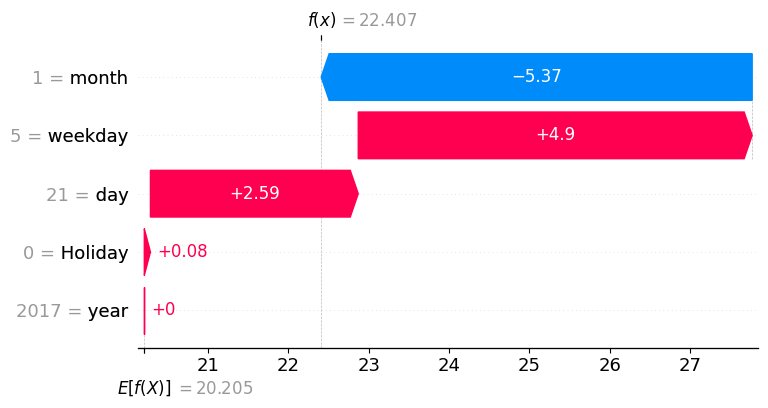

In [50]:
shar_model1(blstm)

In [51]:
data1= data.copy()
data1= data1[['date','sales']]


In [52]:
data1

date  sales
0    2013-01-01     13
1    2013-01-02     11
2    2013-01-03     14
3    2013-01-04     13
4    2013-01-05     10
...         ...    ...
1821 2017-12-27     14
1822 2017-12-28     19
1823 2017-12-29     15
1824 2017-12-30     27
1825 2017-12-31     23

[1826 rows x 2 columns]

In [53]:
data1.sort_values('date', inplace=True)
data1.set_index('date', inplace=True)
data1.head()

sales
date             
2013-01-01     13
2013-01-02     11
2013-01-03     14
2013-01-04     13
2013-01-05     10

In [54]:
train = data1.loc[:'2016-12-31']
valid = data1.loc['2017-01-01':]

No frequency information was provided, so inferred frequency D will be used.


<<<----------------------------------- Evaluating on Holts Linear Model ----------------------------------->>>



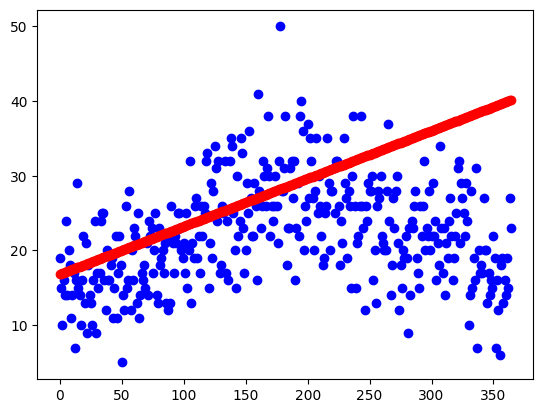

<<<----------------------------------- Training Set ----------------------------------->>>

R2 Score: -59.506223260482706
Mean square error  2613.2243812532574
Root Mean square error 51.119706388566605
<<<----------------------------------- Testing Set ----------------------------------->>>

R2 Score: -1.4577127079449324
Mean square error  118.5001424658636
Root Mean square error 10.885777072210491


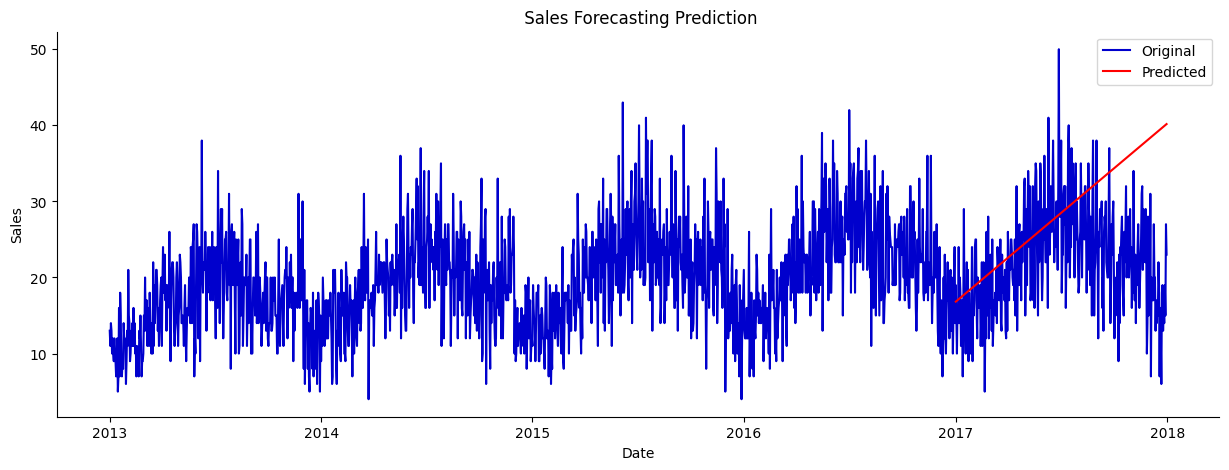

In [55]:
# Applying Holt's Linear Trend Model

hltm = Holt(train).fit()
pred1 = hltm.forecast(len(train))
pred2 = hltm.forecast(len(valid))

print('{}{}\033[1m Evaluating on Holts Linear Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)

Evaluate(15, pred1.values.reshape(-1), pred2.values.reshape(-1))

No frequency information was provided, so inferred frequency D will be used.


<<<----------------------------------- Evaluating on Holt Winter  Model ----------------------------------->>>



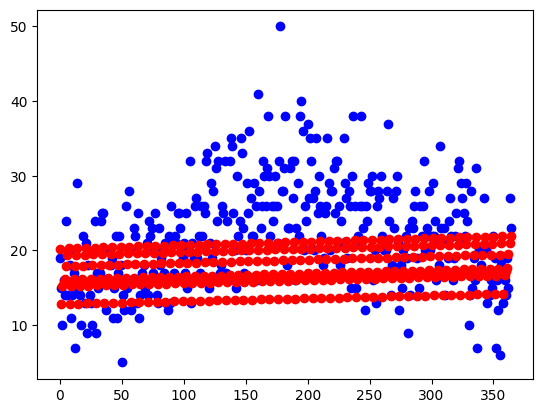

<<<----------------------------------- Training Set ----------------------------------->>>

R2 Score: -0.12517888398231314
Mean square error  48.59574328801784
Root Mean square error 6.971064716958081
<<<----------------------------------- Testing Set ----------------------------------->>>

R2 Score: -0.24884564622026017
Mean square error  60.21386735584645
Root Mean square error 7.759759490850632


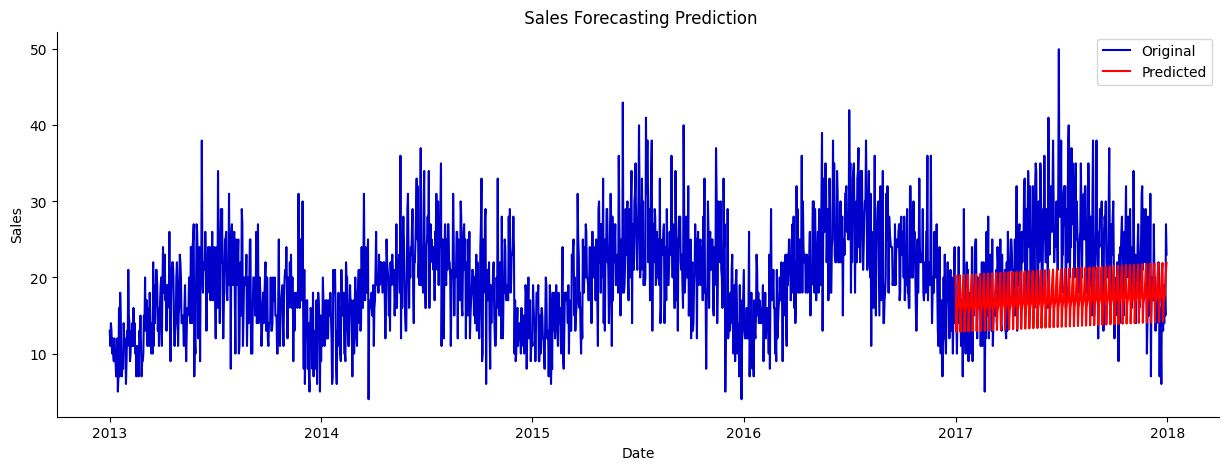

In [56]:
#model
# Applying Holt Winter's Model
hwm = ExponentialSmoothing(train, seasonal_periods=7, trend='add', seasonal='add', use_boxcox=True, initialization_method='estimated').fit()
pred1 = hwm.forecast(len(train))
pred2 = hwm.forecast(len(valid))

print('{}{}\033[1m Evaluating on Holt Winter  Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)

Evaluate(16, pred1.values.reshape(-1), pred2.values.reshape(-1))

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1461
Model:               SARIMAX(4, 1, 5)   Log Likelihood               -4380.155
Date:                Mon, 15 Jan 2024   AIC                           8780.311
Time:                        08:39:53   BIC                           8833.173
Sample:                    01-01-2013   HQIC                          8800.030
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5145      0.030    -17.280      0.000      -0.573      -0.456
ar.L2          0.2612      0.015     16.899      0.000       0.231       0.292
ar.L3         -0.5917      0.013    -44.882      0.0

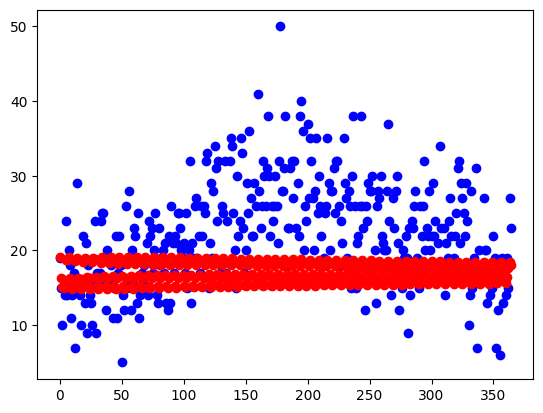

<<<----------------------------------- Training Set ----------------------------------->>>

R2 Score: -0.18984226212637467
Mean square error  51.38851248157323
Root Mean square error 7.168578135277123
<<<----------------------------------- Testing Set ----------------------------------->>>

R2 Score: -0.4749523369133799
Mean square error  71.11574167704151
Root Mean square error 8.433014981431109


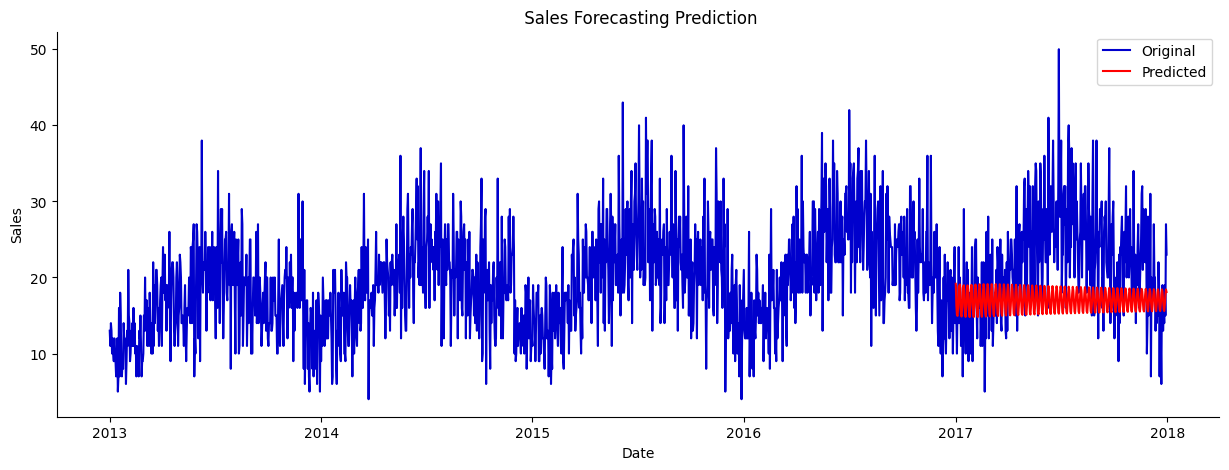

In [57]:
# Auto-ARIMA on boxcox-transformed training time series without seasonality
arima = auto_arima(train, d=1, seasonal=False)
print(arima.summary())

pred1 = arima.predict(len(train))
pred2 = arima.predict(len(valid))

print('{}{}\033[1m Evaluating on ARIMA Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)

Evaluate(17, pred1.values.reshape(-1), pred2.values.reshape(-1))

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                 1461
Model:             SARIMAX(3, 1, 5)x(0, 0, [1, 2], 7)   Log Likelihood               -4376.839
Date:                                Mon, 15 Jan 2024   AIC                           8775.678
Time:                                        08:50:06   BIC                           8833.827
Sample:                                    01-01-2013   HQIC                          8797.370
                                         - 12-31-2016                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3021      6.994      0.043      0.966     -13.406      14.010
ar.

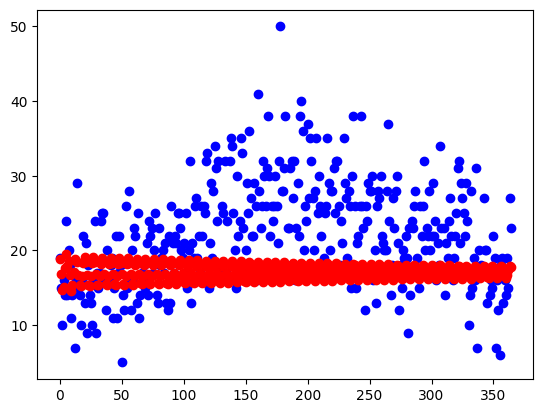

<<<----------------------------------- Training Set ----------------------------------->>>

R2 Score: -0.15041806043583805
Mean square error  49.685806883413
Root Mean square error 7.048815991598376
<<<----------------------------------- Testing Set ----------------------------------->>>

R2 Score: -0.47063990302613967
Mean square error  70.9078150026338
Root Mean square error 8.420677823229779


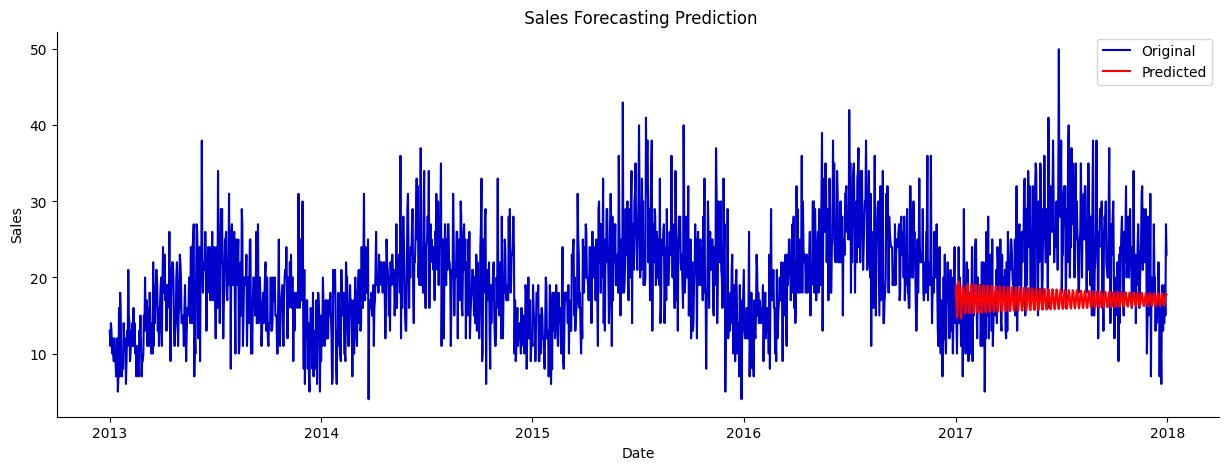

In [58]:
# Auto-ARIMA on boxcox-transformed training time series without seasonality
sarima = auto_arima(train, d=1, m=7)
print(sarima.summary())

pred1 = sarima.predict(len(train))
pred2 = sarima.predict(len(valid))

print('{}{}\033[1m Evaluating on ARIMA Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)

Evaluate(18, pred1.values.reshape(-1), pred2.values.reshape(-1))

In [59]:
train_df = train.copy()
valid_df = valid.copy()
for df in [train_df, valid_df]:
    df.reset_index(inplace=True)
    df.columns = ['ds', 'y']
    # Removing timezone information from datetime object
    df['ds'] = df['ds'].apply(lambda x: x.replace(tzinfo=None))

future = train_df.drop(columns='y')
future1 = valid_df.drop(columns='y')
#train_df['ds'] = pd.to_datetime(train_df['ds'])
train_df['ds'] = pd.to_datetime(train_df['ds'])


DEBUG:cmdstanpy:input tempfile: /tmp/tmpa3nas1tr/1h9r6lcb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa3nas1tr/wtrd5yo6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48127', 'data', 'file=/tmp/tmpa3nas1tr/1h9r6lcb.json', 'init=/tmp/tmpa3nas1tr/wtrd5yo6.json', 'output', 'file=/tmp/tmpa3nas1tr/prophet_modelwzmmpb_0/prophet_model-20240115085007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:50:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:50:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<<<----------------------------------- Evaluating on Prophet Model ----------------------------------->>>



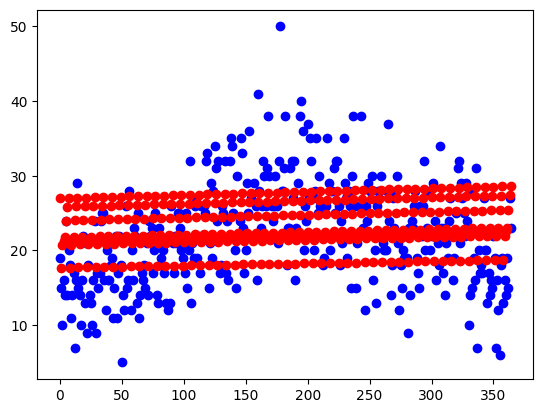

<<<----------------------------------- Training Set ----------------------------------->>>

R2 Score: 0.26328980167732774
Mean square error  31.81803372335243
Root Mean square error 5.640747620958805
<<<----------------------------------- Testing Set ----------------------------------->>>

R2 Score: 0.1756545007292427
Mean square error  39.746329499333385
Root Mean square error 6.304469010101753


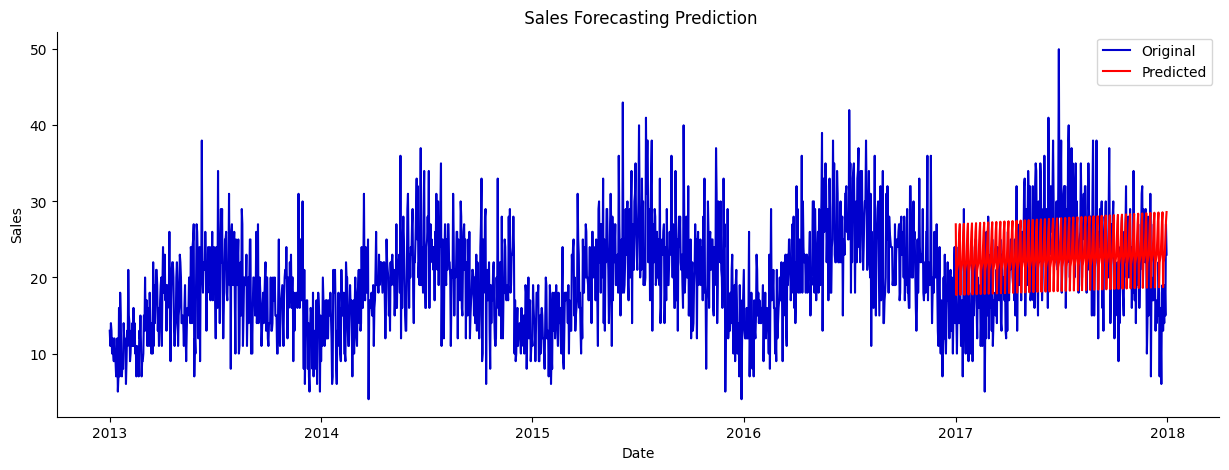

In [60]:
# Applying Prophet model
prophet = Prophet(weekly_seasonality=True, daily_seasonality=False, yearly_seasonality=False, seasonality_mode='multiplicative')
prophet.fit(train_df)


predictions = prophet.predict(future)
pred1 = predictions[['yhat']]
#pred1.set_index('ds', inplace = True)

predictions = prophet.predict(future1)
pred2 = predictions[['yhat']]
#pred2.set_index('ds', inplace = True)


print('{}{}\033[1m Evaluating on Prophet Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)



Evaluate(19, pred1.values.reshape(-1), pred2.values.reshape(-1))


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


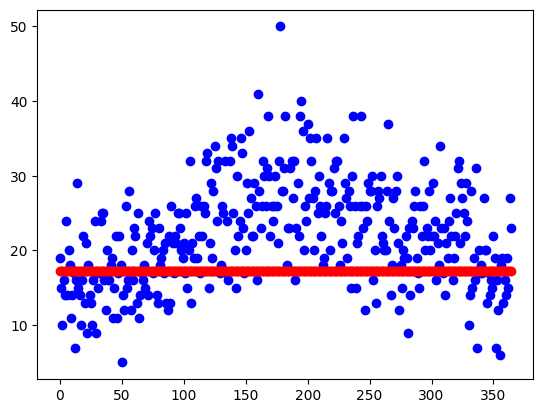

<<<----------------------------------- Training Set ----------------------------------->>>

R2 Score: 0.4717263317405457
Mean square error  22.815795722806577
Root Mean square error 4.776588293207462
<<<----------------------------------- Testing Set ----------------------------------->>>

R2 Score: -0.49753396613432255
Mean square error  72.20452893486164
Root Mean square error 8.497324810483688


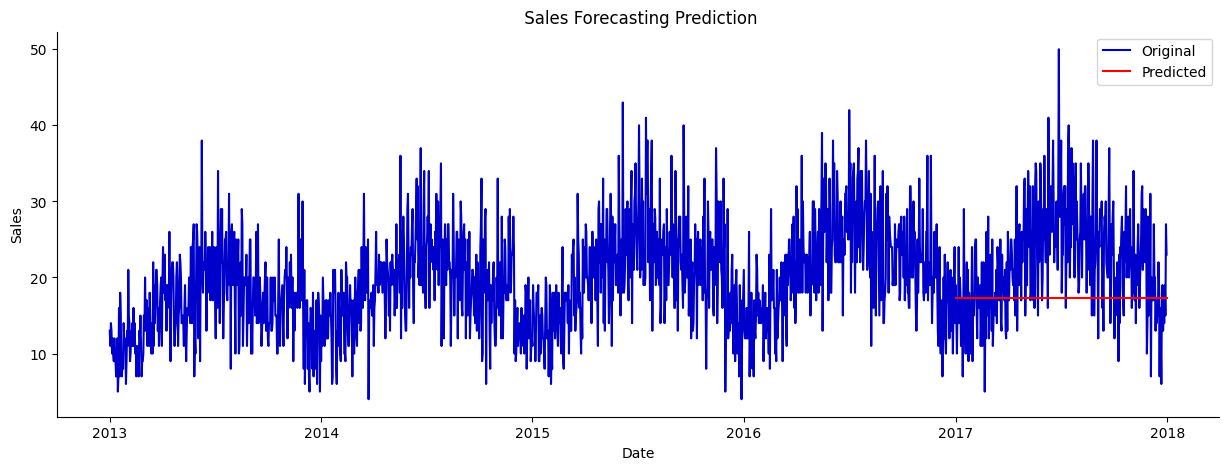

In [61]:
data2=data.copy()
train_len=1461
ma_window = 7
data2['sma_forecast'] = data['sales'].rolling(ma_window).mean()
data2['sma_forecast'][train_len:] = data2['sma_forecast'][train_len-1]

# train
temp1=data['sales'].iloc[:7]
#print(pred1.shape)
temp=data2['sma_forecast'].iloc[7:train_len]
#print(temp.shape)
pred1 = temp1.append(temp, ignore_index=True)
#print(pred1)

pred2=data2['sma_forecast'].iloc[train_len:]


Evaluate(20, pred1.values.reshape(-1), pred2.values.reshape(-1))

In [72]:
EMC = CM.copy()
EMC.index = ['Random Forest', 'Linear' , 'Lasso', 'ElasticNet', 'XGBoost', 'Decision Tree', 'Gaussian' ,'SVR', 'K-NN', 'Extra-Tree', 'Adaboost', 'LGB', 'LSTM','stake-LSTM','Bi-LSTM','Holts','Holts-Winter','ARIMA','SARIMA','prophet','SME']
EMC

Train_R2     Train_MSE    Train_RMSE   Test_R2    Test_MSE  \
Random Forest   0.930078  3.019895e+00  1.737785e+00  0.424282   27.758614   
Linear          0.259594  3.197763e+01  5.654877e+00  0.161628   40.422618   
Lasso           0.231529  3.318978e+01  5.761057e+00  0.185908   39.251928   
ElasticNet      0.233831  3.309034e+01  5.752420e+00  0.188493   39.127326   
XGBoost         0.957743  1.825037e+00  1.350939e+00  0.327157   32.441547   
Decision Tree   1.000000  0.000000e+00  0.000000e+00  0.194543   38.835616   
Gaussian        1.000000  1.467287e-18  1.211316e-09 -2.726266  179.664215   
SVR            -0.005942  4.344598e+01  6.591357e+00 -0.222952   58.965377   
K-NN            0.008156  4.283710e+01  6.545006e+00 -0.311119   63.216438   
Extra-Tree      1.000000  0.000000e+00  0.000000e+00  0.308284   33.351498   
Adaboost        0.960222  1.717969e+00  1.310713e+00  0.411221   28.388362   
LGB             1.000000  0.000000e+00  0.000000e+00  0.177439   39.660274   
LSTM            0.286435  3.081842e+01  5.551434e+00  0.293332   34.072445   
stake-LSTM      0.775490  9.696422e+00  3.113908e+00  0.146844   41.135465   
Bi-LSTM         0.884211  5.000869e+00  2.236262e+00  0.194723   38.826917   
Holts         -59.506223  2.613224e+03  5.111971e+01 -1.457713  118.500142   
Holts-Winter   -0.125179  4.859574e+01  6.971065e+00 -0.248846   60.213867   
ARIMA          -0.189842  5.138851e+01  7.168578e+00 -0.474952   71.115742   
SARIMA         -0.150418  4.968581e+01  7.048816e+00 -0.470640   70.907815   
prophet         0.263290  3.181803e+01  5.640748e+00  0.175655   39.746329   
SME             0.471726  2.281580e+01  4.776588e+00 -0.497534   72.204529   

               Test_RMSE  
Random Forest   5.268644  
Linear          6.357878  
Lasso           6.265136  
ElasticNet      6.255184  
XGBoost         5.695748  
Decision Tree   6.231823  
Gaussian       13.403888  
SVR             7.678892  
K-NN            7.950877  
Extra-Tree      5.775076  
Adaboost        5.328073  
LGB             6.297640  
LSTM            5.837161  
stake-LSTM      6.413694  
Bi-LSTM         6.231125  
Holts          10.885777  
Holts-Winter    7.759759  
ARIMA           8.433015  
SARIMA          8.420678  
prophet         6.304469  
SME             8.497325

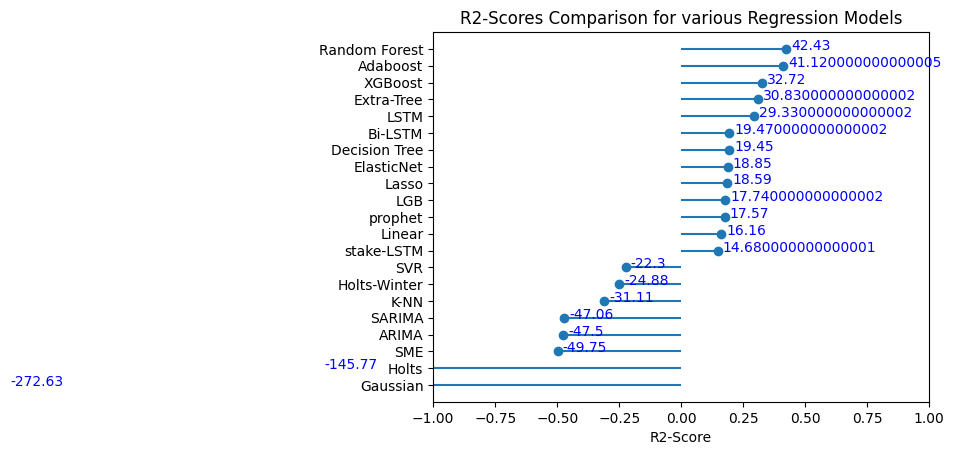

In [73]:
R2 = round(EMC['Test_R2'].sort_values(ascending=True),4)
plt.hlines(y=R2.index, xmin=0, xmax=R2.values)
plt.plot(R2.values, R2.index,'o')
plt.title('R2-Scores Comparison for various Regression Models')
plt.xlabel('R2-Score')
#plt.ylabel('Regression Models')
for i, v in enumerate(R2):
    plt.text(v+0.02, i-0.05, str(v*100), color='blue')
plt.xlim([-1,1])
plt.show()

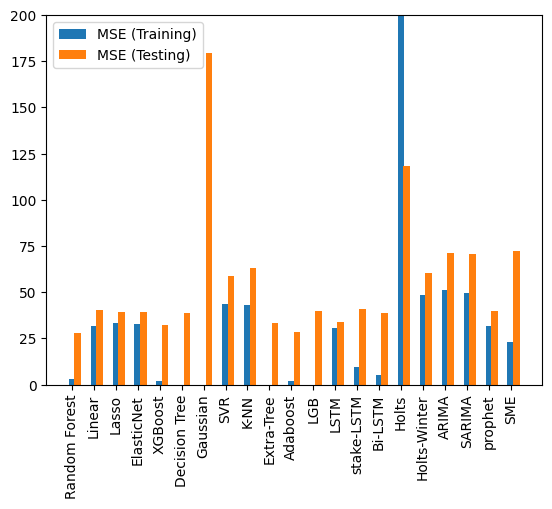

In [75]:
n=21  # number of algoirthm
r = np.arange(n)
width = 0.25

# graph of training and testing value of MSE
plt.bar(r, CM['Train_MSE'], width=0.3, label='MSE (Training)')
plt.bar(r+width, CM['Test_MSE'], width=0.3, label='MSE (Testing)')
plt.xticks(r,EMC.index, rotation =90)
plt.legend()
plt.ylim([0,200])
plt.show()

<<<----------------------------------- Evaluating on LGM Model ----------------------------------->>>



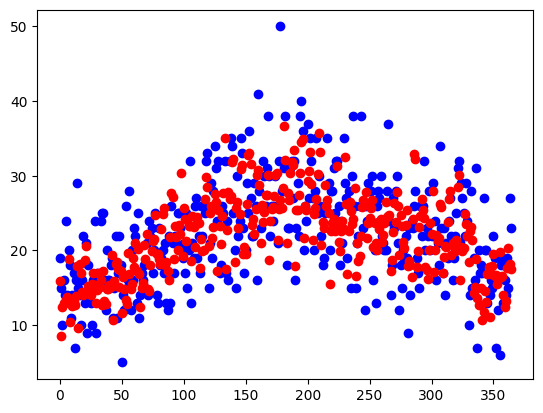

<<<----------------------------------- Training Set ----------------------------------->>>

R2 Score: 0.9596385645882121
Mean square error  1.7431841122588911
Root Mean square error 1.3202969788115442
<<<----------------------------------- Testing Set ----------------------------------->>>

R2 Score: 0.41213165036539534
Mean square error  28.344437068530482
Root Mean square error 5.323949386360701


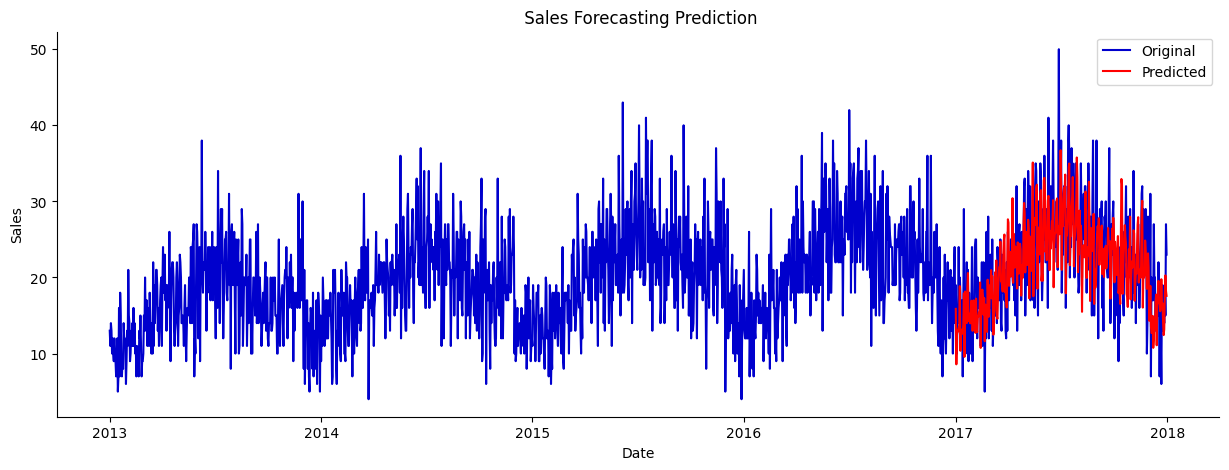

In [85]:
#ensemble model

from sklearn.ensemble import VotingRegressor


r1 = RandomForestRegressor(n_estimators=200)
r2 =AdaBoostRegressor(base_estimator=RandomForestRegressor(n_estimators=100))
r3=xgb.XGBRegressor()


v=VotingRegressor([('RF',r1), ('ada', r2), ('xgb', r3)])
# train the model on the training data
v.fit(X_train, y_train)

#predict the traing and testing values
pred1 = v.predict(X_train)
pred2 = v.predict(X_test)

print('{}{}\033[1m Evaluating on LGM Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)

Evaluate(21, pred1, pred2)

ExactExplainer explainer: 366it [07:51,  1.31s/it]


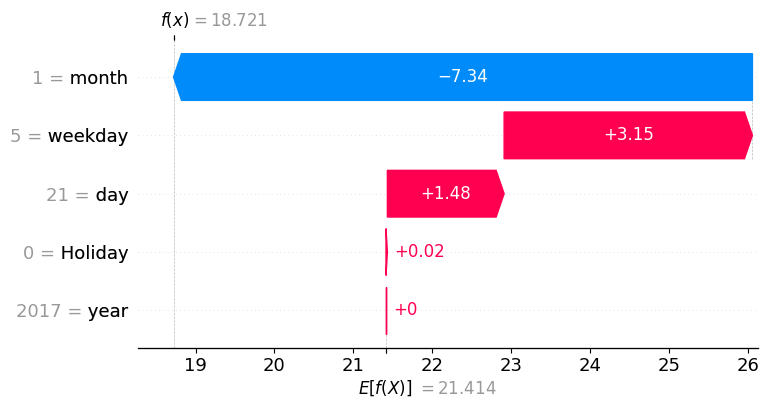

In [86]:
shar_model1(v)

In [93]:
# generating next 6 month date for predication
df_test = pd.DataFrame({'date':pd.date_range(start='1/1/2018', end='12/31/2018')})
print(df_test)
df_test["date"] = pd.to_datetime(df_test["date"], format='%d-%m-%Y', errors='ignore').astype('datetime64[D]')

          date
0   2018-01-01
1   2018-01-02
2   2018-01-03
3   2018-01-04
4   2018-01-05
..         ...
360 2018-12-27
361 2018-12-28
362 2018-12-29
363 2018-12-30
364 2018-12-31

[365 rows x 1 columns]


In [94]:
# extract the day, month, and year, week day
df_test['date'] = pd.to_datetime(df_test['date'])
df_test['day'] = df_test['date'].dt.day
df_test['month'] = df_test['date'].dt.month
df_test['year'] = df_test['date'].dt.year
df_test['weekday'] = df_test['date'].dt.weekday

In [95]:
# holiday
cal = calendar()
holidays = cal.holidays(start=df_test['date'].min(), end=df_test['date'].max())

df_test['Holiday'] = df_test['date'].isin(holidays)
print(df_test)

          date  day  month  year  weekday  Holiday
0   2018-01-01    1      1  2018        0     True
1   2018-01-02    2      1  2018        1    False
2   2018-01-03    3      1  2018        2    False
3   2018-01-04    4      1  2018        3    False
4   2018-01-05    5      1  2018        4    False
..         ...  ...    ...   ...      ...      ...
360 2018-12-27   27     12  2018        3    False
361 2018-12-28   28     12  2018        4    False
362 2018-12-29   29     12  2018        5    False
363 2018-12-30   30     12  2018        6    False
364 2018-12-31   31     12  2018        0    False

[365 rows x 6 columns]


In [96]:
# convert holiday into 0 and 1
le = preprocessing.LabelEncoder()
df_test['Holiday'] = le.fit_transform(df_test.Holiday.values)

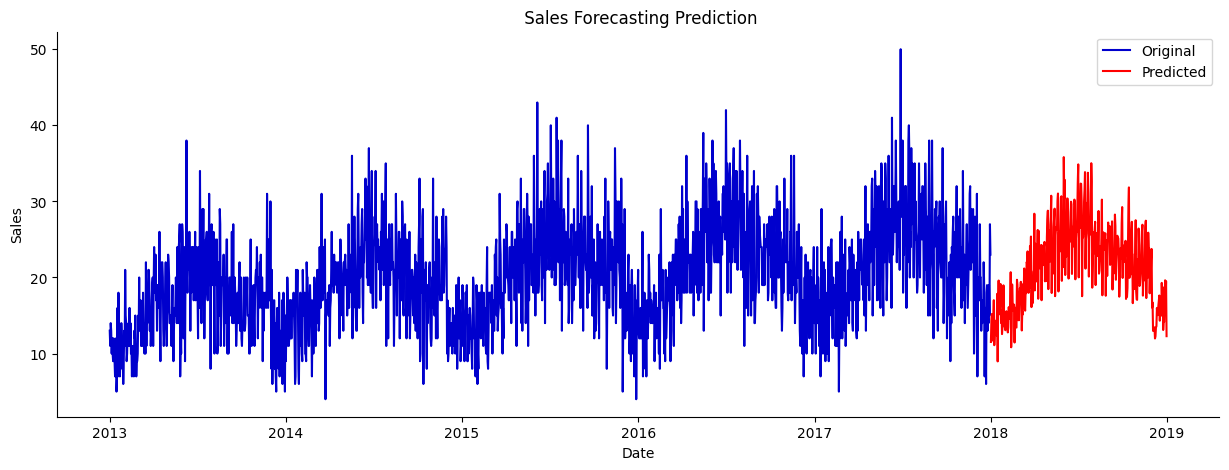

In [97]:
# run with best model

X_test_pr = df_test[['day', 'month', 'year', 'weekday', 'Holiday']]

pred_fu = RF.predict(X_test_pr)

# generate the graph

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x=data.date, y=data.sales, data=data, ax=ax,
            label='Original', color='mediumblue')

sns.lineplot(x=df_test.date, y=pred_fu.reshape(-1), data=df_test, ax=ax,
            label='Predicted', color='Red')

ax.set(xlabel = "Date",
      ylabel = "Sales",
      title = " Sales Forecasting Prediction")

ax.legend()

sns.despine()


In [ ]:
y_hat_sma = data.copy()
train_len = 1461
train = data[0:train_len] # first 120 months as training set
test = data[train_len:] # last 24 months as out-of-time test set

y_hat_sma['sma_forecast_4'] = data['sales'].rolling(4).mean()
y_hat_sma['sma_forecast_7'] = data['sales'].rolling(7).mean()
y_hat_sma['cma_forecast_7'] = data['sales'].expanding(min_periods=7).mean()
y_hat_sma['ema_forecast_7'] = data['sales'].ewm(span=7,adjust=False).mean()


plt.figure(figsize=(20,5))
plt.grid()
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(y_hat_sma['sma_forecast_4'], label='Simple moving average forecast of 4 days')
plt.plot(y_hat_sma['sma_forecast_7'], label='Simple moving average forecast of 7 days')
plt.plot(y_hat_sma['cma_forecast_7'], label='Cumulative moving average forecast')
plt.plot(y_hat_sma['ema_forecast_7'], label='Exponential moving average forecast')

plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

In [ ]:
y_hat_sma.tail(100)

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['sales'], y_hat_sma['sma_forecast_4'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-y_hat_sma['sma_forecast_4'][train_len:])/test['sales'])*100,2)
print("Simple moving average forecast 4 Root Mean square error is ", rmse, "Mean squeare error",mape)
rmse1 = np.sqrt(mean_squared_error(test['sales'], y_hat_sma['sma_forecast_7'][train_len:])).round(2)
mape1 = np.round(np.mean(np.abs(test['sales']-y_hat_sma['sma_forecast_7'][train_len:])/test['sales'])*100,2)
print("Simple moving average forecast 7 Root Mean square error is ", rmse1, "Mean squeare error",mape1)
rmse2 = np.sqrt(mean_squared_error(test['sales'], y_hat_sma['cma_forecast_7'][train_len:])).round(2)
mape2 = np.round(np.mean(np.abs(test['sales']-y_hat_sma['cma_forecast_7'][train_len:])/test['sales'])*100,2)
print("Cumulative moving average forecast 4 Root Mean square error is ", rmse2, "Mean squeare error",mape2)
rmse3 = np.sqrt(mean_squared_error(test['sales'], y_hat_sma['ema_forecast_7'][train_len:])).round(2)
mape3 = np.round(np.mean(np.abs(test['sales']-y_hat_sma['ema_forecast_7'][train_len:])/test['sales'])*100,2)
print("Exponential moving average forecast 4 Root Mean square error is ", rmse3, "Mean squeare error",mape3)
#results = pd.DataFrame({'Method':['Simple moving average forecast 4'], 'MAPE': [mape], 'RMSE': [rmse]},{'Method':['Simple moving average forecast 7'], 'MAPE': [mape1], 'RMSE': [rmse1]},{'Method':['Cumulative  moving average forecast'], 'MAPE': [mape2], 'RMSE': [rmse2]},{'Method':['Exponential Moving Average'], 'MAPE': [mape3], 'RMSE': [rmse3]})
#results = results[['Method', 'RMSE', 'MAPE']]
#results